## https://www.kaggle.com/c/ieee-fraud-detection

# Links to each features

Go to <a href=#Functions>Functions</a>

Go to <a href=#Trans>Trans features</a>

Go to <a href=#card>ProductCD, card features</a>

Go to [addr, dist, email features](#addr)

Go to <a href=#C>C features</a>

Go to <a href=#D>D features</a>

Go to where I left [left here](#here)

Go to <a href=#M>M features</a>

Go to <a href=#V>V features</a>

Go to <a href=#id>id features</a>

Go to <a href=#Device>Device features</a>

Go to [dtypes](#dtypes)

# IEEE-CIS Fraud Detection
## Can you detect fraud from customer transactions?

In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

**Categorical Features - Transaction**
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Categorical Features - Identity**
- DeviceType
- DeviceInfo
- id_12 - id_38

The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

You can read more about the data from this post by the competition host.

**Files**

train_{transaction, identity}.csv - the training set
test_{transaction, identity}.csv - the test set (you must predict the isFraud value for these observations)
sample_submission.csv - a sample submission file in the correct format

In [1]:
import pandas as pd
import numpy as np

# for plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff

# Data Exploring

In [3]:
train_id = pd.read_csv('ieee-fraud-detection/train_identity.csv',dtype=df_dtypes) #df_dtypes at the bottom

In [4]:
train_trans = pd.read_csv('ieee-fraud-detection/train_transaction.csv',dtype=df_dtypes) 

In [5]:
test_id = pd.read_csv('ieee-fraud-detection/test_identity.csv',dtype=df_dtypes) #df_dtypes at the bottom

In [6]:
test_trans = pd.read_csv('ieee-fraud-detection/test_transaction.csv',dtype=df_dtypes)

In [7]:
df = train_trans.merge(train_id, how='left', on='TransactionID')

In [8]:
df_test = test_trans.merge(test_id, how='left', on='TransactionID')

In [9]:
del train_trans, train_id

In [10]:
del test_trans, test_id

In [11]:
target = 'isFraud'

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(399), int32(3), int8(1), object(31)
memory usage: 1.0+ GB


In [26]:
df_test.dtypes

TransactionID       int32
TransactionDT       int32
TransactionAmt    float32
ProductCD          object
card1               int64
                   ...   
id-36              object
id-37              object
id-38              object
DeviceType         object
DeviceInfo         object
Length: 433, dtype: object

In [2505]:
# def change_dtype(df,type_to_change_dict):
#     for feature in type_to_change_dict:
#         df[feature] = df[feature].astype(type_to_change_dict[feature])

In [2756]:
# #reduce memory use
# # float32, int32 is enough to hold these data and to get sum and mean (checked)
# for col in df.columns:
#     if df[col].dtype == np.float64:
#         change_dtype(df, {col:np.float32})
#     elif df[col].dtype == np.int64:
#         change_dtype(df, {col:np.int32})

# for col in df_test.columns:
#     if df_test[col].dtype == np.float64:
#         change_dtype(df_test, {col:np.float32})
#     elif df_test[col].dtype == np.int64:
#         change_dtype(df_test, {col:np.int32})
        
# # only binary values
# df['isFraud']=df['isFraud'].astype(np.int8)

## Let's take a look at the data

In [2321]:
list(df.columns)[:4]

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt']

# Functions <a name='Functions' />

In [7]:
# Function to show data information
def summary_table(df, target_df=None):
    '''
    Make a summary table with features as rows. Put .transpose() if feature list is short.
    '''
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['missing'] = df.isnull().sum().values    
    summary['uniques'] = df.nunique().values
    summary['min'] = [df[col].min() if df[col].dtype !='O' else '-' for col in df.columns ]
    summary['max'] = [df[col].max() if df[col].dtype !='O' else '-' for col in df.columns ]
    index_df = pd.DataFrame()
    count_df = pd.DataFrame()
    for col in df.columns:
        val_ct = df[col].value_counts()
        index_df[col]= [val_ct.index[i] if i<len(val_ct) else '-' for i in range(3)]
        count_df[col]= [val_ct.values[i] if i<len(val_ct) else '-' for i in range(3)]
    summary['top'] = index_df.loc[0].values
    summary['1-freq'] = count_df.loc[0].values
    summary['2nd most'] = index_df.loc[1].values
    summary['2-freq'] = count_df.loc[1].values
    summary['3rd most'] = index_df.loc[2].values
    summary['3-freq'] = count_df.loc[2].values
    if target_df is not None:
        Frd_ratio = []
        for col in df.columns:
            tmp = target_df[df[col].notna()]
            Frd_ratio.append(np.round((tmp==1).sum()/len(tmp),decimals=3))
        summary['Frd ratio']  = Frd_ratio
#     summary['top'] = [df[col].value_counts(dropna=False).index[0] for col in df.columns]
#     summary['freq'] = [df[col].value_counts(dropna=False).values[0] for col in df.columns]

    summary.set_index('Name', inplace = True)
    summary = summary.rename_axis(None)
    return summary

In [8]:
# Function to plot the statistics for categorical data
def bar_plot(df, feature, target = 'isFraud', fill_na = 'null', others_threshold = 5000, 
             target_plots =True, xtick_rotate = False, reduced = False, box_plot = True, sorted_plot_order = False):
#     if sorted_plot_order:
#         assert (type(fill_na) == np.int)|(type(fill_na) == np.float), 'fill_na should be number for sorted_plot_order'
    total_num = len(df)
    if feature != target:
        df_trans = df[[target, feature, 'TransactionAmt']].copy()
        if fill_na is not None:
            df_trans[feature] = df_trans[feature].fillna(fill_na)

            
        df_trans.loc[df_trans[feature].isin(df_trans[feature].value_counts(dropna=False)\
                    [df_trans[feature].value_counts(dropna=False) <= others_threshold ].index)\
                     , feature] = "others"
        
#         if df_trans[feature].dtypes.kind in 'OS':
#             df_trans.loc[df_trans[feature].isin(df_trans[feature].value_counts(dropna=False)\
#                     [df_trans[feature].value_counts(dropna=False) <= others_threshold ].index)\
#                      , feature] = "others"
#         elif df_trans[feature].dtypes.kind in 'buicf':
#             df_trans.loc[df_trans[feature].isin(df_trans[feature].value_counts(dropna=False)\
#                     [df_trans[feature].value_counts(dropna=False) <= others_threshold ].index)\
#                      , feature] = -888

        tmp = pd.crosstab(df_trans[feature], df_trans[target], normalize='index') * 100
        tmp.reset_index(inplace = True)
        tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    #    plot_order = list(df_trans[feature].unique())
#         if sorted_plot_order:
#             plot_order = np.sort(df_trans[feature].unique())
#         else:
#             plot_order = df_trans[feature].value_counts().keys()

    #     perc_amt = (df_trans.groupby([target,feature])['TransactionAmt'].sum() / total_amt * 100).unstack(target)
    #     perc_amt = perc_amt.reset_index()
    #     perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
        groupby_amt = df_trans.groupby([feature, target])['TransactionAmt'].sum()

        tmp_amt = (groupby_amt).unstack(target) 
        tmp_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
        perc_amt = tmp_amt.div(tmp_amt.sum(axis=1), axis=0) *100
        perc_amt.reset_index(inplace = True)
        tmp_amt.reset_index(inplace = True)
        tmp_amt['total'] = tmp_amt['NoFraud']+tmp_amt['Fraud']
        total_amt = tmp_amt['total'].sum()

        tmp_amt_expanded = pd.DataFrame(groupby_amt).reset_index()
        
    
    elif feature == target:
        target_plots = False
        df_trans = df[[feature, 'TransactionAmt']].copy()
        groupby_amt = df_trans.groupby([feature])['TransactionAmt'].sum()
        tmp_amt = pd.DataFrame(groupby_amt).reset_index()
        tmp_amt.rename(columns={'TransactionAmt':'total'}, inplace = True)
        total_amt = tmp_amt['total'].sum()
    

    if sorted_plot_order:
        str_val = []
        num_val = []
        for value in df_trans[feature].unique():
            if type(value) == np.str:
                str_val.append(value)
            else:
                num_val.append(value)
        plot_order = list(np.sort(str_val))+list(np.sort(num_val))
    else:
        plot_order = df_trans[feature].value_counts().keys()
      
                
    plt.figure(figsize=(14,13))
    if target_plots & (not reduced):
        title_y = 0.92
    elif reduced:
#        title_y = 1.02 #if use tight layout
        title_y = 0.94
    else:
        title_y = 0.95 #default 0.98
    plt.suptitle(f'{feature} Distributions', fontsize=22, y=title_y)
        
    plt.subplot(321)
    g = sns.countplot(x=feature, data=df_trans, order = plot_order)
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

    g.set_title(f"Frequency", fontsize=19)
    g.set_xlabel(f"{feature} Values", fontsize=17)
    if xtick_rotate:
        g.set_xticklabels(g.get_xticklabels(), rotation=30, ha="right")
    g.set_ylabel("Count", fontsize=17)
#     if feature == target:
#         g.set_ylim(0,total_num *1.1)
#     else:
#         g.set_ylim(0,550000 )
    heights = []
    for p in g.patches:
        height = p.get_height()
        heights.append(height)
#         if i == 0:
#             max_height = height   #bars are in descending order
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_num*100),
                ha="center", fontsize=14)
    g.set_ylim(0, max(heights) *1.1 )
    
    if reduced:
        g_pt = g.twinx()
        g_pt = sns.pointplot(x=feature, y='Fraud', data=tmp, color='black', order=plot_order, legend=False)
        g_pt.set_ylabel("% of Fraud (Counts)", fontsize=16)

    if (target_plots) & (not reduced):
        plt.subplot(322)
        g2 = sns.countplot(x=feature, hue=target, data=df_trans, order = plot_order)

        g2_pt = g2.twinx()
        g2_pt = sns.pointplot(x=feature, y='Fraud', data=tmp, color='black', order=plot_order, legend=False)
        g2_pt.set_ylabel("% of Fraud (Counts)", fontsize=16)

        g2.set_title(f"Frequency by Target({target})", fontsize=19)
        g2.set_xlabel(f"{feature} Values", fontsize=17)
        if xtick_rotate:
            g2.set_xticklabels(g2.get_xticklabels(), rotation=30, ha="right")
        g2.set_ylabel("Count", fontsize=17)

    if (target_plots) & (not reduced):
        plt.subplot(323)
    elif (not target_plots) | reduced:
        plt.subplot(322)
    sns.set_color_codes("pastel")
    g4 = sns.barplot(x=feature, y='total', data=tmp_amt , order = plot_order )
    g4.set_title(f"Transaction Amount", fontsize=20)
    g4.set_xlabel(f"{feature} Values", fontsize=17)
    if xtick_rotate:
        g4.set_xticklabels(g4.get_xticklabels(), rotation=30, ha="right")
    g4.set_ylabel("Transaction Amt $", fontsize=17)
    
    heights = []
    for p in g4.patches:
        height = p.get_height()
        heights.append(height)
        g4.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt*100),
            ha="center", fontsize=14)
    g4.set_ylim(0, max(heights) * 1.1 )
    
    if reduced:
        g4_pt = g4.twinx()
        g4_pt = sns.pointplot(x=feature, y='Fraud', data=perc_amt, order=plot_order,
                           color='black', legend=False )
        g4_pt.set_ylabel("% of Fraud ($ Amount)", fontsize=16)
    
    
    if target_plots & (not reduced):
        plt.subplot(324)
        sns.set_color_codes("muted")
        g4_hue = sns.barplot(x=feature, y='TransactionAmt', data=tmp_amt_expanded , hue = target , order = plot_order)
        g4_hue.set_title(f"Transaction Amount by Target", fontsize=20)
        g4_hue.set_xlabel(f"{feature} Values", fontsize=17)
        if xtick_rotate:
            g4_hue.set_xticklabels(g4_hue.get_xticklabels(), rotation=30, ha="right")
        g4_hue.set_ylabel("Transaction Amt $", fontsize=17)    
        
        g4_pt = g4_hue.twinx()
        g4_pt = sns.pointplot(x=feature, y='Fraud', data=perc_amt, order=plot_order,
                           color='black', legend=False )
        g4_pt.set_ylabel("% of Fraud ($ Amount)", fontsize=16)

    if target_plots & box_plot:
        if reduced:
            plt.subplot(312)
        else:
            plt.subplot(313)
        g3 = sns.boxenplot(x=feature, y='TransactionAmt', hue=target, 
                      data=df_trans[df_trans['TransactionAmt'] <= 2000] , order = plot_order )
        g3.set_title(f"Transaction Amount Distribution", fontsize=20)
        g3.set_xlabel(f"{feature} Values", fontsize=17)
#         if xtick_rotate:
#             g3.set_xticklabels(g3.get_xticklabels(), rotation=30,ha="right")
        g3.set_ylabel("Transaction Amt $", fontsize=17)


#        plt.tight_layout()
    if reduced:
        plt.subplots_adjust(wspace = 0.25)
    else:
        plt.subplots_adjust(hspace = 0.6, top = 0.85)
    plt.show()


# Function to plot Histograms for float valued features
def dist_plot(df, feature, target = 'isFraud', fill_nan = False ,bin_num = 30 , df_test=pd.DataFrame(),\
              TransAmt_plot = True):
    plt.figure(figsize=(14,8))
    plt.suptitle(f'{feature} Distributions', fontsize=22)
    TransAmt = (feature == 'TransactionAmt')
    if len(df_test) == 0:
        if TransAmt:
            df_trans = df[[target, 'TransactionAmt']].copy()
        else:
            df_trans = df[[target, feature, 'TransactionAmt']].copy()
        if fill_nan:
            df_trans[feature].fillna(df_trans[feature].mean(), inplace = True)
            df_NoFraud = df_trans[df_trans[target] == 0]
            df_Fraud = df_trans[df_trans[target] == 1]
        else:
            df_NoFraud = df_trans[(df_trans[target] == 0) & (df_trans[feature].notna())]
            df_Fraud = df_trans[(df_trans[target] == 1) & (df_trans[feature].notna())]

        plt.subplot(211)


        bin_num = bin_num

        g = sns.distplot(df_NoFraud[feature], bins=bin_num, kde=False, label='NoFraud')
        height = []
        x_values = []
        bin_edges = []
        for i, p in enumerate(g.patches):
            if i == 0:
                bin_edges.append(p.get_x())
            height.append(p.get_height()) 
            x_values.append(p.get_x()+p.get_width()/2.)
            bin_edges.append(p.get_x()+p.get_width())
        g = sns.distplot(df_Fraud[feature], bins=bin_num, kde=False, label='Fraud')

        height_f = []
        for p in g.patches[bin_num:]:
            height_f.append(p.get_height())
        fraud_perc = np.array(height_f)/(np.array(height_f)+np.array(height)) *100


        g.legend(loc='upper left')
        g.set_title(f"{feature} Frequency by Target", fontsize=20)
        g.set_xlabel(f"{feature} Values", fontsize=18)
        g.set_ylabel("Counts by bin", fontsize=18)

        df_f_perc =  pd.DataFrame({feature:x_values ,'Fraud': fraud_perc})

        g_pt = g.twinx()
        g_pt = sns.distplot(df_f_perc[feature], hist=True, kde = False, rug=False, bins = bin_edges,\
                hist_kws={'weights': df_f_perc['Fraud'],"histtype": "step","linewidth": 3 ,\
                          'color':'k'}, label='% of Fraud each bin')
        g_pt.set_ylabel("% of Fraud (counts)", fontsize=16)
        g_pt.legend()

        if (TransAmt ==False)&(TransAmt_plot):
            plt.subplot(212)

            g2 = sns.distplot(df_NoFraud[feature], bins=bin_num, kde=False,\
                              label='NoFraud',hist_kws={'weights': df_NoFraud['TransactionAmt']})
            height = []
            for i, p in enumerate(g2.patches):
                height.append(p.get_height())

            g2 = sns.distplot(df_Fraud[feature], bins=bin_num, kde=False,\
                              label='Fraud',hist_kws={'weights': df_Fraud['TransactionAmt']})
            height_f = []
            for p in g2.patches[bin_num:]:
                height_f.append(p.get_height())
            fraud_perc = np.array(height_f)/(np.array(height_f)+np.array(height)) *100

            g2.legend(loc='upper left')
            g2.set_title(f"{feature} Transaction Amount by Target", fontsize=20)
            g2.set_xlabel(f"{feature} Values", fontsize=18)
            g2.set_ylabel("TransAmt $ by bin", fontsize=18)

            df_f_perc =  pd.DataFrame({feature:x_values ,'Fraud': fraud_perc})

            g2_pt = g2.twinx()
            g2_pt = sns.distplot(df_f_perc[feature], hist=True, kde = False, rug=False, bins = bin_edges,\
                    hist_kws={'weights': df_f_perc['Fraud'],"histtype": "step","linewidth": 3 ,\
                              'color':'k'},  label='% of Fraud each bin')
            g2_pt.set_ylabel("% of Fraud ($ Amount)", fontsize=16)
            g2_pt.legend()

        plt.subplots_adjust(hspace = 0.6, top = 0.85)
        plt.show()

        
    elif len(df_test)>0:
        if TransAmt:
            df_trans = df[['TransactionAmt']].copy()
            df_test = df_test[['TransactionAmt']].copy()
        else:
            df_trans = df[[ feature, 'TransactionAmt']].copy()
            df_test = df_test[[ feature, 'TransactionAmt']].copy()
        if fill_nan:
            df_trans[[feature]].fillna(df_trans.mean(), inplace = True)
            df_test[[feature]].fillna(df_trans.mean(), inplace = True)
            
        plt.subplot(211)

        bin_num = 30

        g = sns.distplot(df_trans[feature], bins=bin_num, kde=False, label='train')
        bin_width = next(iter(g.patches)).get_width()
        bin_arr = np.arange(df_test[feature].min(), df_test[feature].max(), bin_width)
        g = sns.distplot(df_test[feature], bins=bin_arr, kde=False, label='test')
      
        
        g.legend(loc='upper left')
        g.set_title(f"{feature} Frequency", fontsize=20)
        g.set_xlabel(f"{feature} Values", fontsize=18)
        g.set_ylabel("Counts by bin", fontsize=18)


        if (TransAmt ==False)&(TransAmt_plot):
            plt.subplot(212)

            g2 = sns.distplot(df_trans[feature], bins=bin_num, kde=False,\
                              label='train',hist_kws={'weights': df_trans['TransactionAmt']})
            g2 = sns.distplot(df_test[feature], bins=bin_arr, kde=False,\
                              label='test',hist_kws={'weights': df_test['TransactionAmt']})

            g2.legend(loc='upper left')
            g2.set_title(f"{feature} Transaction Amount", fontsize=20)
            g2.set_xlabel(f"{feature} Values", fontsize=18)
            g2.set_ylabel("TransAmt $ by bin", fontsize=18)

        plt.subplots_adjust(hspace = 0.6, top = 0.85)
#         plt.tight_layout()
        plt.show()

In [34]:
def scatter_plot(df, col,col2 = 'TransactionDT', df_test = pd.DataFrame(), scatter_size = 5):
#     if len(df_test)>0:
#         df = pd.concat([df_train[[col2,col]],df_test[[col2,col]]],axis=0,sort=False)
#     else:
#         df = df_train
    plt.figure(figsize=(15,4))
    plt.scatter(df.TransactionDT,df[col], label='train', s = scatter_size**2)
    if len(df_test)>0:
        plt.scatter(df_test.TransactionDT,df_test[col], label='test', s = scatter_size**2)
    plt.title(f'{col} over TransactionDT', fontsize =20)
    plt.xlabel('TransactionDT', fontsize =18)
    plt.ylabel(f'{col}' , fontsize =18)
    plt.legend()
    plt.show()

# Trans features <a name='Trans' />

In [2548]:
summary_table(df[list(df.columns)[:4]]).transpose()

TransactionID isFraud TransactionDT TransactionAmt
dtypes          int32    int8         int32        float32
missing             0       0             0              0
uniques        590540       2        573349           8195
min         2.987e+06       0         86400       0.250977
max       3.57754e+06       1   1.58111e+07          31936
top       3.14778e+06       0   9.47482e+06             59
freq                1  569877             8          30589

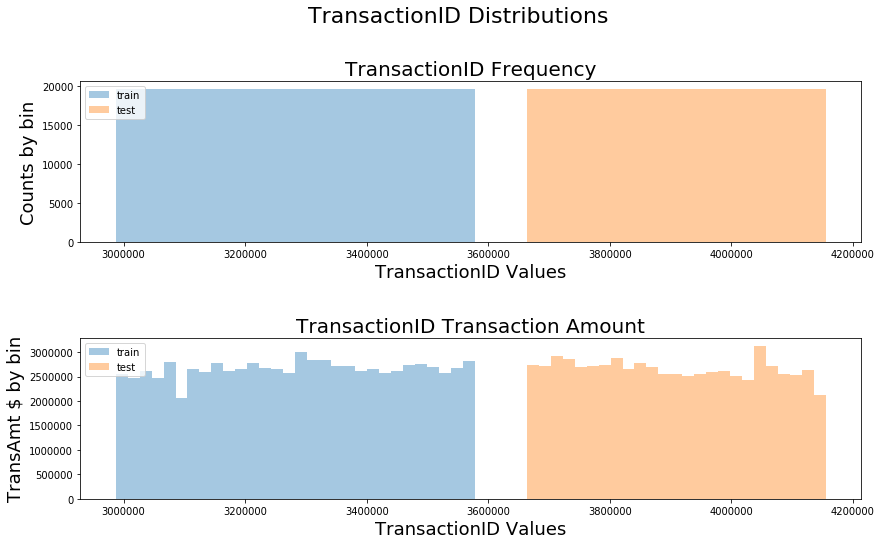

In [2470]:
dist_plot(df, 'TransactionID',df_test = df_test)

- TransactionID is uniformly generated.

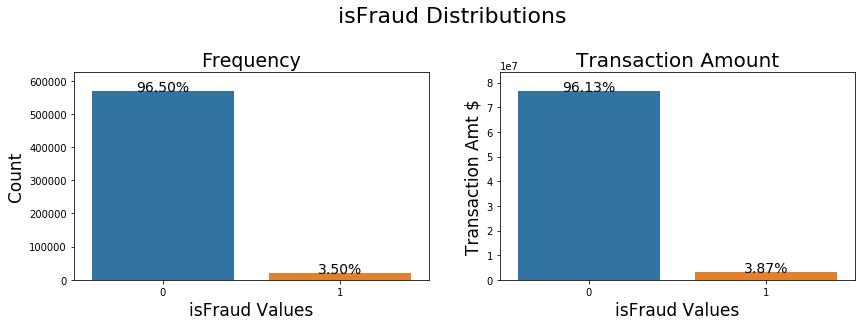

In [2676]:
bar_plot(df, 'isFraud', target_plots=False)

- Fraud data consists only 3.5% in counts, 3.87% in TransAmt
- Very imbalanced

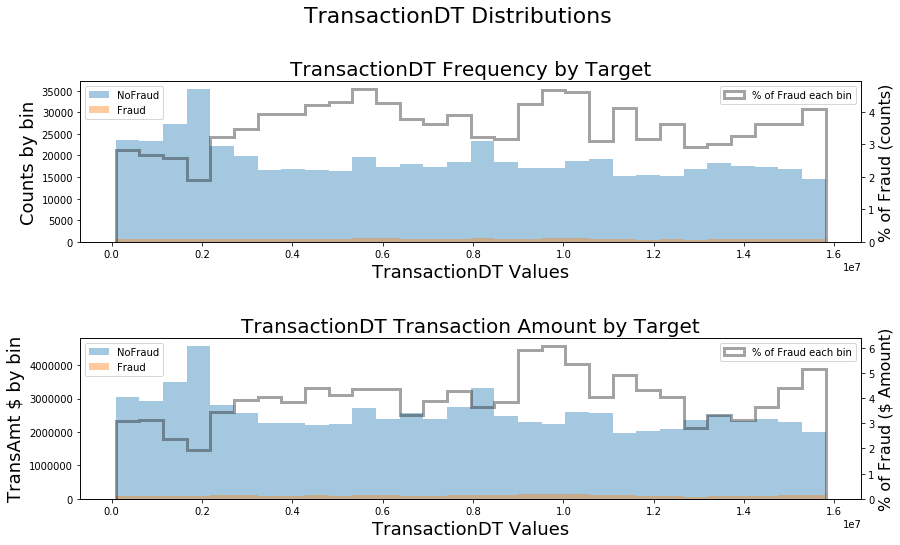

In [2472]:
dist_plot(df, 'TransactionDT')

- % of Fraud shows somewhat periodic behavior.
- We can dig in more to check if % of Fraud is periodic over hours, days, months

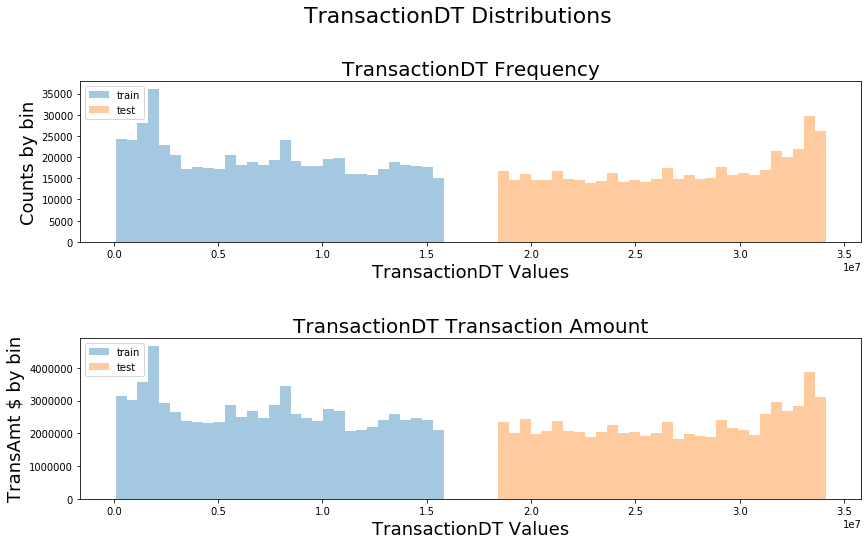

In [2473]:
dist_plot(df, 'TransactionDT',df_test = df_test)

- train and test set are divided by Transaction time. They are apart by about a month

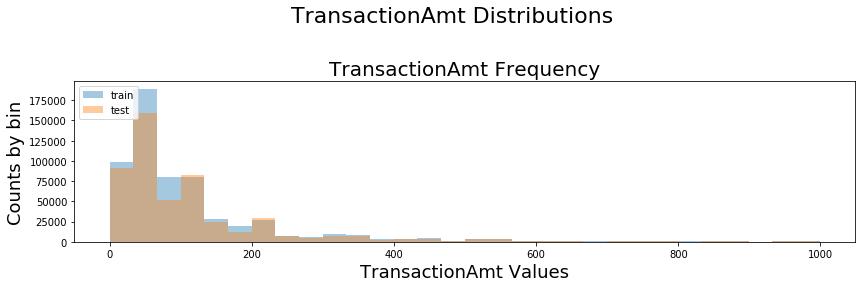

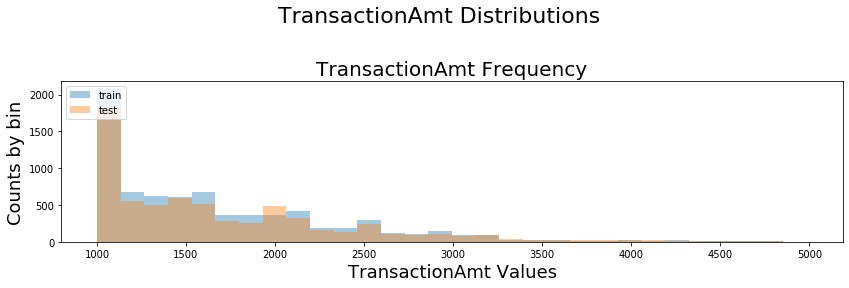

In [2883]:
dist_plot(df[df['TransactionAmt']<1000],'TransactionAmt',df_test = df_test[df_test['TransactionAmt']<1000])
dist_plot(df[(1000<=df['TransactionAmt']) & (df['TransactionAmt']<5000)],'TransactionAmt',\
          df_test = df_test[(1000<=df_test['TransactionAmt']) & (df_test['TransactionAmt']<5000)])

- train has more data but train-TransAmt and test-TransAmt distribution are quite similar

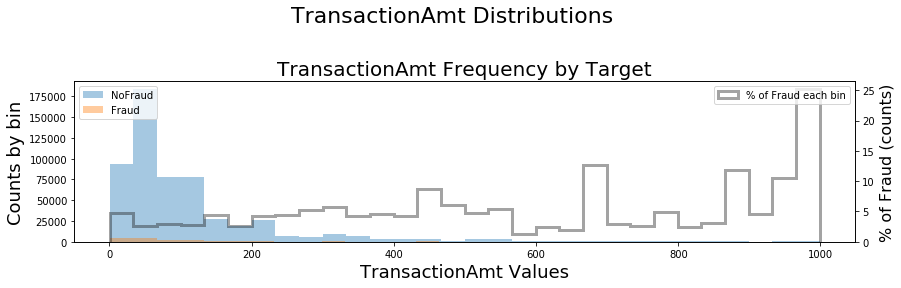

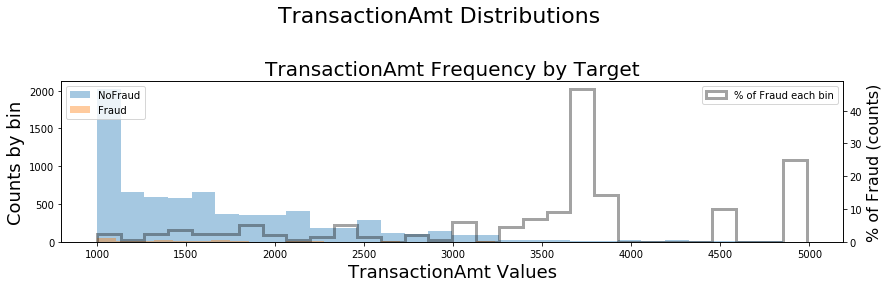

In [2884]:
dist_plot(df[df['TransactionAmt']<1000],'TransactionAmt')
dist_plot(df[(1000<=df['TransactionAmt']) & (df['TransactionAmt']<5000)],'TransactionAmt')
#dist_plot(df[(5000<=df['TransactionAmt']) & (df['TransactionAmt']<10000)],'TransactionAmt')

- High % of Fraud at higher TransAmt.

# ProductCD, card features <a name='card' />

In [2320]:
list(df.columns)[4:10]

Index(['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5'], dtype='object')

In [284]:
summary_table(df[list(df.columns)[4:11]]).transpose()

ProductCD  card1    card2    card3             card4    card5  \
dtypes      object  int32  float32  float32            object  float32   
missing          0      0     8933     1565              1577     4259   
uniques          5  13553      500      114                 4      119   
min              -   1000      100      100                 -      100   
max              -  18396      600      231                 -      237   
top              W   7919      321      150              visa      226   
1-freq      439670  14932    48935   521287            384767   296546   
2nd most         C   9500      111      185        mastercard      224   
2-freq       68519  14162    45191    56346            189217    81513   
3rd most         R  15885      555      106  american express      166   
3-freq       37699  10361    41995     1571              8328    57140   

                    card6  
dtypes             object  
missing              1571  
uniques                 4  
min                     -  
max                     -  
top                 debit  
1-freq             439938  
2nd most           credit  
2-freq             148986  
3rd most  debit or credit  
3-freq                 30

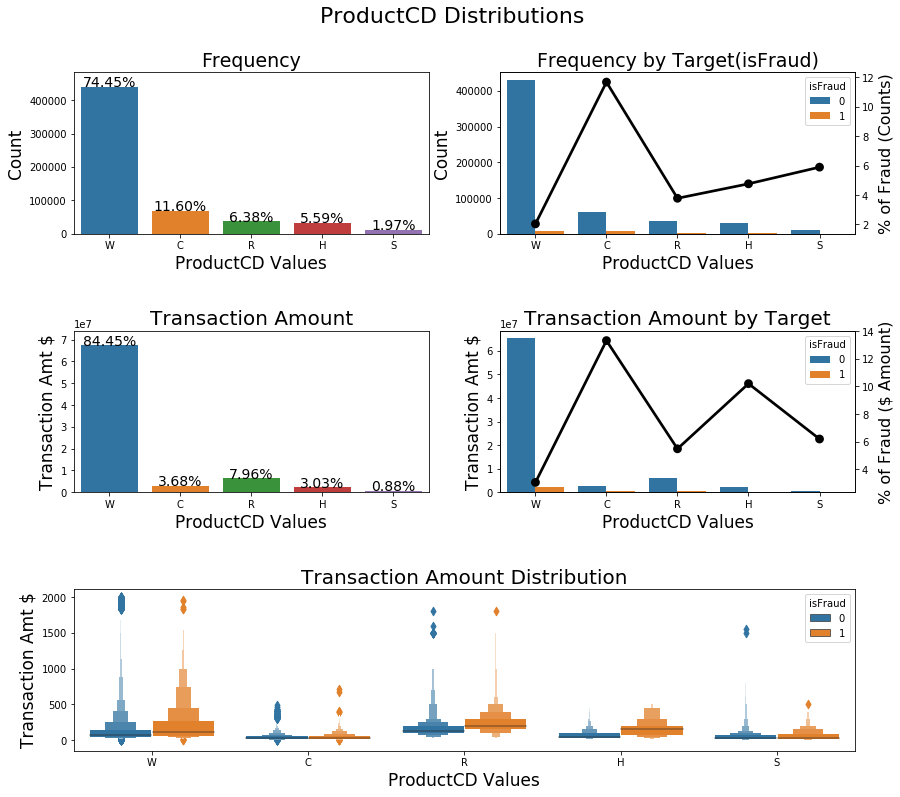

In [2694]:
bar_plot(df,'ProductCD')

- Mostly W.
- % of Fraud high for C
- W, R, H show higher TransAmt in Fraud than Non-Fraud, most noticable for H but H has only a few percents of data. 
- Worth trying (feature)-TransAmt combined feature

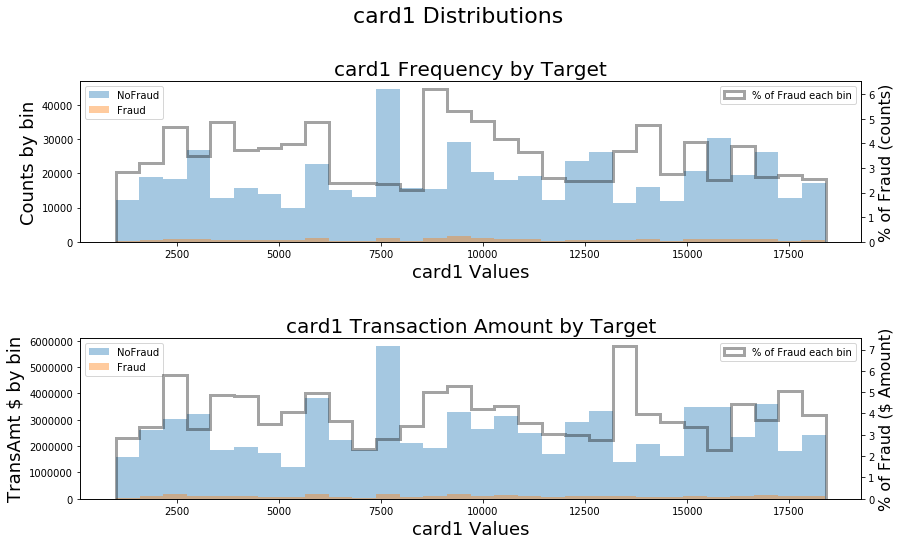

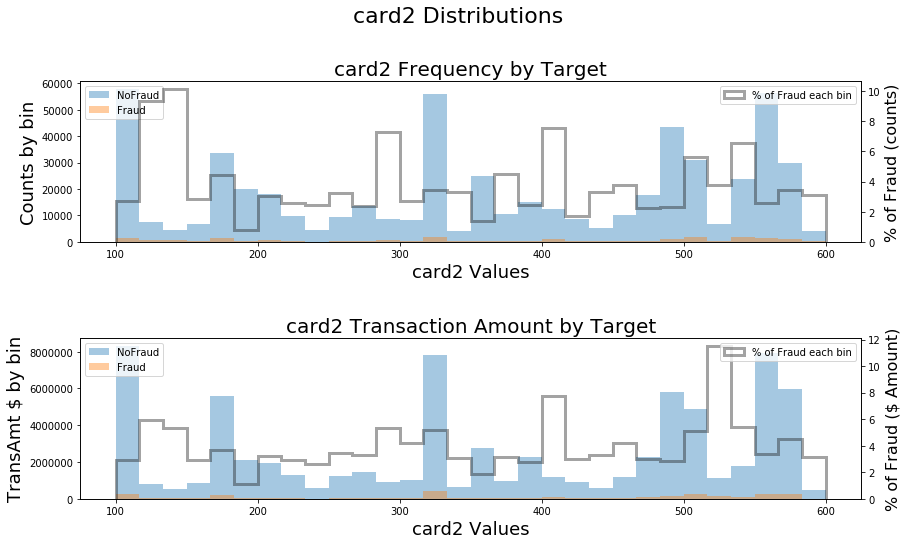

In [2695]:
dist_plot(df, 'card1')
dist_plot(df, 'card2')

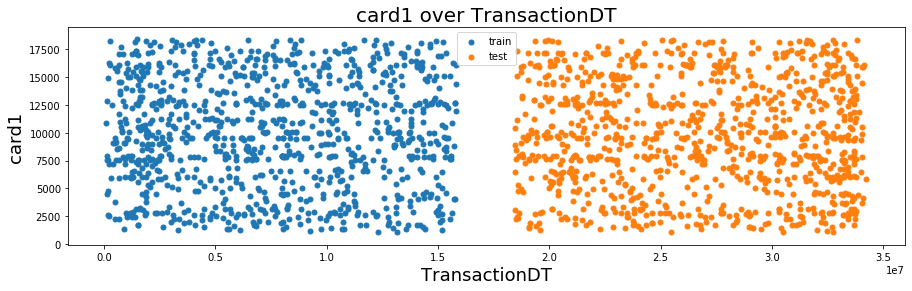

In [36]:
scatter_plot(df.sample(1000), 'card1', df_test=df_test.sample(1000),scatter_size=5)

- card1 % of Fraud varies much over values
- card1 % of Fraud TransAmt shows some variation from % Fraud Counts. 
- Worth trying (feature)-TransAmt combined feature
- card2 % of Fraud varies mostly in bins with small number of data
- card2 % of Fraud TransAmt also consistent with % of Fraud Counts in bins with large number of data.

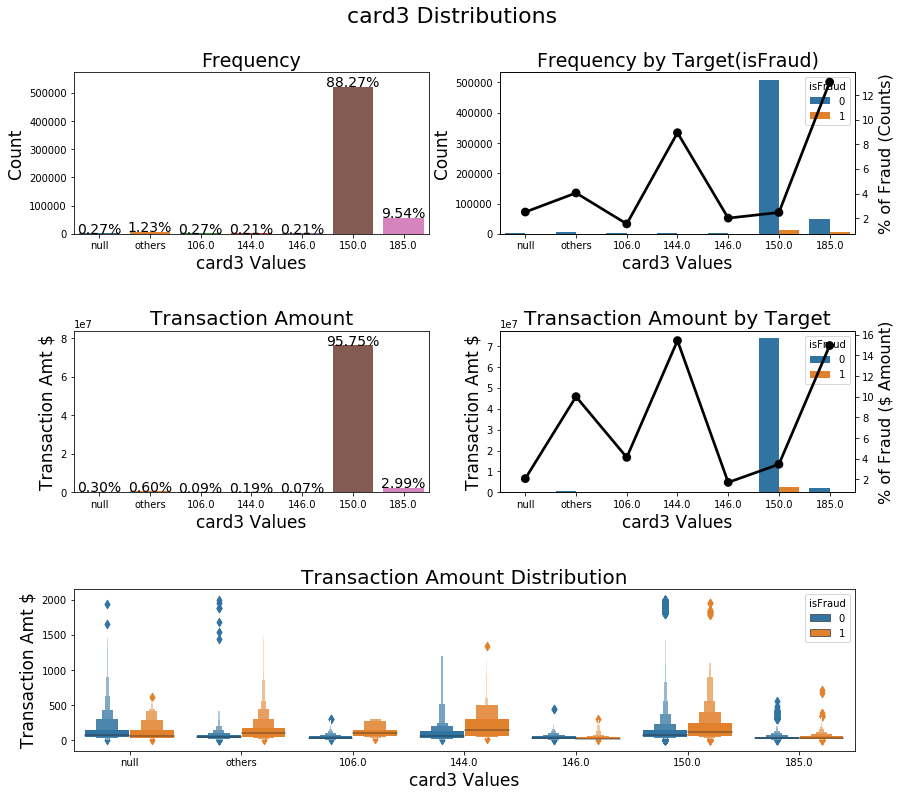

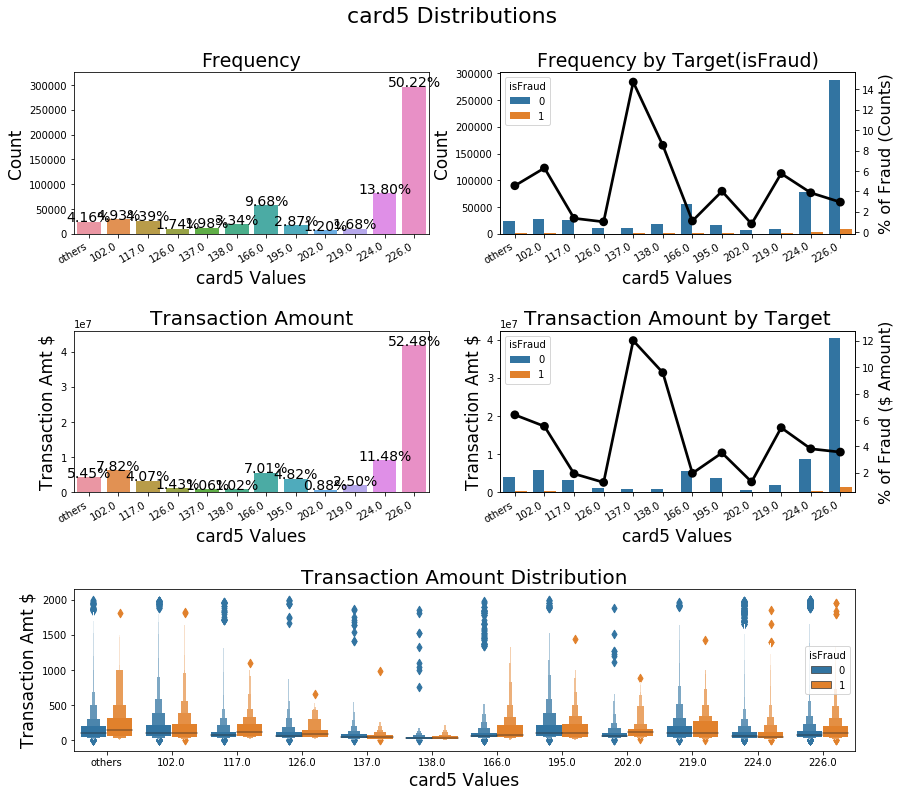

In [105]:
bar_plot(df, 'card3',others_threshold=1000,sorted_plot_order=True)
bar_plot(df, 'card5', xtick_rotate=True,sorted_plot_order=True)

- card3 most data are 150 with a little higher mean-TransAmt in Fraud.
- card3 the next common value 185 has much higher %Fraud in Amt than %Fraud in Counts. 
- Worth trying (feature)-TransAmt combined feature
- card5 more than half are 226. No noticable difference between Fraud and NoFraud

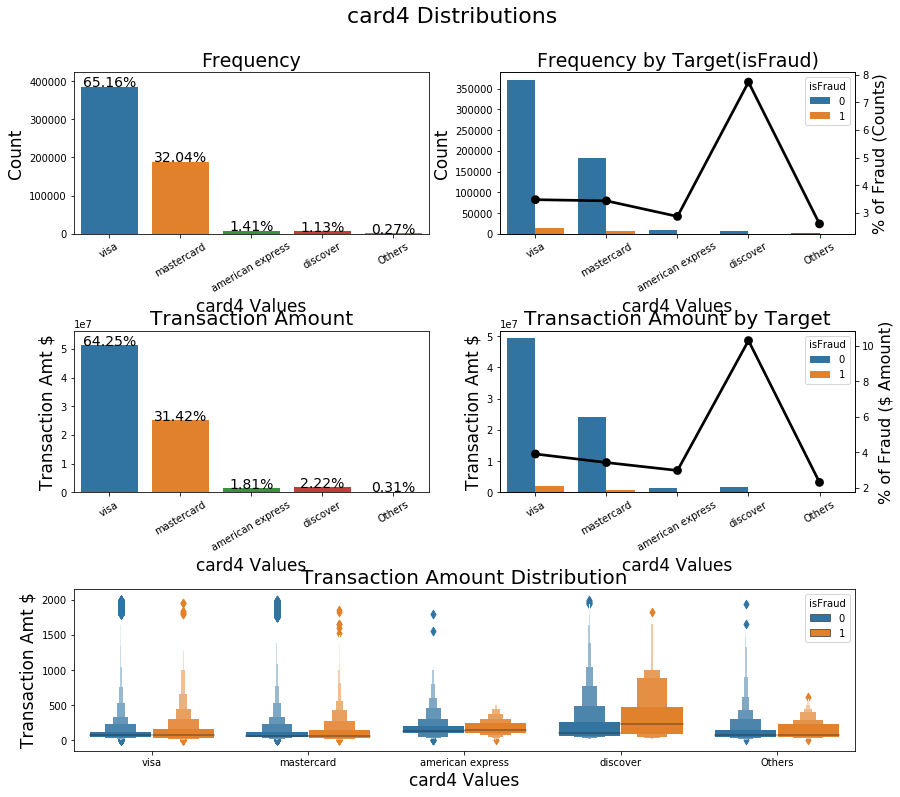

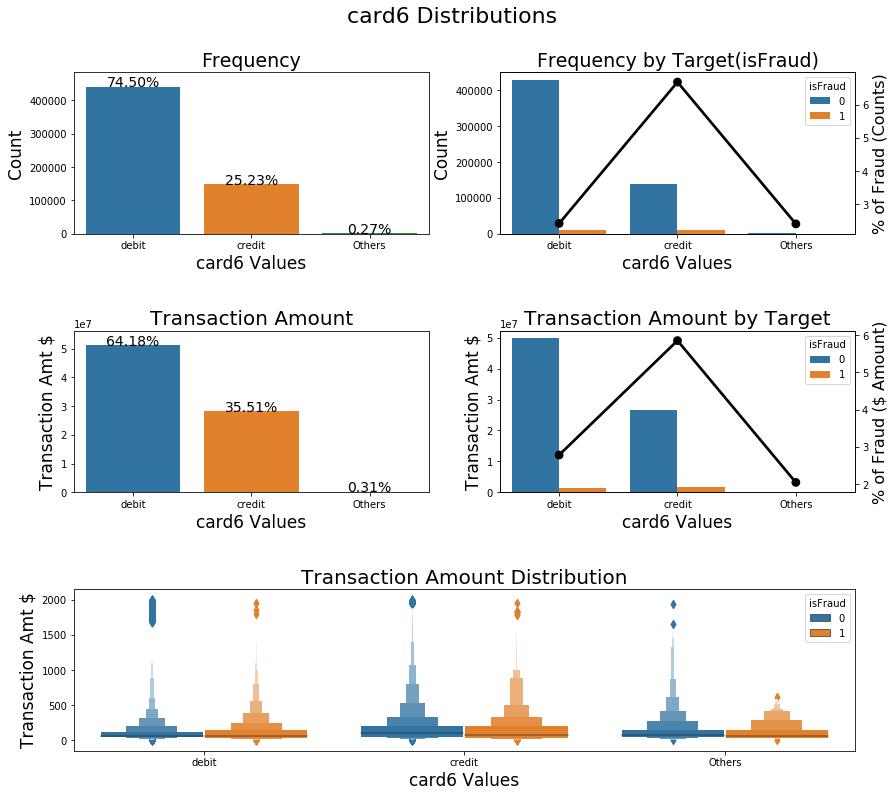

In [2801]:
bar_plot(df, 'card4', xtick_rotate=True)
bar_plot(df, 'card6')

- card4 visa and mastercard consist of ~97% of data.
- card4 discover (although only 1.13% of data) shows big disparity in Fraud-TransAmt and NoFraud-TransAmt.
- card4_discover-TransAmt would be good feature.
- card6 credit has in average lower TransAmt in Fraud.
- card6 debit has higher %Fraud in TransAmt than Counts.

<a id='addr' />

# addr features <a name='addr' />

In [2738]:
list(df.columns)[11:17]

['addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain']

In [2759]:
summary_table(df[list(df.columns)[11:17]]).transpose()

addr1    addr2    dist1    dist2 P_emaildomain R_emaildomain
dtypes   float32  float32  float32  float32        object        object
missing    65706    65706   352271   552913         94456        453249
uniques      332       74     2412     1699            59            60
min          100       10        0        0           nan           nan
max          540      102    10288    11624           nan           nan
top          299       87        0        7     gmail.com     gmail.com
freq       46335   520481    19824     5687        228355         57147

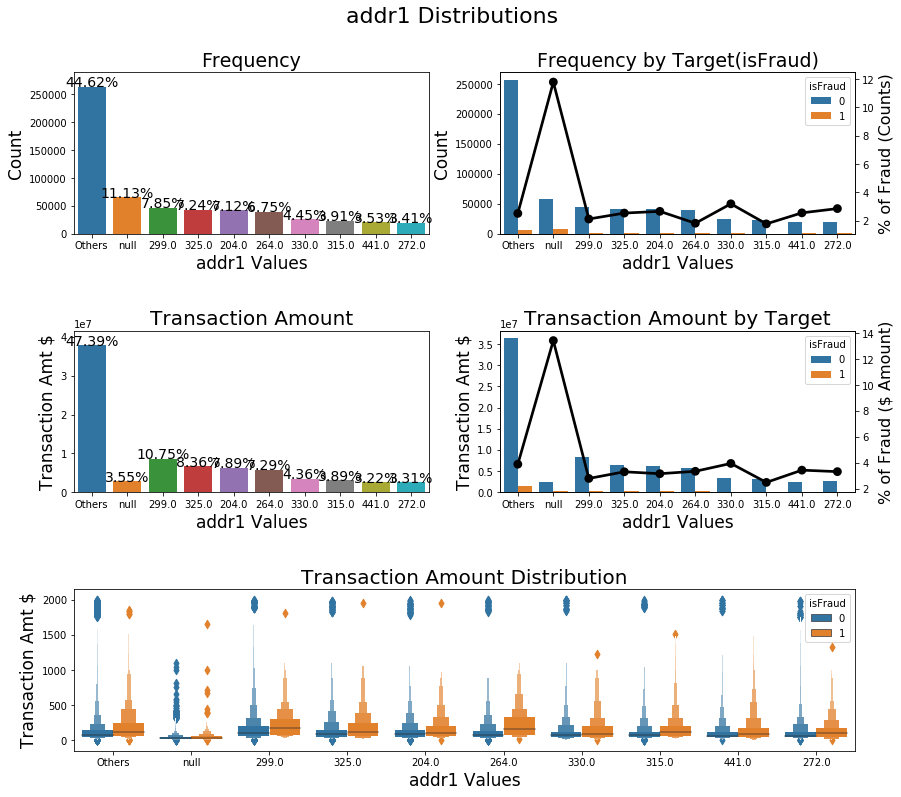

In [2785]:
bar_plot(df, 'addr1', others_threshold=20000)

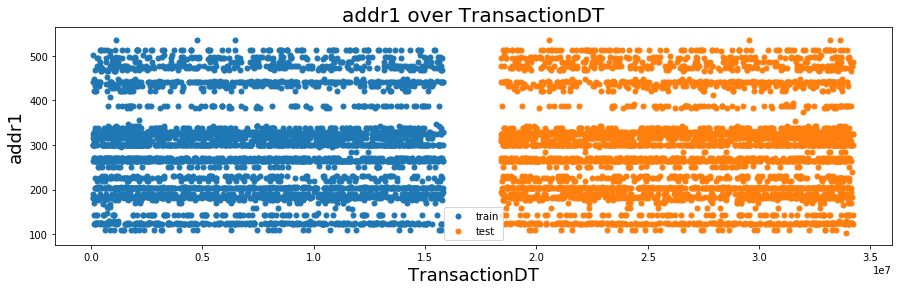

In [38]:
scatter_plot(df.sample(5000), 'addr1', df_test=df_test.sample(5000),scatter_size=5)

- 299 and 264 has higher TransAmt in Fraud
- null data has comparably higher %Fraud in TransAmt than %Fraud in Counts
- Worth trying (feature)-TransAmt combined feature

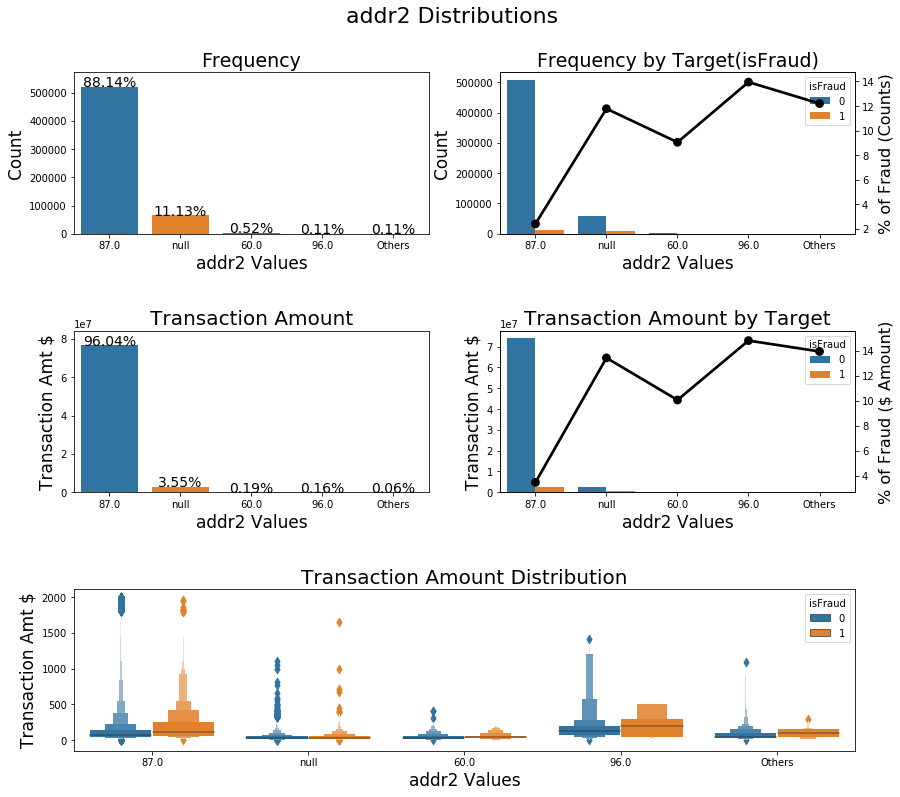

In [2778]:
bar_plot(df, 'addr2', others_threshold=500)

- <1% data other than 87 and null
- 87 shows slightly higher TransAmt in average in Fraud than NoFraud
- Worth trying (feature)-TransAmt combined feature

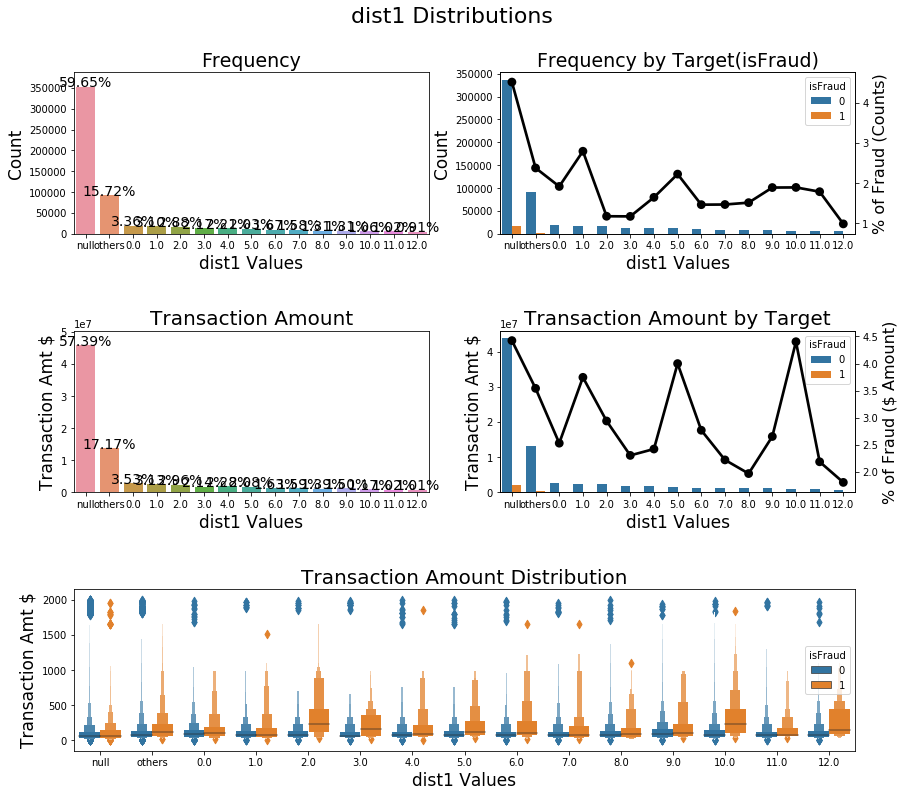

In [100]:
bar_plot(df,'dist1', others_threshold=5000,sorted_plot_order=True)

- More than half are null.
- 2, 3, 5 show much higher TransAmt in avg in Fraud than in NoFraud.
- Worth trying (feature)-TransAmt combined feature

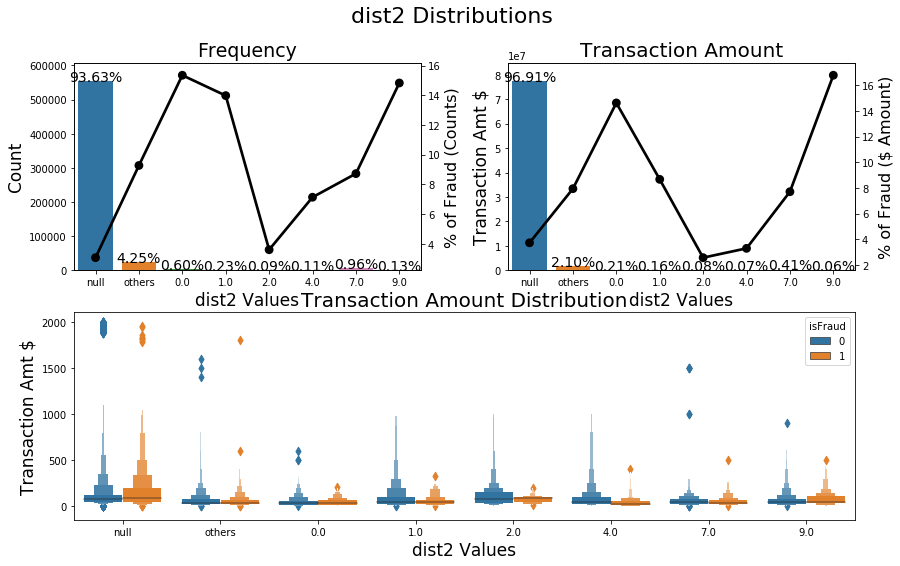

In [663]:
bar_plot(df,'dist2',others_threshold=500, reduced=True,sorted_plot_order=True)

- Mostly null

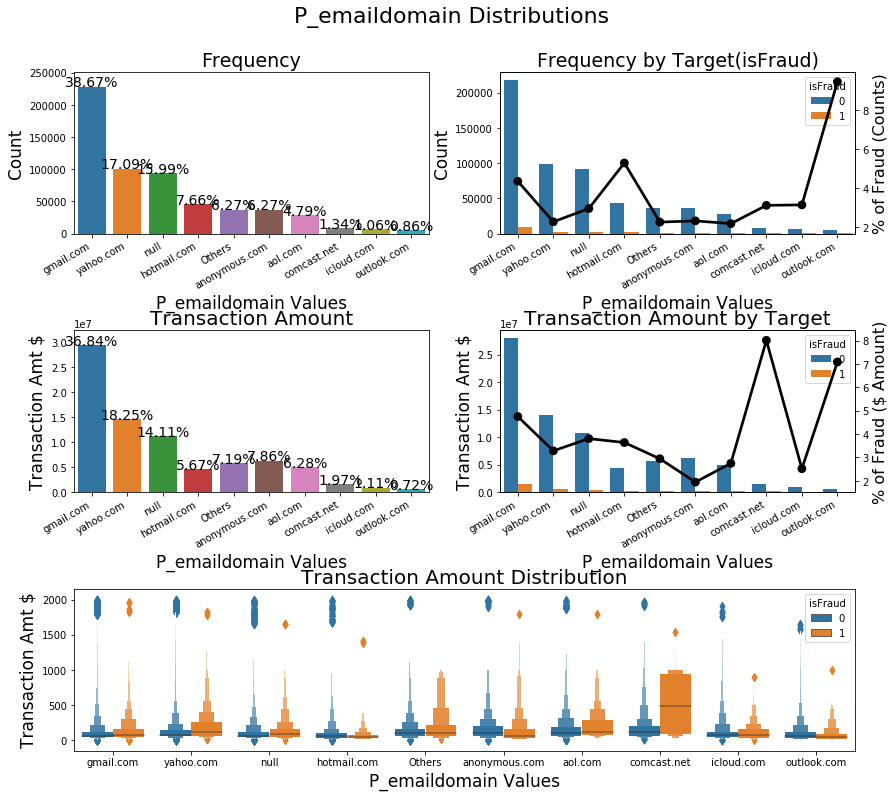

In [2804]:
bar_plot(df, 'P_emaildomain', xtick_rotate=True)

- comcast.net show significant disparity between Fraud-TransAmt and NoFraud-TransAmt
- yahoo.com and null show higher Fraud-TransAmt than NoFraud-TransAmt too
- hotmail.com and anomymous.com, on the other hand, show lower Fraud-TransAmt than NoFraud-TransAmt
- Worth trying (feature)-TransAmt combined feature

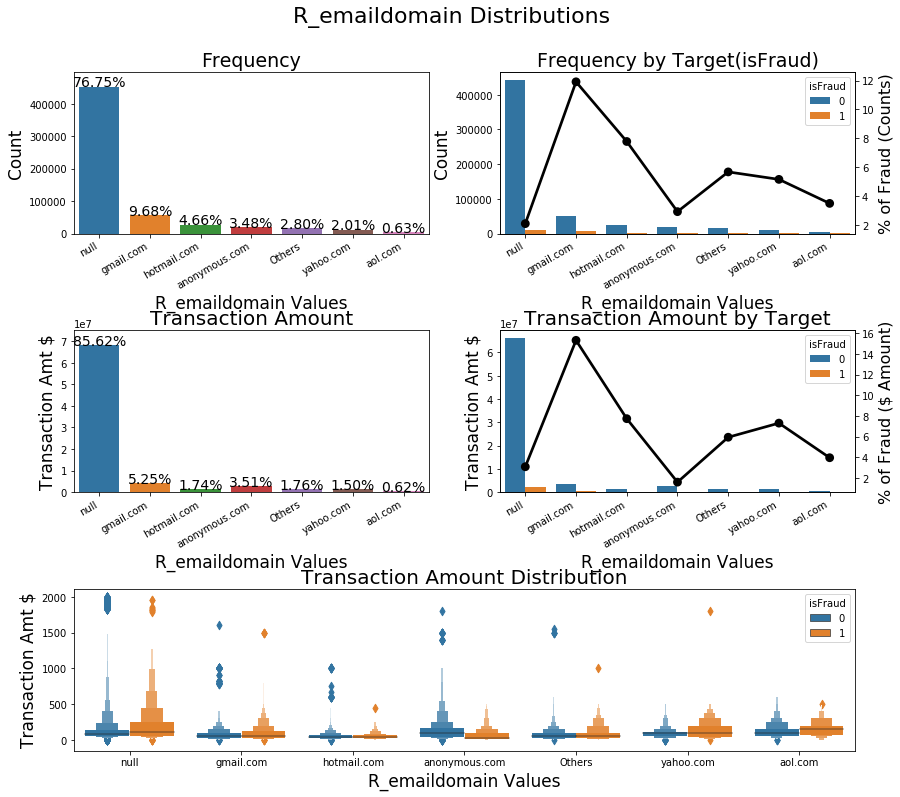

In [2829]:
bar_plot(df, 'R_emaildomain', others_threshold=3000, xtick_rotate=True)

- null has higher Fraud-TransAmt than NoFraud-TransAmt
- anonymous.com has lower Fraud-TransAmt then NoFraud-TransAmt

# C features <a name='C' />

In [242]:
summary_table(df[list(df.columns)[17:31]]).transpose()

C1       C2       C3       C4       C5       C6       C7  \
dtypes    float32  float32  float32  float32  float32  float32  float32   
missing         0        0        0        0        0        0        0   
uniques      1657     1216       27     1260      319     1328     1103   
min             0        0        0        0        0        0        0   
max          4685     5691       26     2253      349     2253     2255   
top             1        1        0        0        0        1        0   
1-freq     316791   316261   588111   451883   372435   341552   523142   
2nd most        2        2        1        1        1        2        1   
2-freq     105071   103948     2137   111817   122883    86103    51966   
3rd most        3        3        2        2        2        0        2   
3-freq      51315    51770      180    12994    34776    49066     7314   

               C8       C9      C10      C11      C12      C13      C14  
dtypes    float32  float32  float32  float32  float32  float32  float32  
missing         0        0        0        0        0        0        0  
uniques      1253      205     1231     1476     1199     1597     1108  
min             0        0        0        0        0        0        0  
max          3331      210     3257     3188     3188     2918     1429  
top             0        1        0        1        0        1        1  
1-freq     447667   228938   453442   389692   489199   199337   320189  
2nd most        1        0        1        2        1        2        2  
2-freq     104994   183795   100231    89677    76661    57616    93843  
3rd most        2        2        2        3        2        0        3  
3-freq      15927    77829    14938    34463    12242    35460    44471

In [91]:
summary_table(df_test[list(df.columns)[17:31]])

C1       C2       C3       C4       C5       C6       C7  \
dtypes   float32  float32  float32  float32  float32  float32  float32   
missing        3        3        3        3        3        3        3   
uniques     1174     1123       31      728      353      834      518   
min            0        0        0        0        0        0        0   
max         2950     3275       31     1601      376     1601     1621   
top            1        1        0        0        0        1        0   
freq      269951   265435   493779   371571   334573   289685   438095   

              C8       C9      C10      C11      C12      C13      C14  
dtypes   float32  float32  float32  float32  float32  float32  float32  
missing        3        3        3        3        3     4748        3  
uniques      442      354      456      937      663     1069      569  
min            0        0        0        0        0        0        0  
max         1005      572      881     2234     2234     1562      797  
top            0        1        0        1        0        1        1  
freq      368637   191416   370978   342100   366881   168280   278331

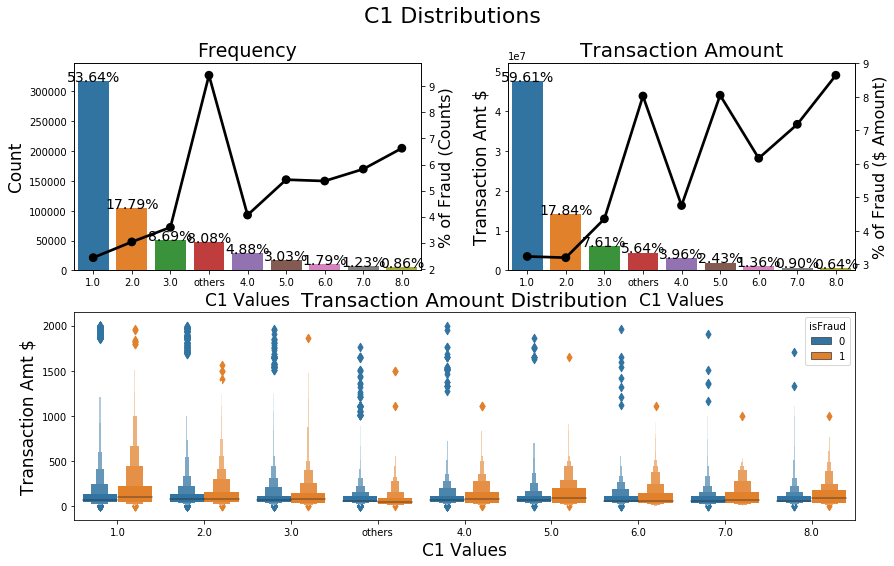

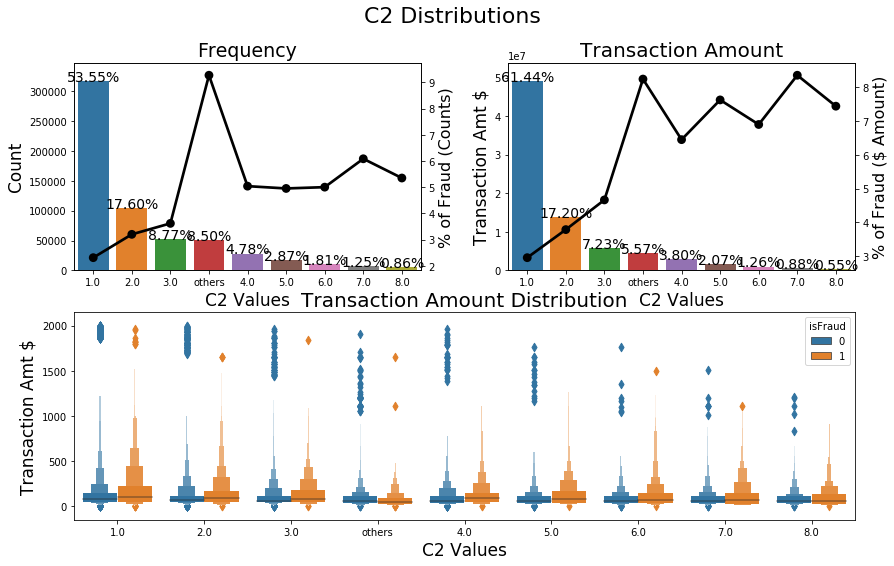

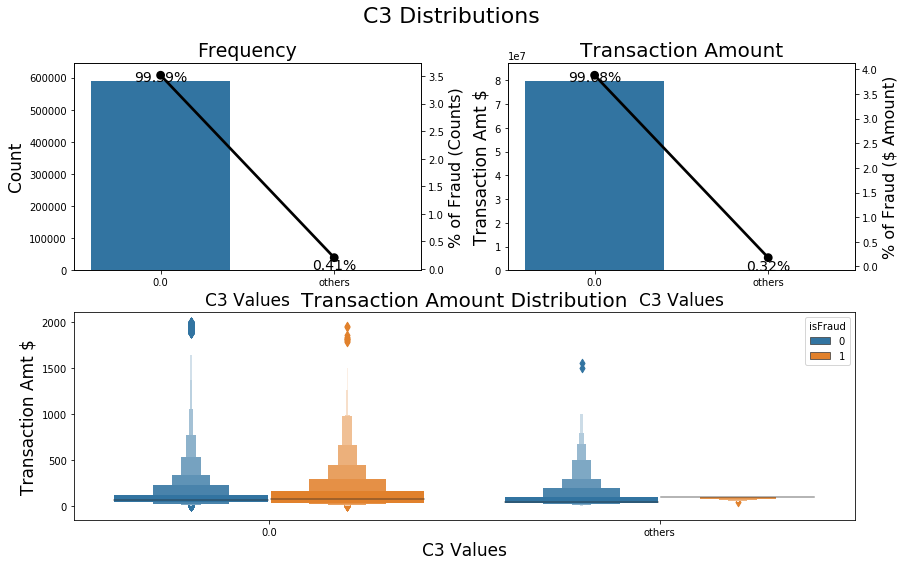

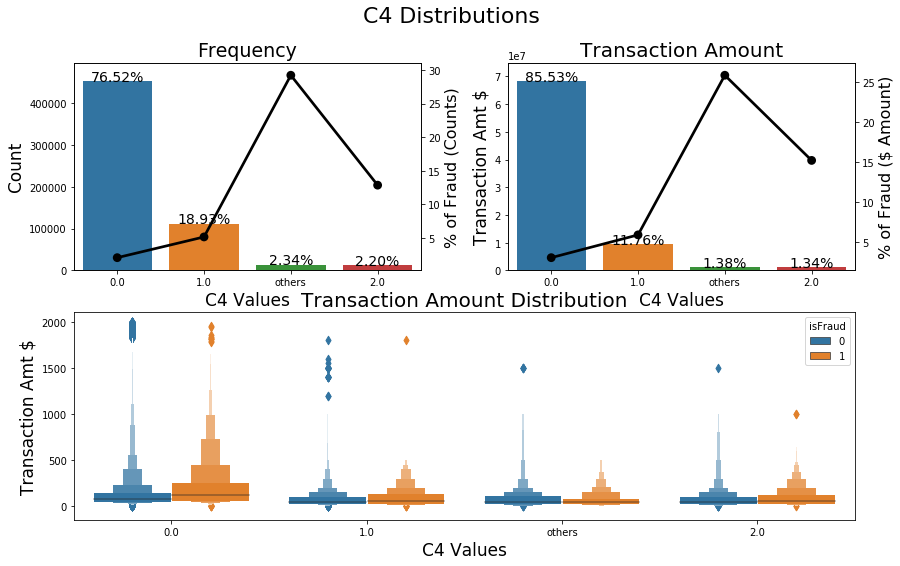

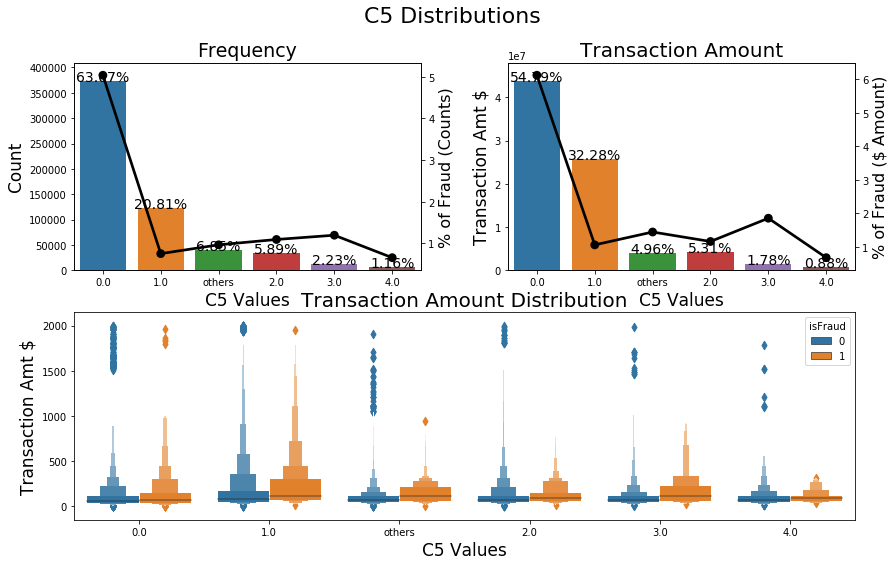

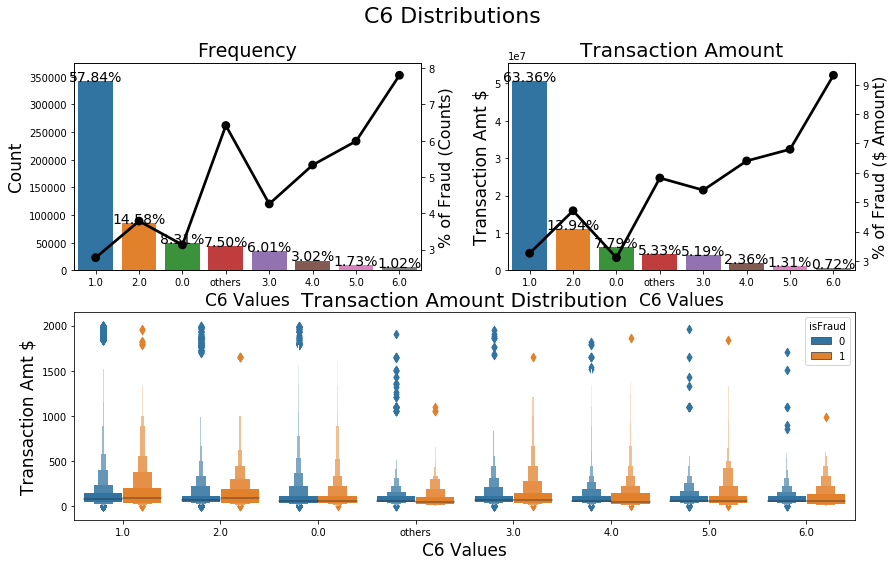

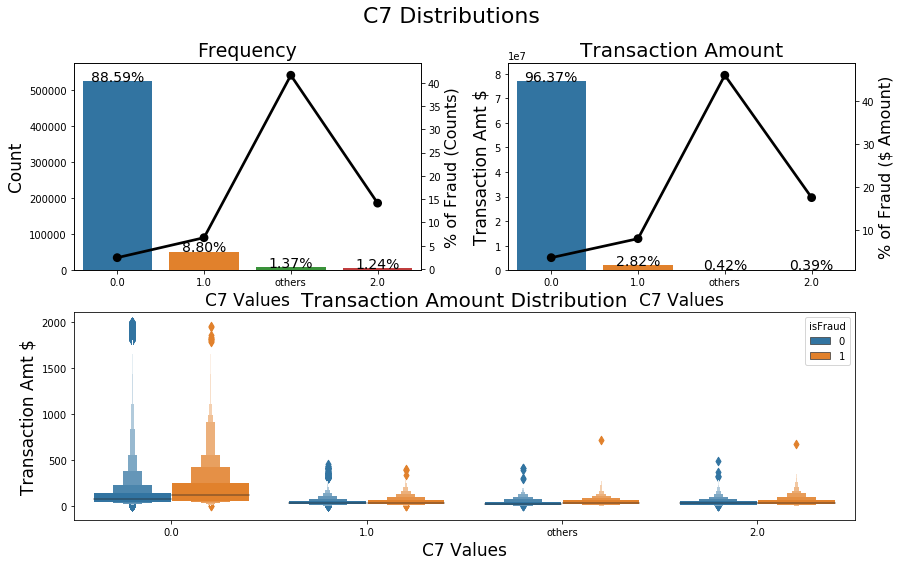

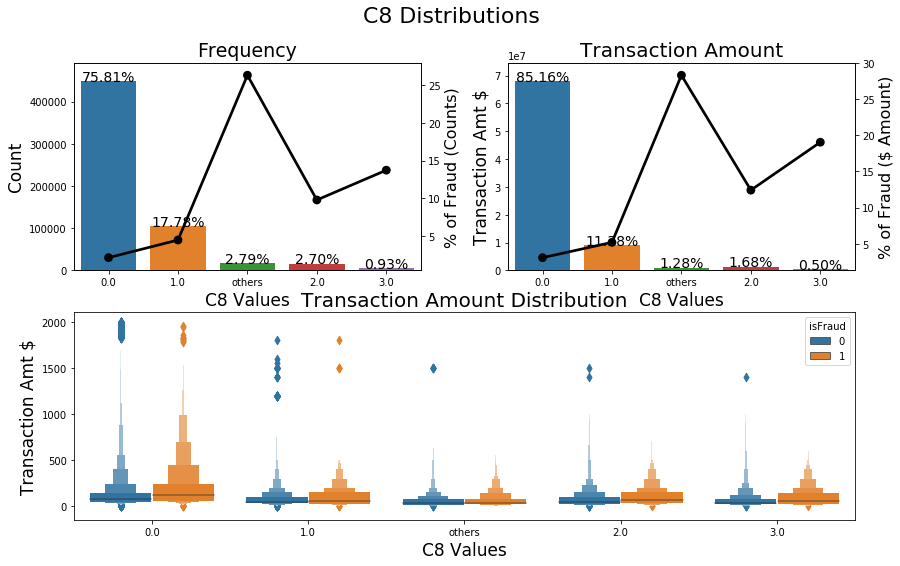

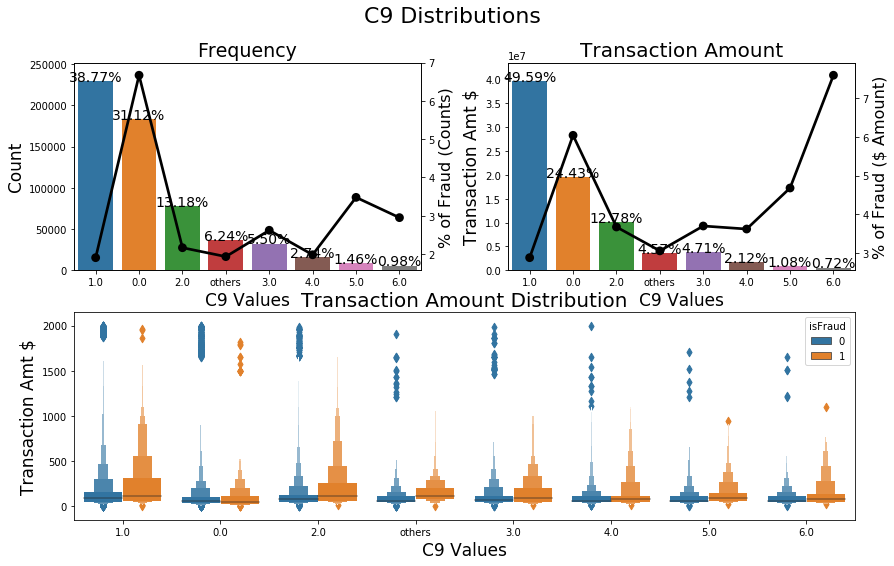

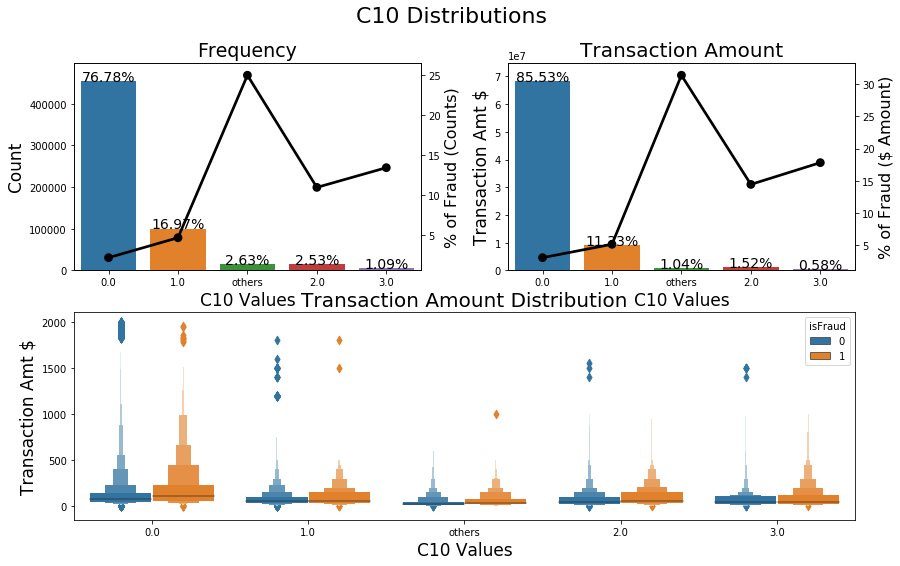

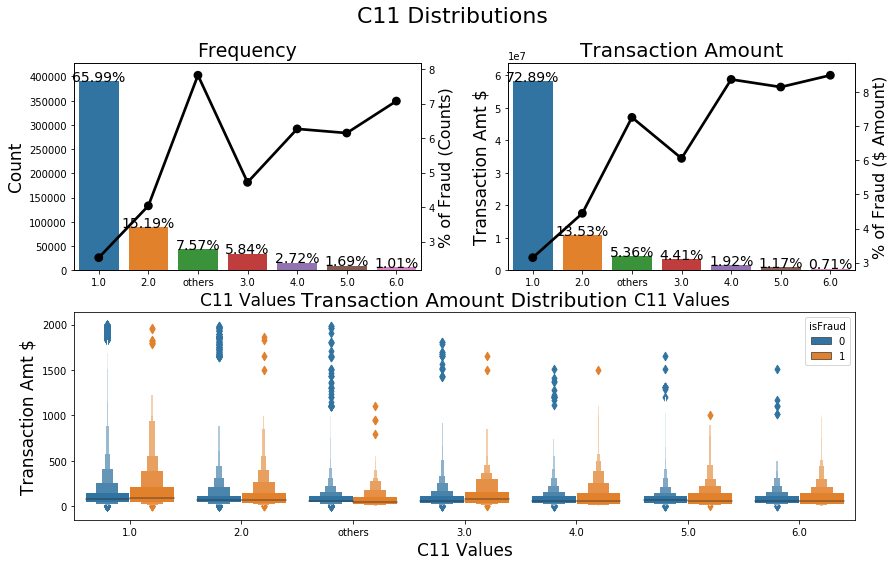

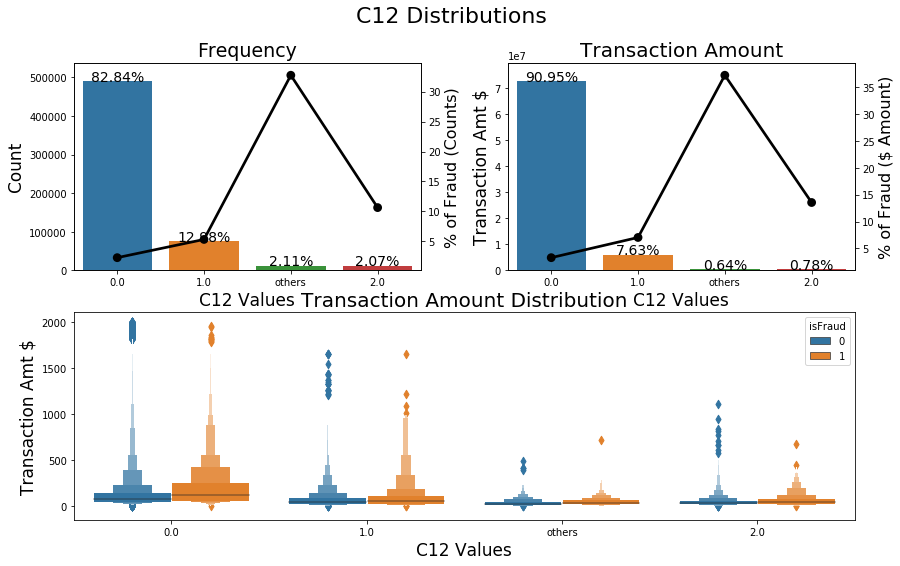

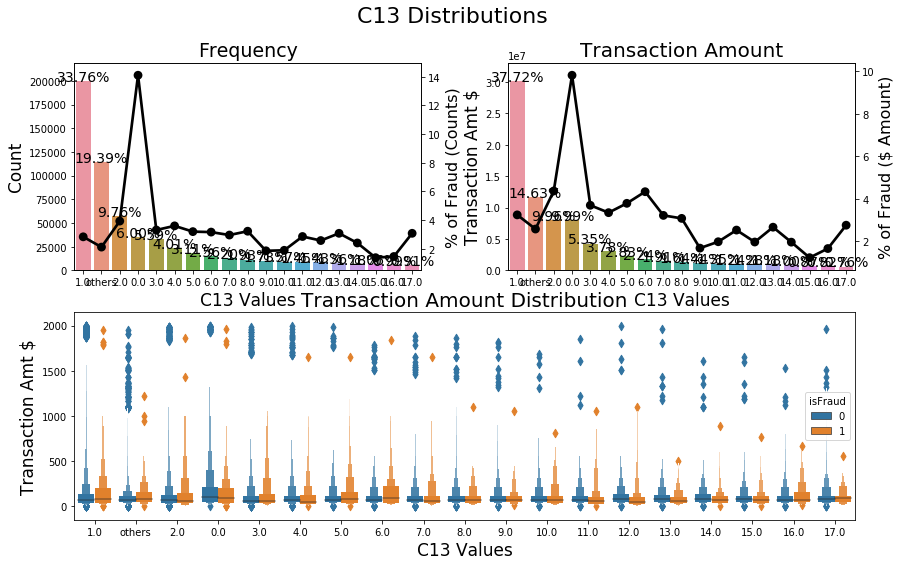

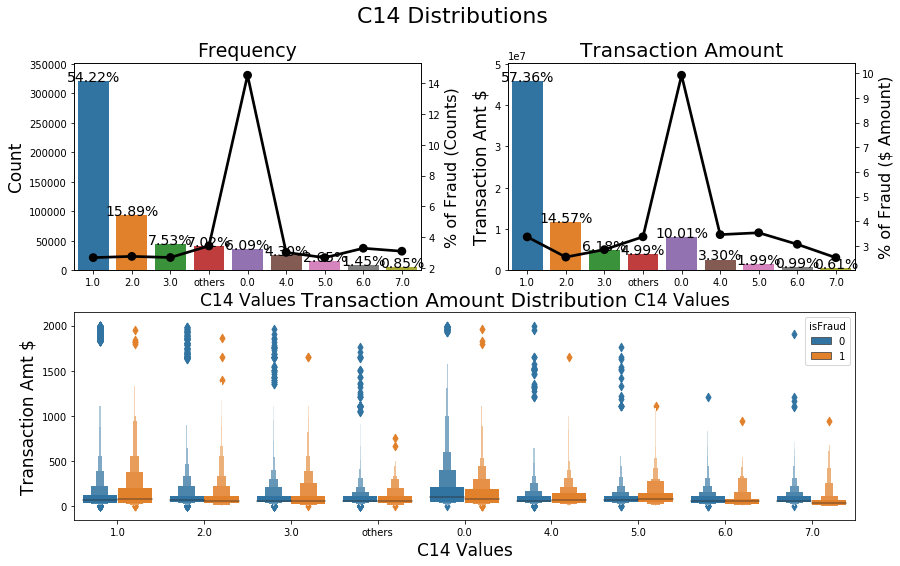

In [664]:
for col in list(df.columns)[17:31]:
    bar_plot(df,col, others_threshold=5000 ,reduced=True)

- C1 5 (3% of total) has significantly higher %Fraud in TransAmt than %Fraud in Counts
- C1 1 (54% of total) 7, 8 (2% tally) have higher %Fraud in TransAmt than %Fraud in Counts
- C2 generally show higher Fraud-TransAmt than NoFraud-TransAmt
- C3 most data are 0 (>99.5%), nothing to tell
- C4 slight difference between %Fraud in Counts and %Fraud in TransAmt
- C5 1, 3 show higher %Fraud in TransAmt than %Fraud in Counts
- C6 no noticable difference except values with small number of data
- C7 no noticable difference but 0 has a little more Fraud-TransAmt than NoFraud-TransAmt without outliers
- C8 0, 2, 3 have slightly higher Fraud-TransAmt than NoFraud-TransAmt
- C9 noticable difference between %Fraud in Counts and %Fraud in TransAmt
- C10 no noticable difference but 0 has a little more Fraud-TransAmt than NoFraud-TransAmt without outliers
- C11 slight difference between %Fraud in Counts and %Fraud in TransAmt
- C12 0 has a little more Fraud-TransAmt than NoFraud-TransAmt without outliers
- C13 can see slight differences
- C14 0, 1, 7 have noticable differences b/w %Fraud in TransAmt and %Fraud in Counts

# D features <a name='D' />

In [188]:
summary_table(df[list(df.columns)[31:46]], target_df = df['isFraud']).transpose()

D1       D2       D3       D4       D5       D6       D7  \
dtypes     float32  float32  float32  float32  float32  float32  float32   
missing       1269   280797   262878   168922   309841   517353   551623   
uniques        641      641      649      808      688      829      597   
min              0        0        0     -122        0      -83        0   
max            640      640      819      869      819      873      843   
top              0        0        0        0        0        0        0   
1-freq      280130    15124    73094   166571    65377    45782    21135   
2nd most         1        1        1        1        1        1        1   
2-freq        8634     6654    21258     5315    15282     1588     1717   
3rd most         2        2        2        2        2      256        2   
3-freq        4969     4454    13789     3385    10244      895      998   
Frd ratio    0.035    0.025    0.029    0.035    0.039    0.105    0.149   

                 D8        D9      D10      D11      D12      D13      D14  \
dtypes      float32   float32  float32  float32  float32  float32  float32   
missing      515614    515614    76022   279287   525823   528588   528353   
uniques       12353        24      818      676      635      577      802   
min               0         0        0      -53      -83        0     -193   
max         1707.79  0.958333      876      670      648      847      878   
top        0.791666  0.791666        0        0        0        0        0   
1-freq         1351      5388   221930   112281    42756    48840    45266   
2nd most   0.833333  0.833333        1        1        1        1        1   
2-freq         1327      5273     5186     3165     1526     1097     1105   
3rd most      0.875      0.75        2        2        2       26      256   
3-freq         1304      5147     3482     2020      818      891      658   
Frd ratio     0.104     0.104    0.033     0.02    0.117     0.11    0.116   

               D15  
dtypes     float32  
missing      89113  
uniques        859  
min            -83  
max            879  
top              0  
1-freq      174246  
2nd most         1  
2-freq        5936  
3rd most         2  
3-freq        3691  
Frd ratio    0.033

In [65]:
summary_table(df_test[list(df.columns)[31:46]]).transpose()

D1       D2       D3       D4       D5       D6       D7  \
dtypes    float32  float32  float32  float32  float32  float32  float32   
missing      6031   234769   203142    76851   224375   381908   446558   
uniques       642      642      887     1056      961     1072      904   
min             0        0        0        0        0        0        0   
max           641      641     1076     1091     1088     1091     1088   
top             0        0        0        0        0        0        0   
1-freq     227724    11944    73232   178278    73887    83120    31939   
2nd most        1        1        1        1        1        1        1   
2-freq       8253     6467    20276     5750    15642     2475     2868   
3rd most        2        2        2        2        2        2        2   
3-freq       5005     4445    13103     3502    10188     1482     1850   

                D8        D9      D10      D11      D12      D13      D14  \
dtypes     float32   float32  float32  float32  float32  float32  float32   
missing     432353    432353    12545   176518   437437   383307   391497   
uniques      13244        24     1075      880      866      805     1031   
min              0         0        0        0        0        0        0   
max        2029.58  0.958333     1091      883      879     1066     1085   
top          0.875  0.791666        0        0        0        0        0   
1-freq        1299      5111   227999    93125    40855   101387    89500   
2nd most  0.833333  0.708333        1        1        1        1        1   
2-freq        1282      5106     4298     3812     2043     2103     1744   
3rd most  0.791666      0.75        2        2        2        2        2   
3-freq        1263      5033     2782     2334     1272     1294      740   

              D15  
dtypes    float32  
missing     12069  
uniques      1078  
min             0  
max          1091  
top             0  
1-freq     183720  
2nd most        1  
2-freq       6202  
3rd most        2  
3-freq       3793

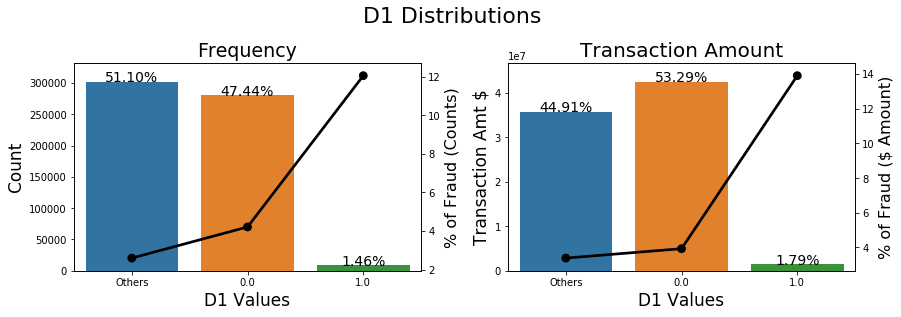

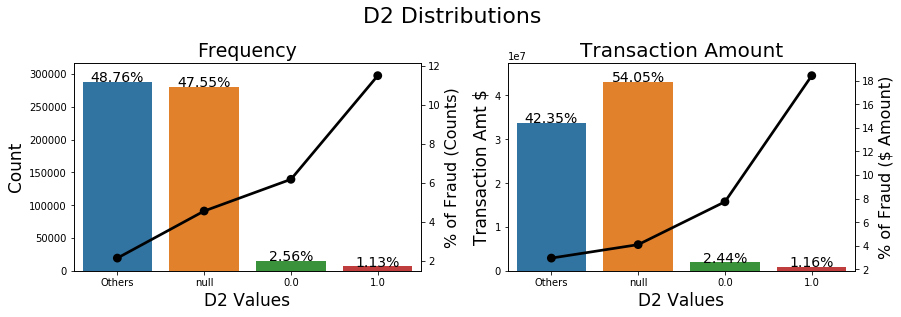

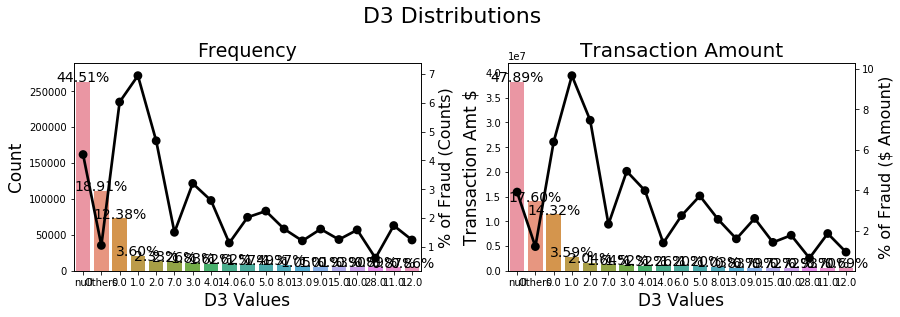

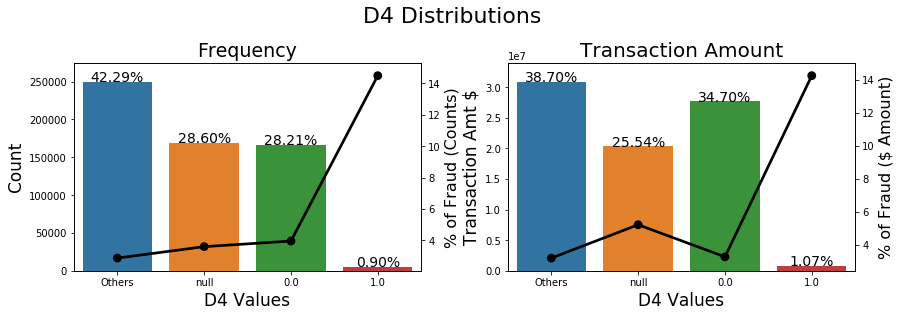

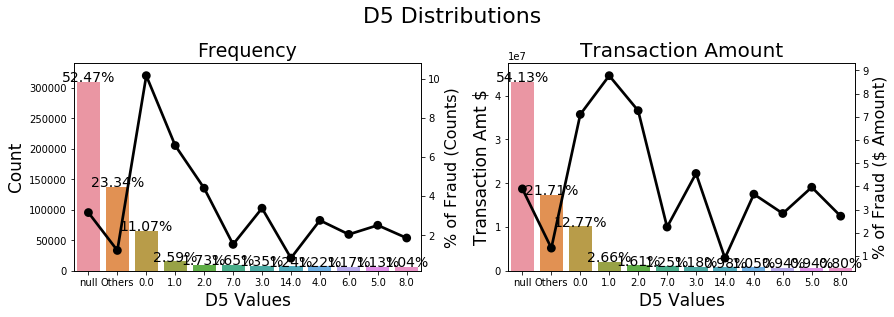

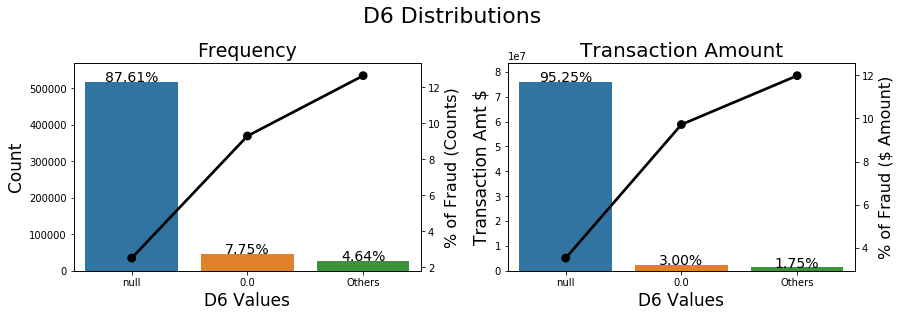

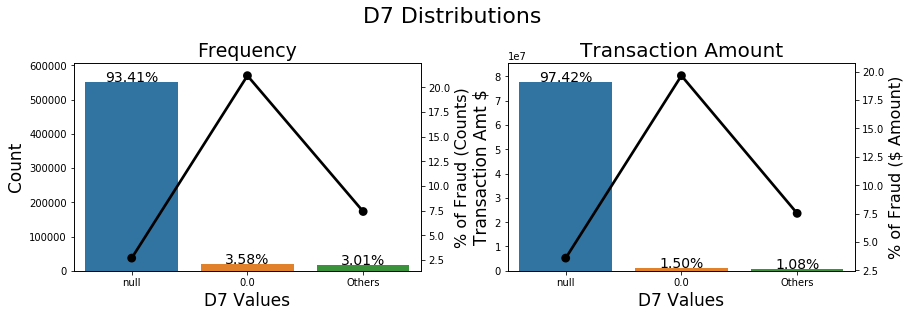

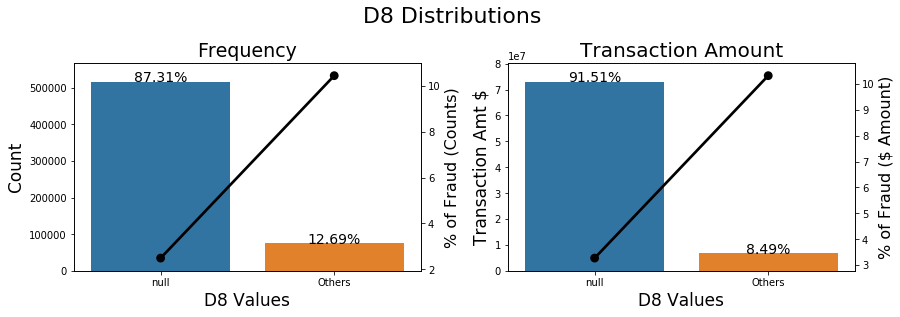

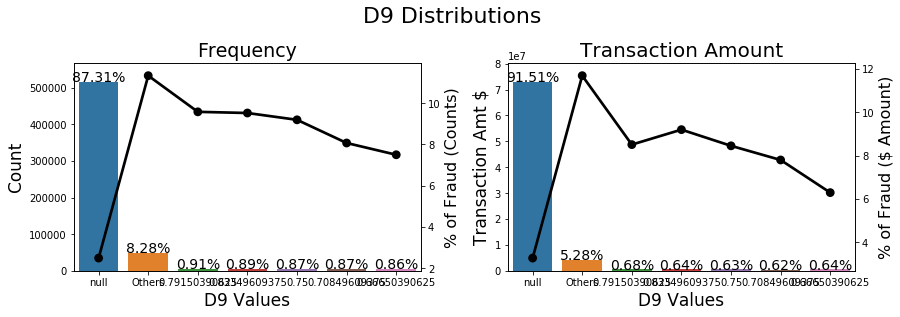

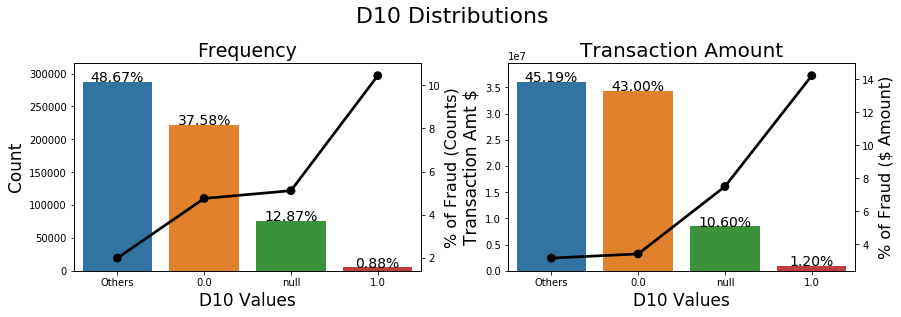

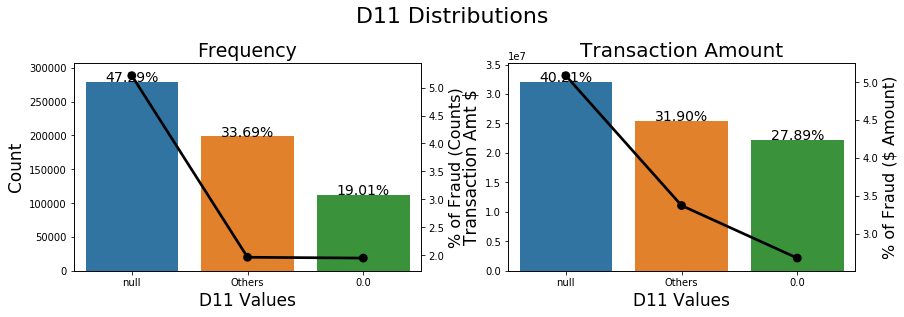

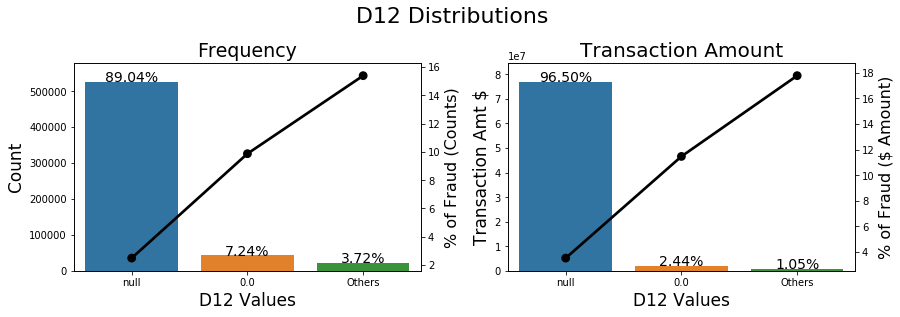

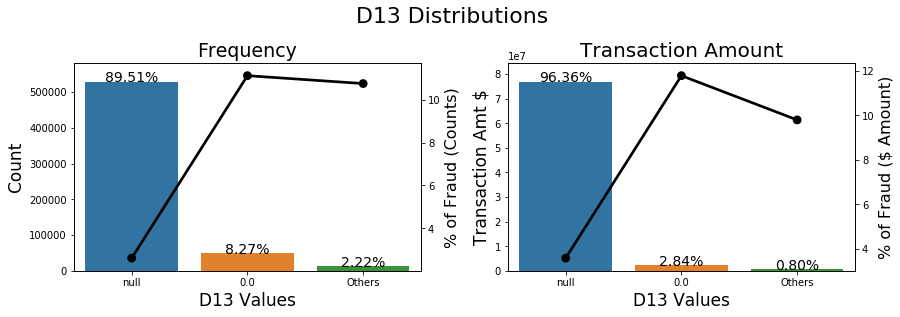

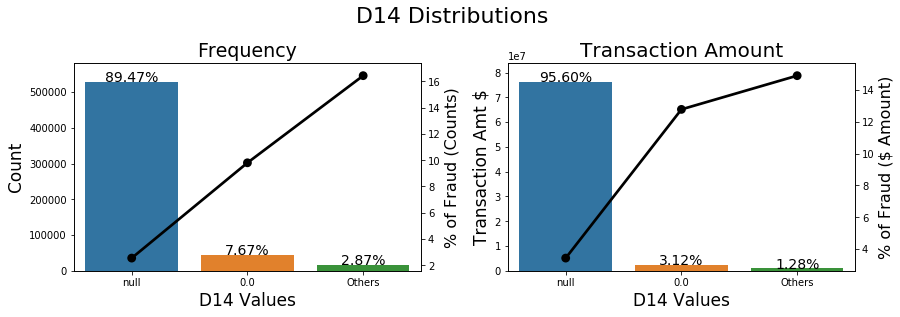

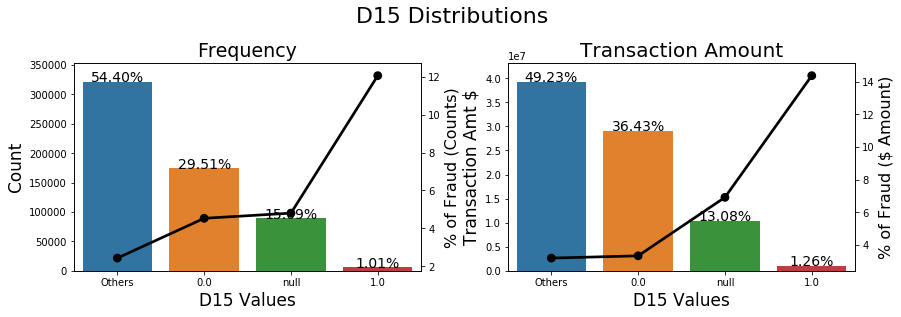

In [2940]:
for col in list(df.columns)[31:46]:
    bar_plot(df,col, others_threshold=5000 ,reduced=True)

- So many null data
- D1 D3 D5 D9 D10 D11 D13 D14 D15 show differences b/w %Fraud in TransAmt and %Fraud in Counts in values other than null data

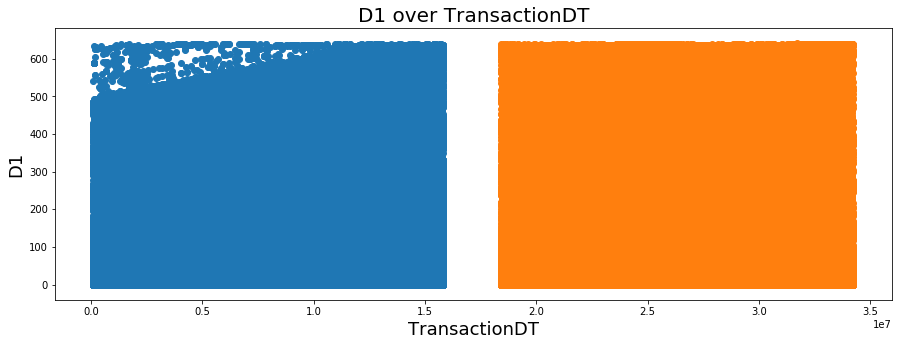

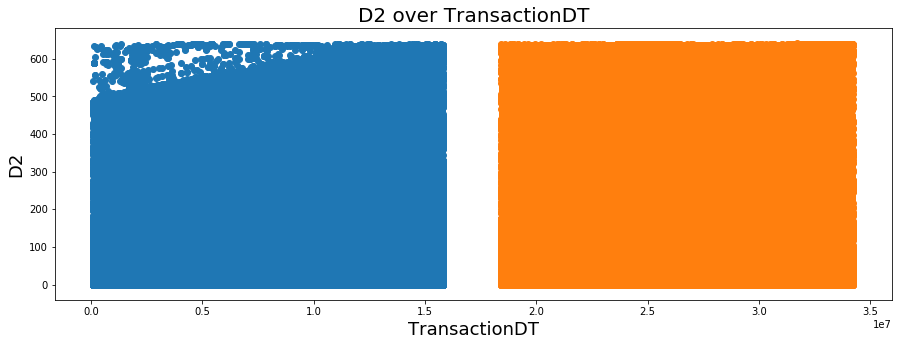

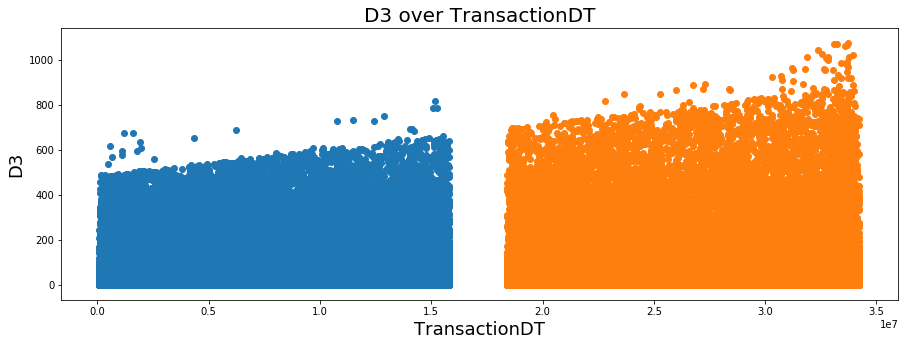

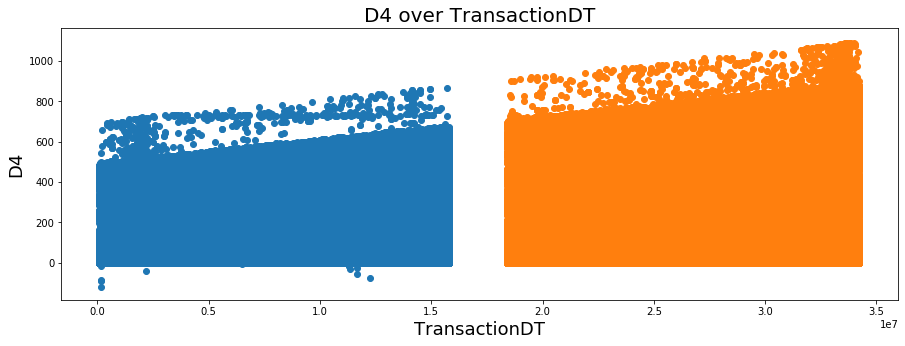

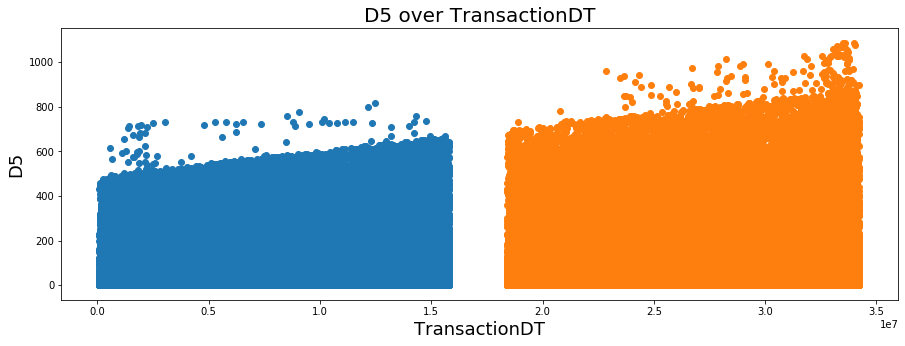

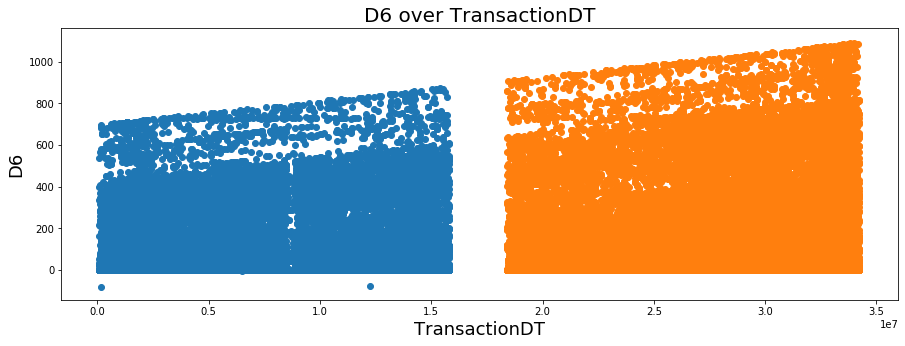

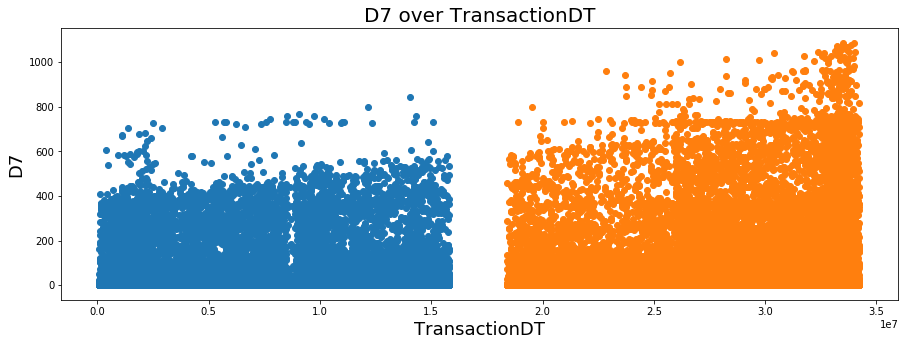

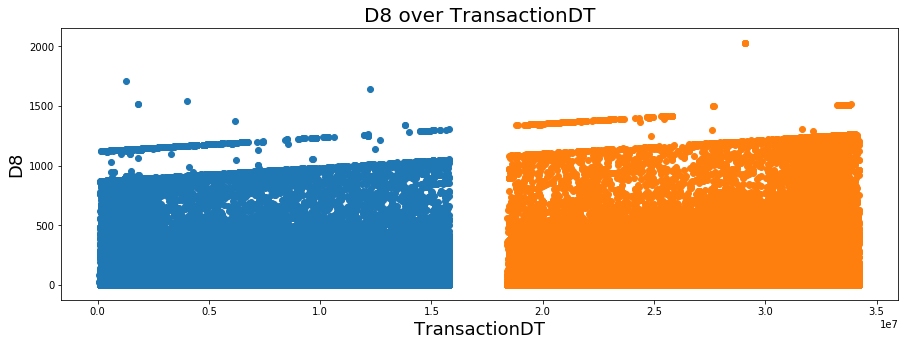

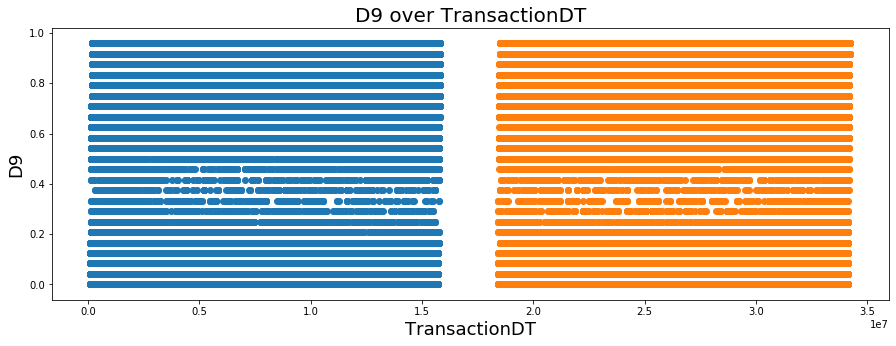

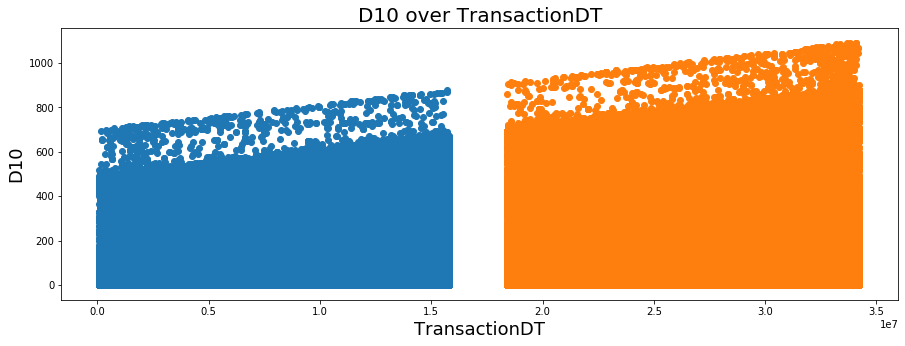

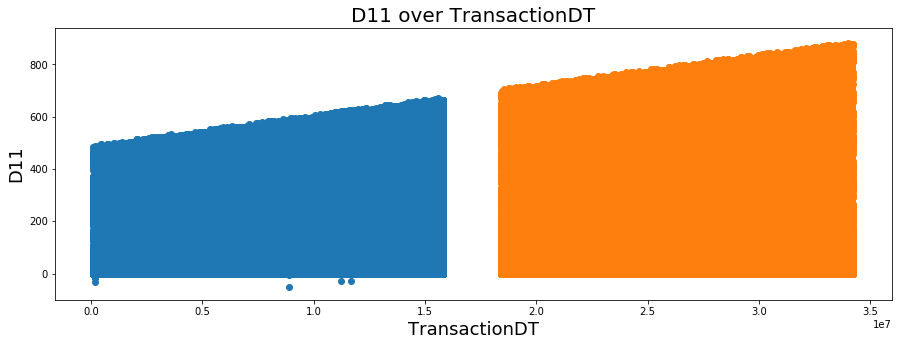

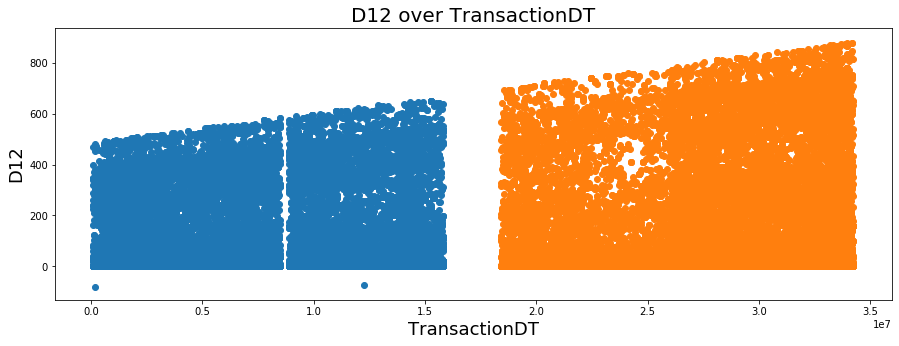

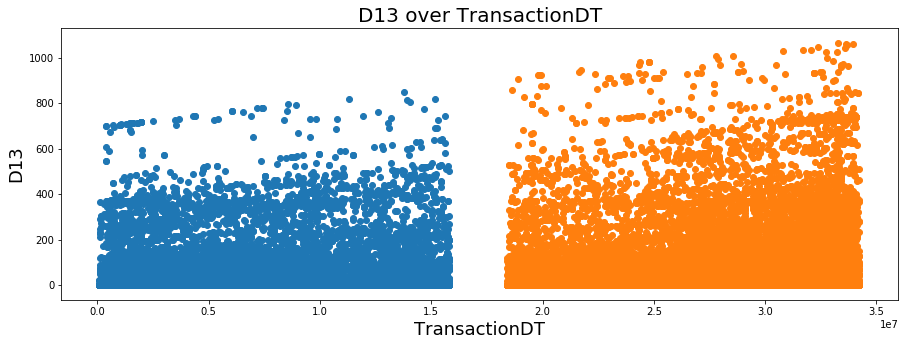

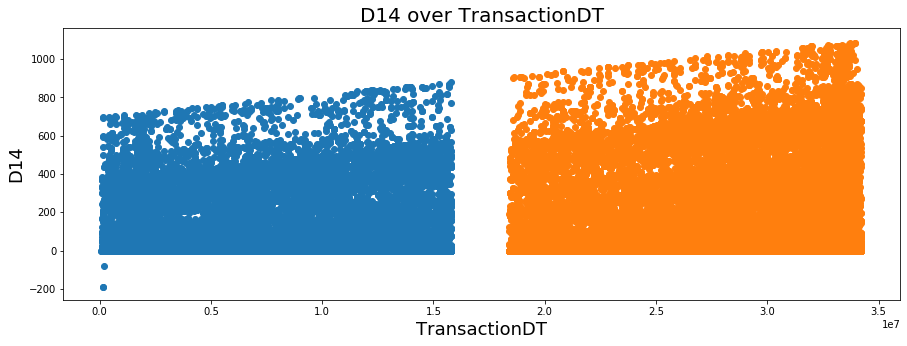

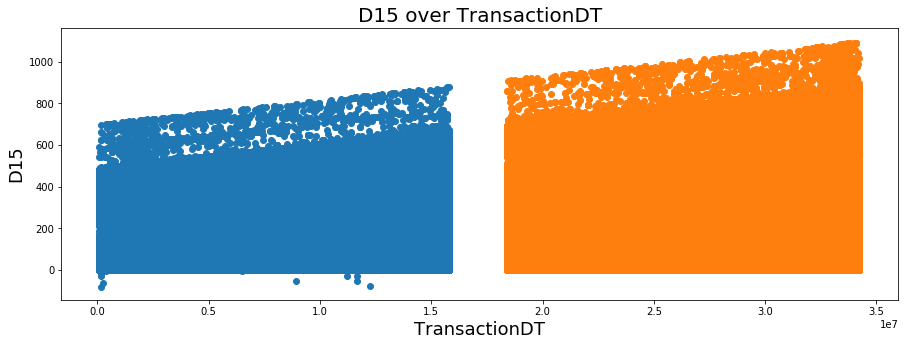

In [66]:
# D over TransDT
for col in list(df.columns)[31:46]:
    scatter_plot(df, col, df_test = df_test)

- increasing linearly with time except D9
- seems D1, D2 values over 640 are truncated
- D7 so random, no meaning, just count something

In [85]:
# substracting # of days past from the reference time
df_D_tfm = df[['TransactionDT']].copy()
df_test_D_tfm = df_test[['TransactionDT']].copy()
for i in range(1,16):
    if i in [7,9]: continue
    df_D_tfm['D'+str(i)] =  df['D'+str(i)] - np.floor(df.TransactionDT/np.float32(24*60*60))
    df_test_D_tfm['D'+str(i)] = df_test['D'+str(i)] - np.floor(df_test.TransactionDT/np.float32(24*60*60)) 

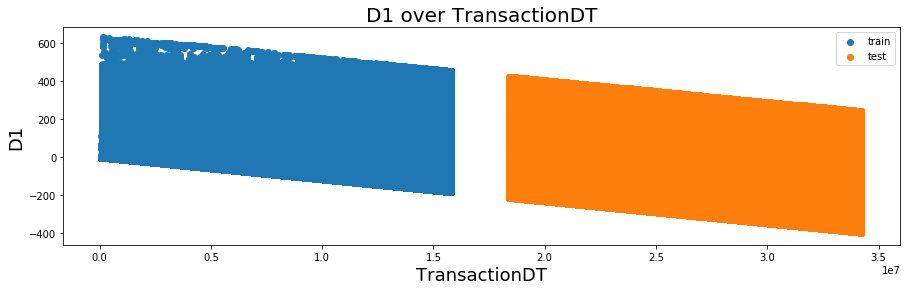

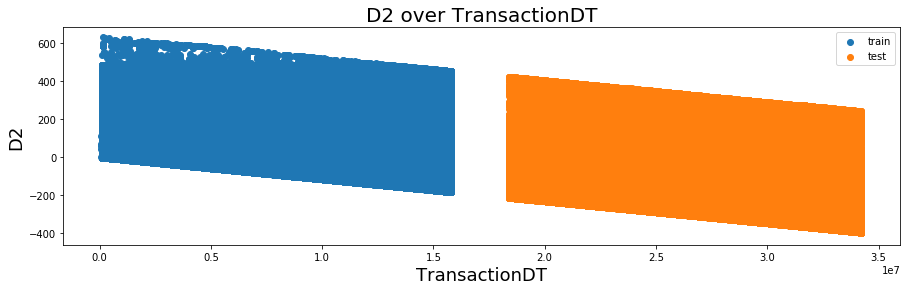

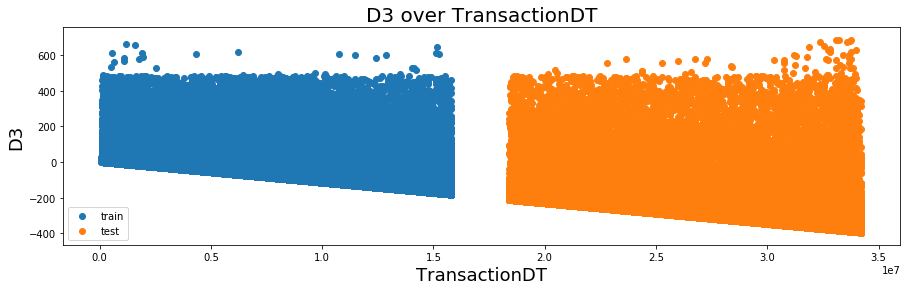

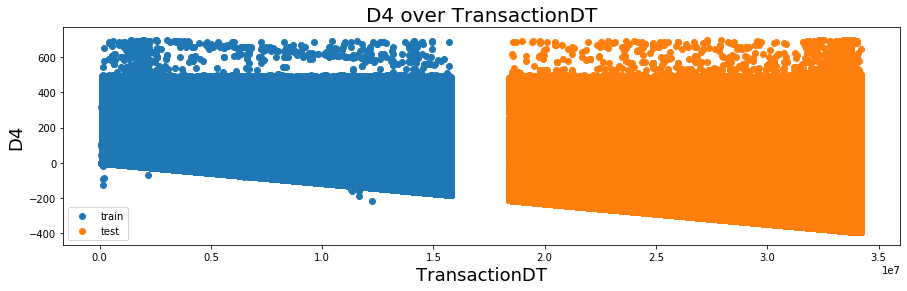

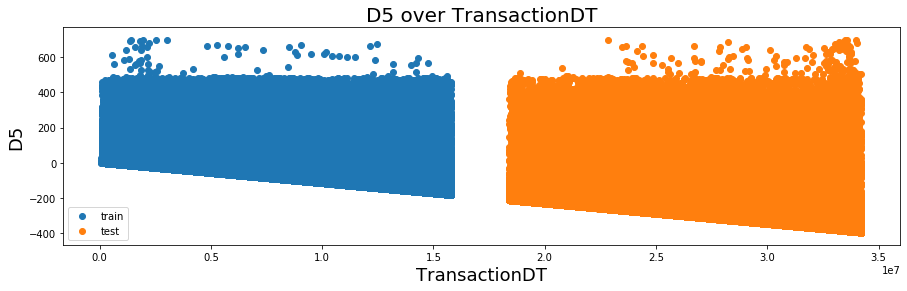

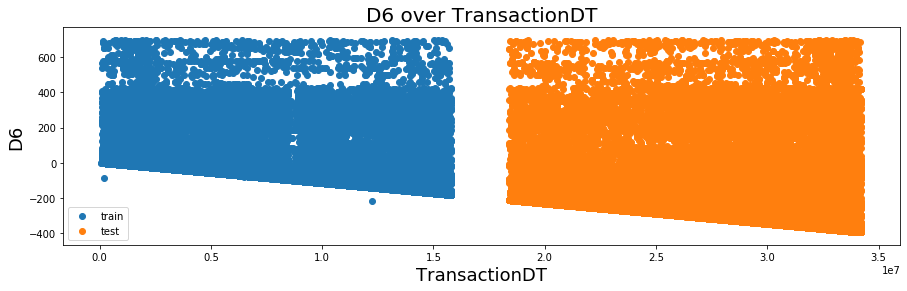

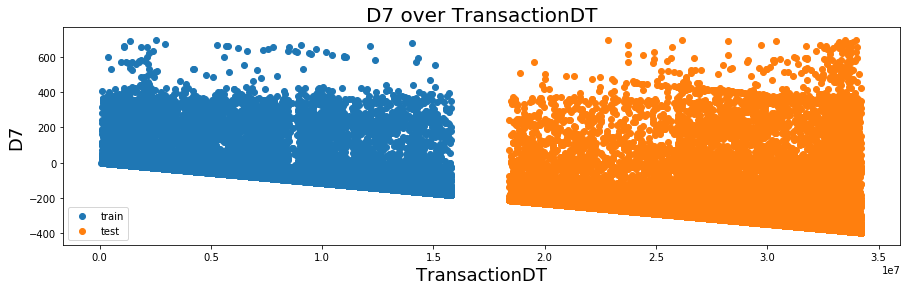

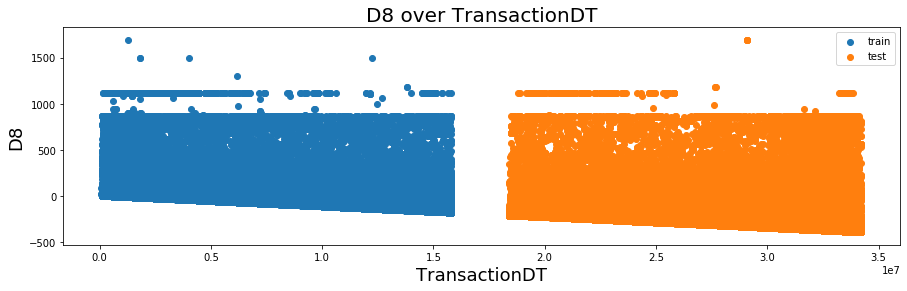

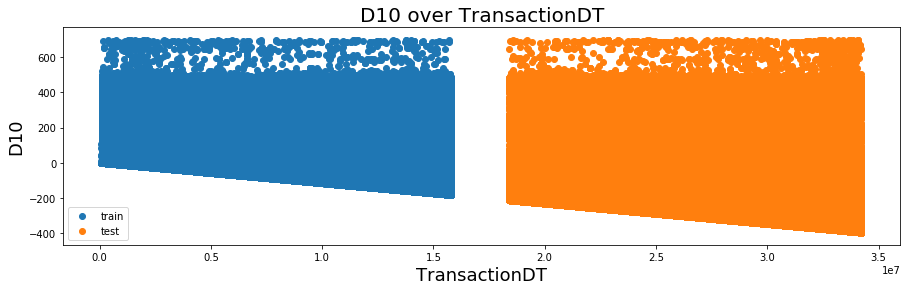

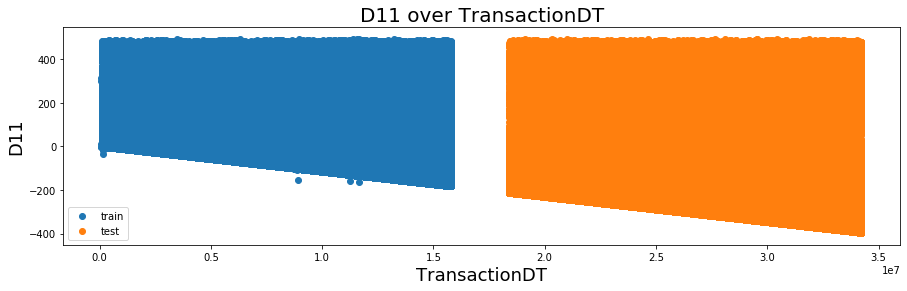

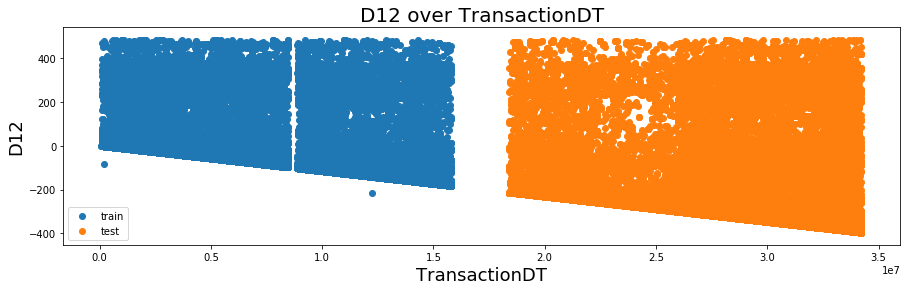

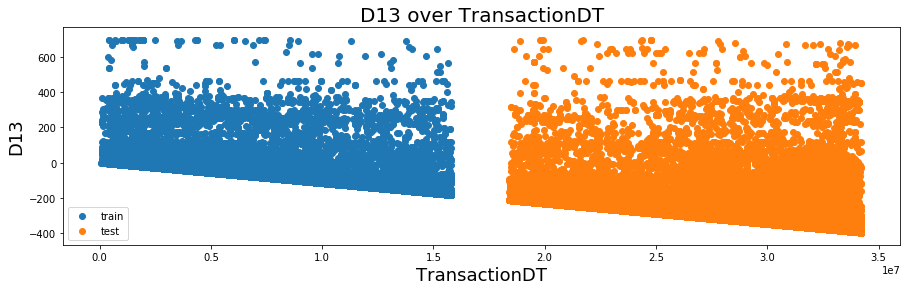

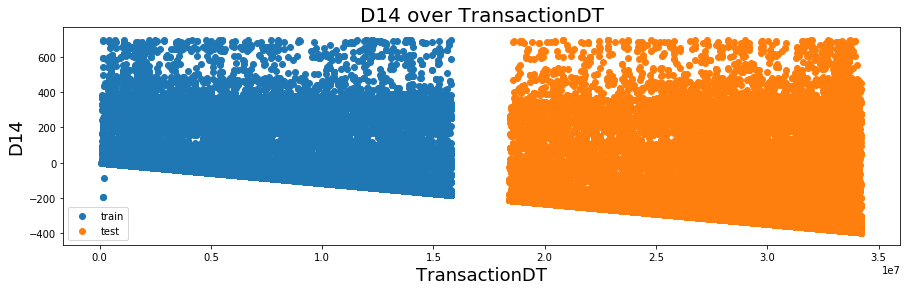

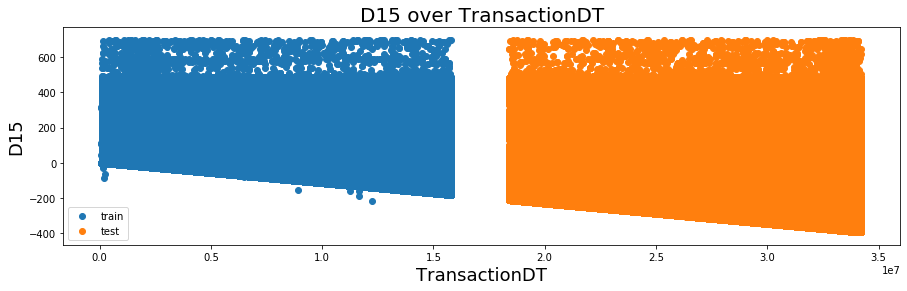

In [72]:
for col in list(df.columns)[31:46]:
    if col == 'D9': continue
    scatter_plot(df_D_tfm, col, df_test = df_test_D_tfm)

In [668]:
df_D_tfm = df_D_tfm2

In [673]:
df_D_tfm['TransactionAmt']=df['TransactionAmt']

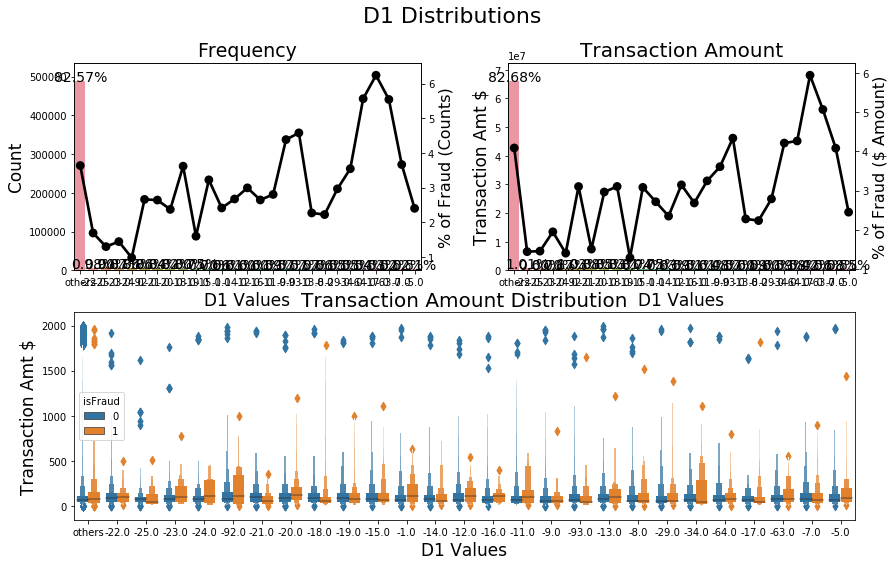

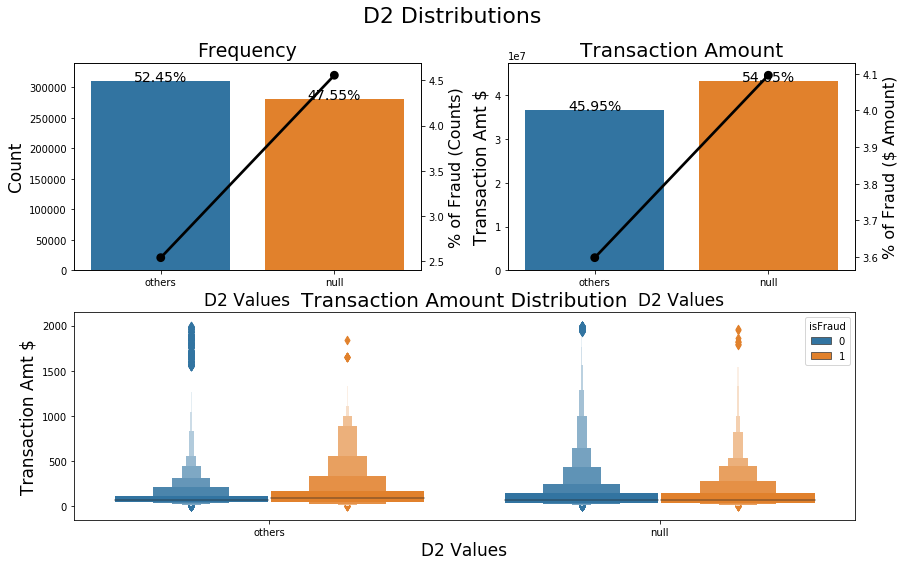

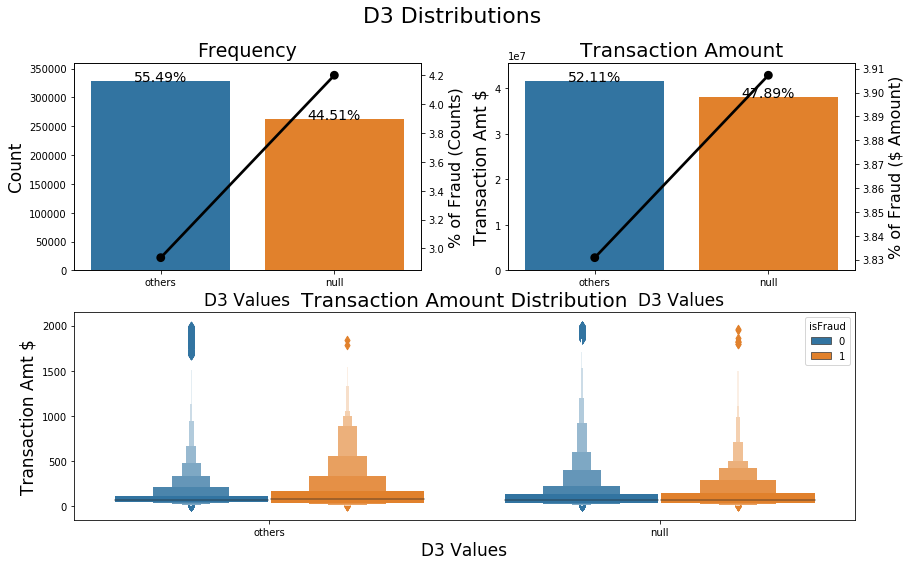

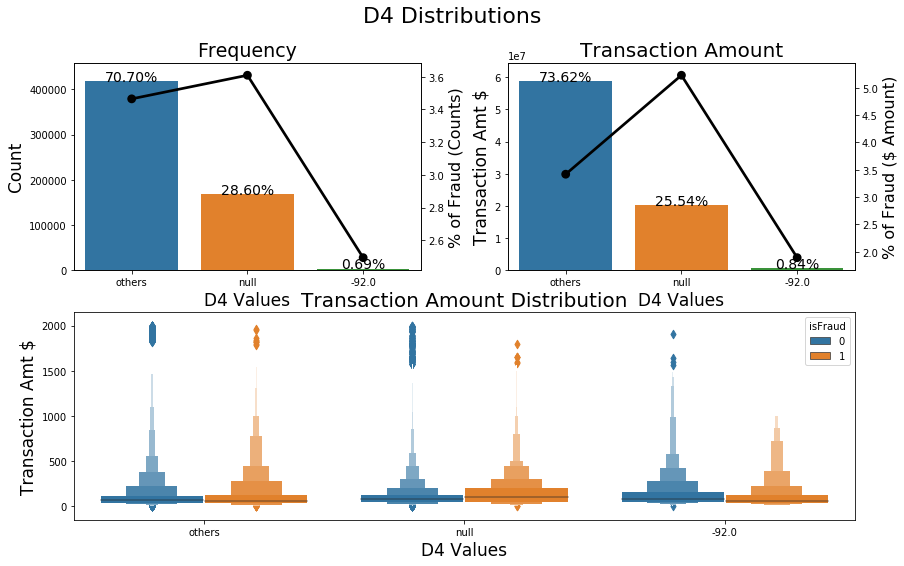

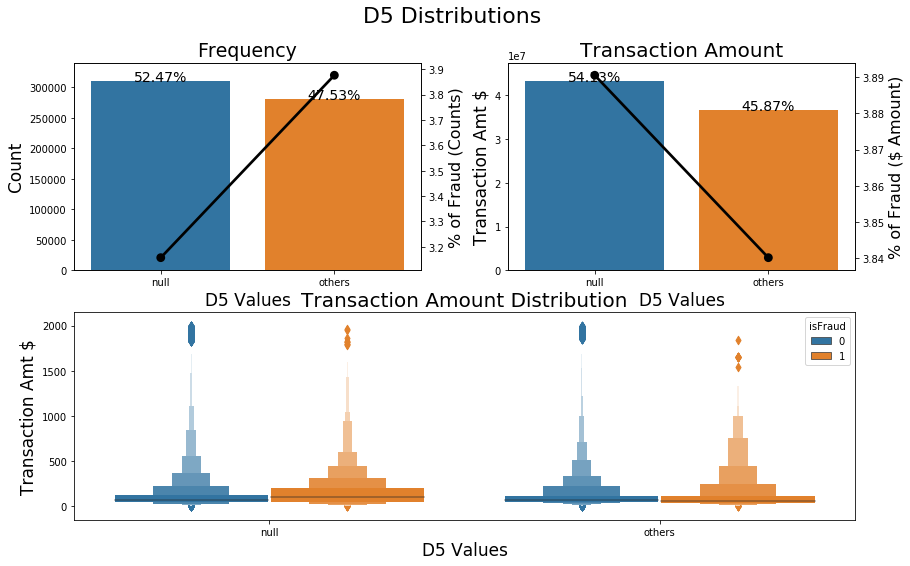

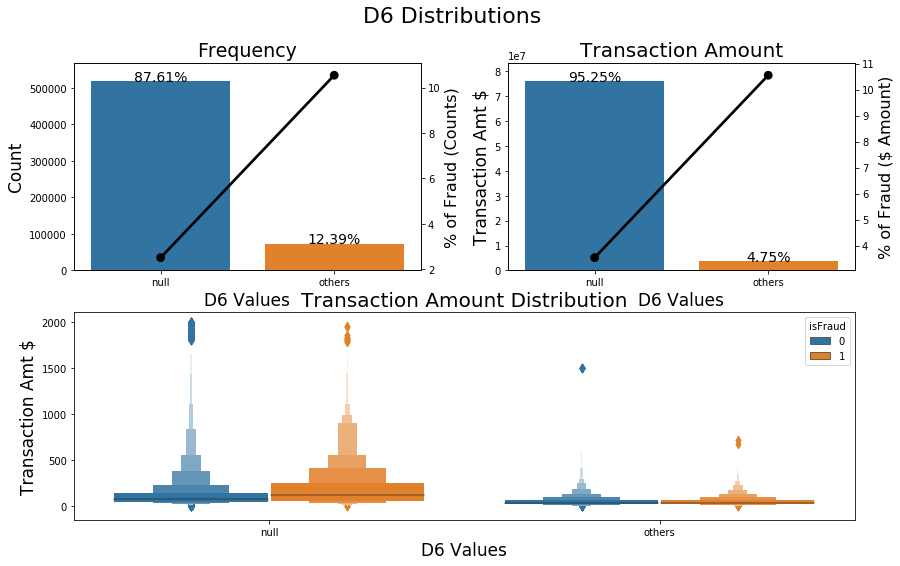

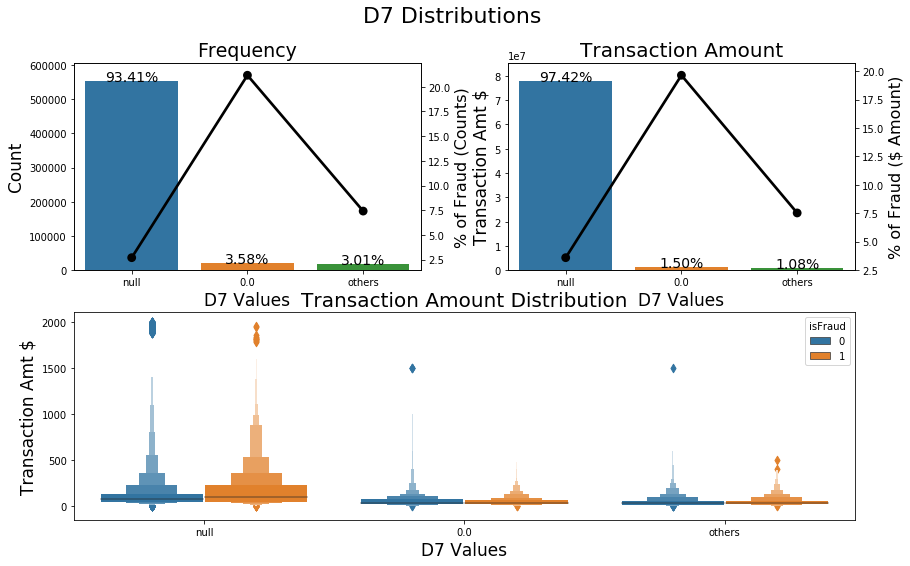

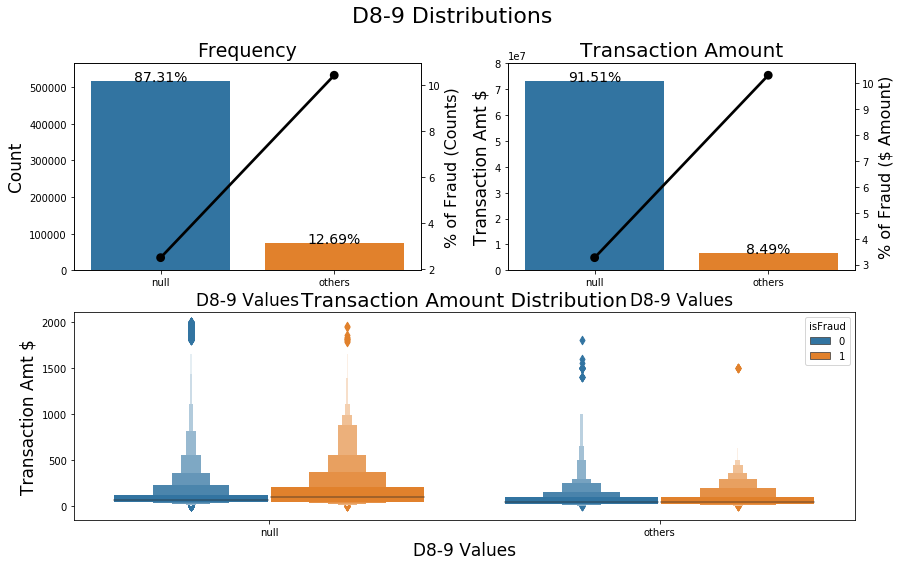

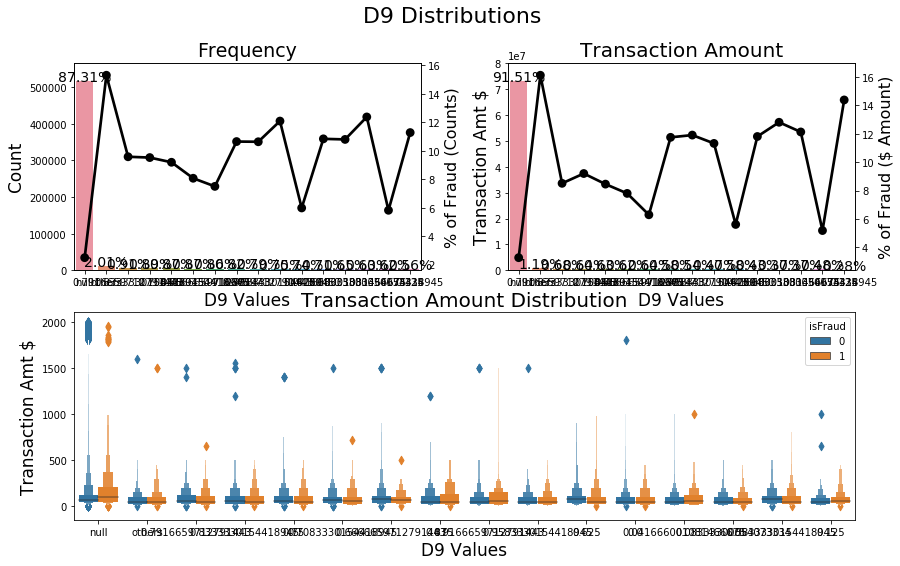

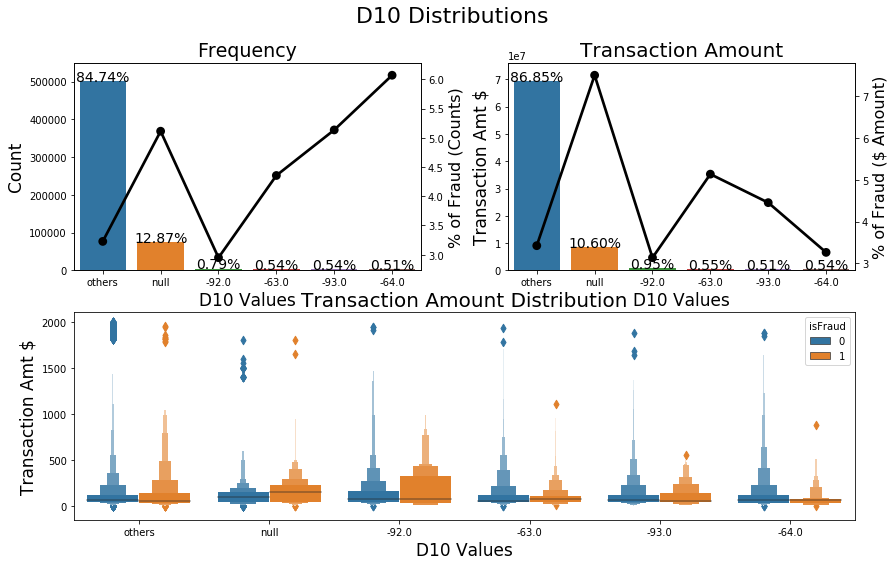

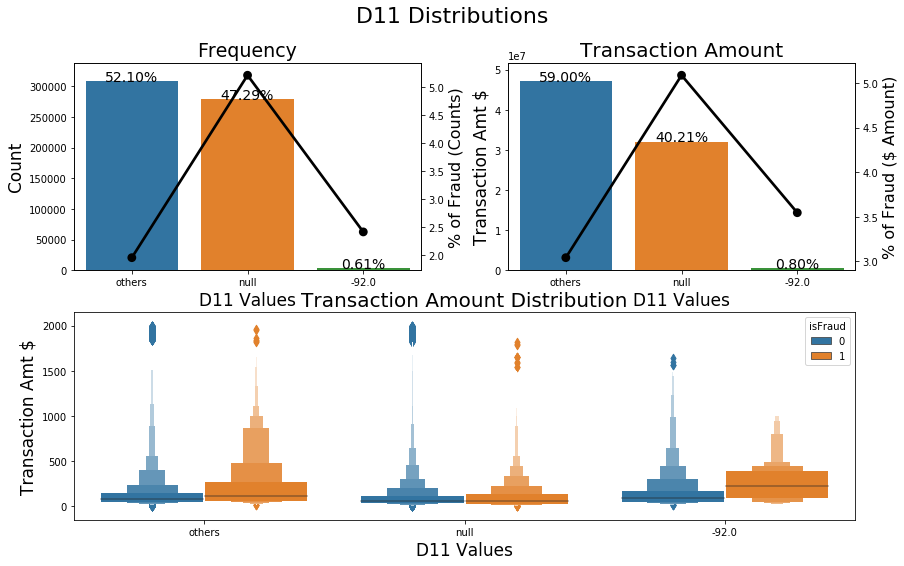

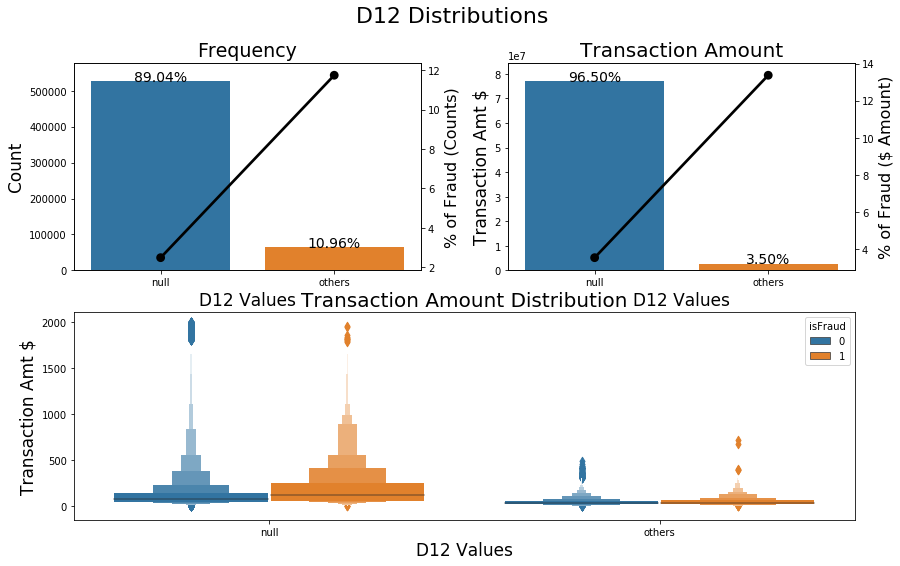

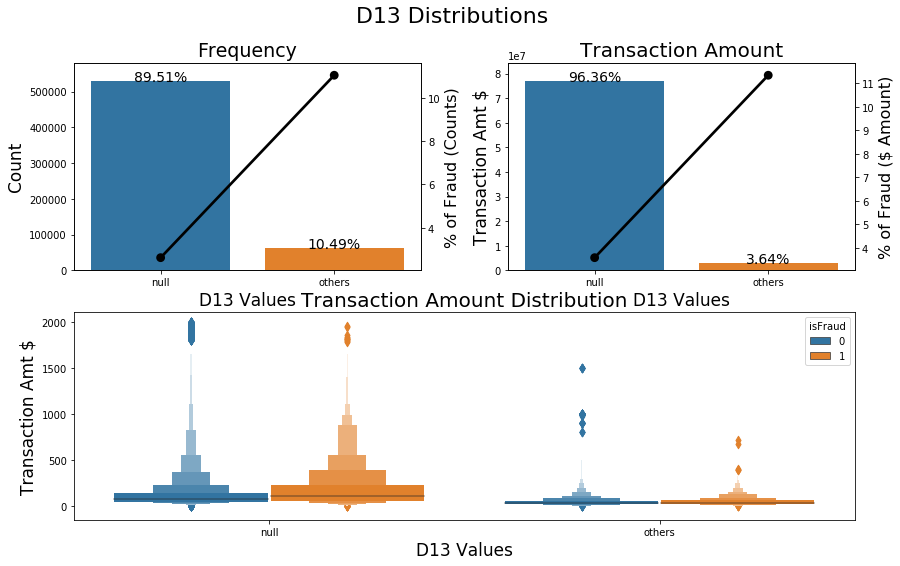

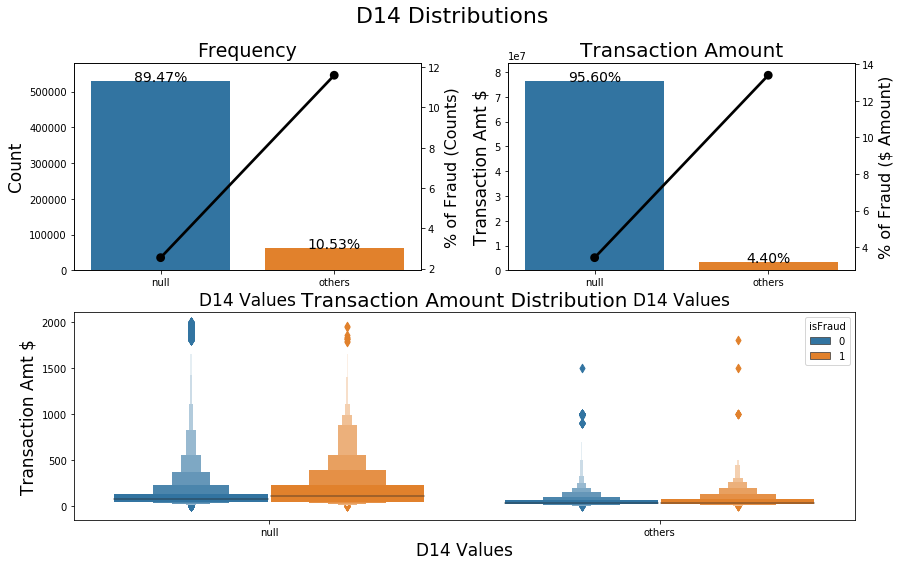

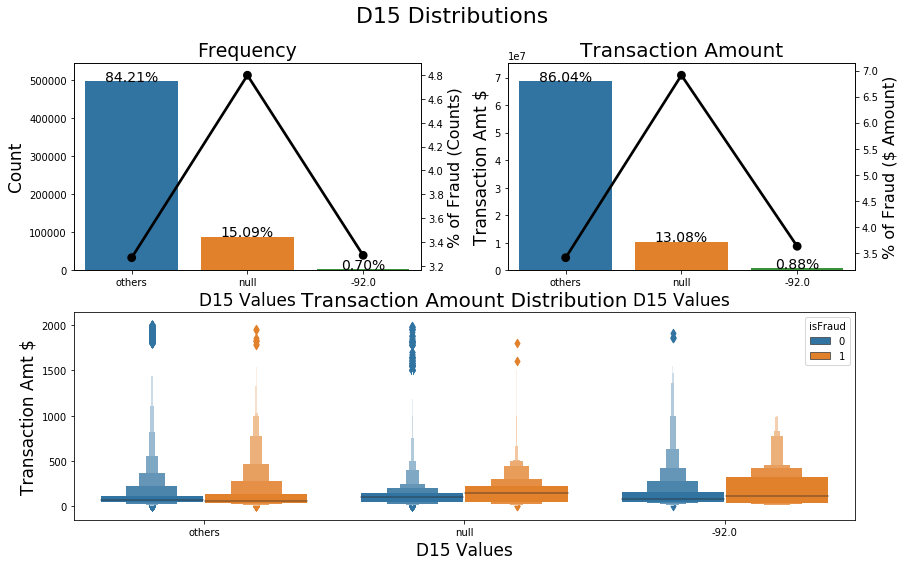

In [676]:
for col in list(df.columns)[31:46]:
    if col in ['D7','D9']:
        bar_plot(df,col, others_threshold=3000 ,reduced=True)
    elif col in ['D8']:
        bar_plot(df_D_tfm,'D8-9', others_threshold=3000 ,reduced=True)
    else:
        bar_plot(df_D_tfm,col, others_threshold=3000 ,reduced=True)

In [130]:
df['TransDay']=np.floor(df.TransactionDT/np.float32(24*60*60))

In [538]:
V_reduced = ['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V98',
 'V99',
 'V104',
 'V105',
 'V107',
 'V108',
 'V109',
 'V111',
 'V114',
 'V115',
 'V117',
 'V118',
 'V120',
 'V121',
 'V123',
 'V124',
 'V126',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V155',
 'V160',
 'V162',
 'V165',
 'V169',
 'V171',
 'V173',
 'V174',
 'V175',
 'V176',
 'V180',
 'V181',
 'V185',
 'V187',
 'V188',
 'V197',
 'V198',
 'V202',
 'V203',
 'V204',
 'V205',
 'V207',
 'V209',
 'V210',
 'V216',
 'V220',
 'V221',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V234',
 'V238',
 'V240',
 'V244',
 'V248',
 'V250',
 'V252',
 'V253',
 'V257',
 'V258',
 'V260',
 'V261',
 'V264',
 'V265',
 'V266',
 'V267',
 'V271',
 'V277',
 'V281',
 'V283',
 'V284',
 'V285',
 'V286',
 'V289',
 'V291',
 'V296',
 'V297',
 'V298',
 'V301',
 'V303',
 'V305',
 'V306',
 'V307',
 'V309',
 'V310',
 'V314',
 'V320',
 'V325',
 'V326',
 'V329',
 'V335',
 'V338']

# M features <a name='M' />

In [35]:
summary_table(df[list(df.columns)[46:55]])

dtypes  missing  uniques min max top  1-freq 2nd most  2-freq 3rd most  \
M1  object   271100        2   -   -   T  319415        F      25        -   
M2  object   271100        2   -   -   T  285468        F   33972        -   
M3  object   271100        2   -   -   T  251731        F   67709        -   
M4  object   281444        3   -   -  M0  196405       M2   59865       M1   
M5  object   350482        2   -   -   F  132491        T  107567        -   
M6  object   169360        2   -   -   F  227856        T  193324        -   
M7  object   346265        2   -   -   F  211374        T   32901        -   
M8  object   346252        2   -   -   F  155251        T   89037        -   
M9  object   346252        2   -   -   T  205656        F   38632        -   

   3-freq  
M1      -  
M2      -  
M3      -  
M4  52826  
M5      -  
M6      -  
M7      -  
M8      -  
M9      -

posx and posy should be finite values
posx and posy should be finite values


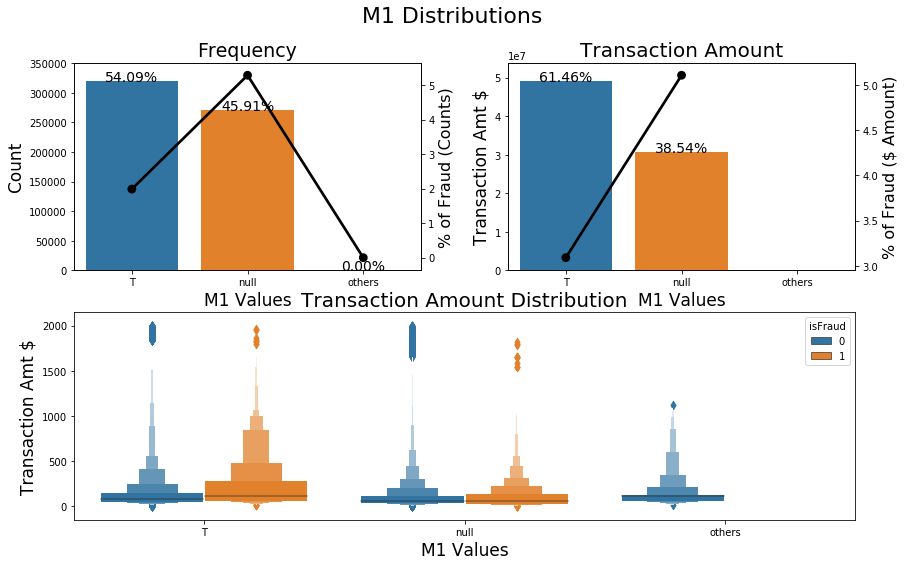

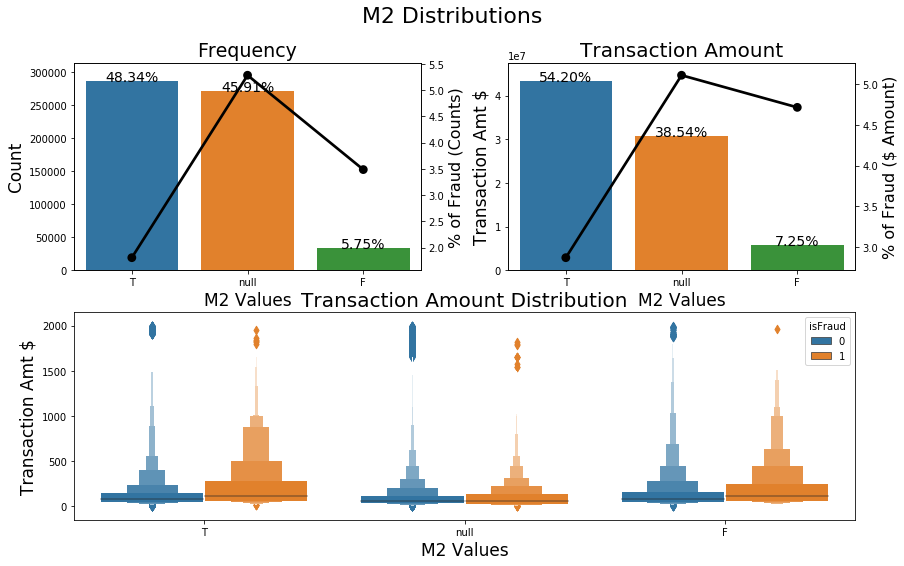

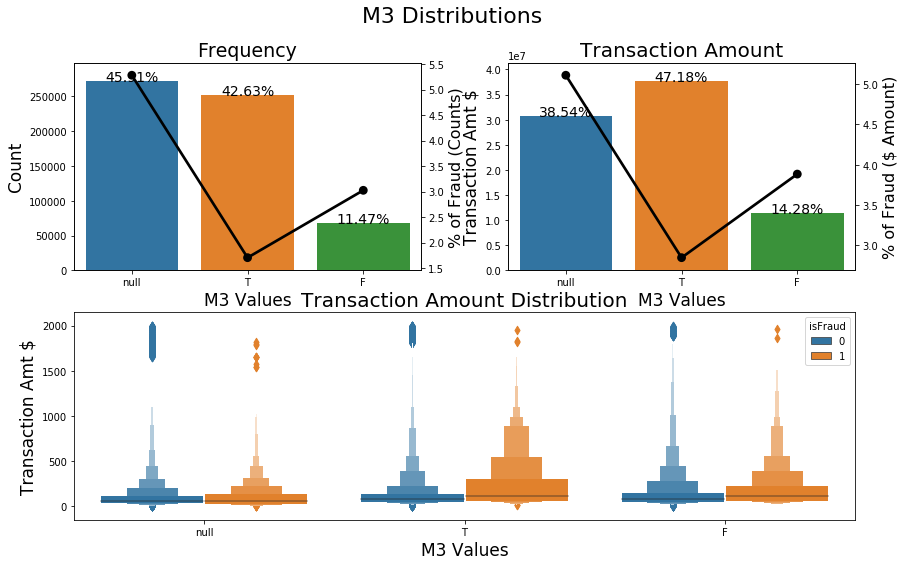

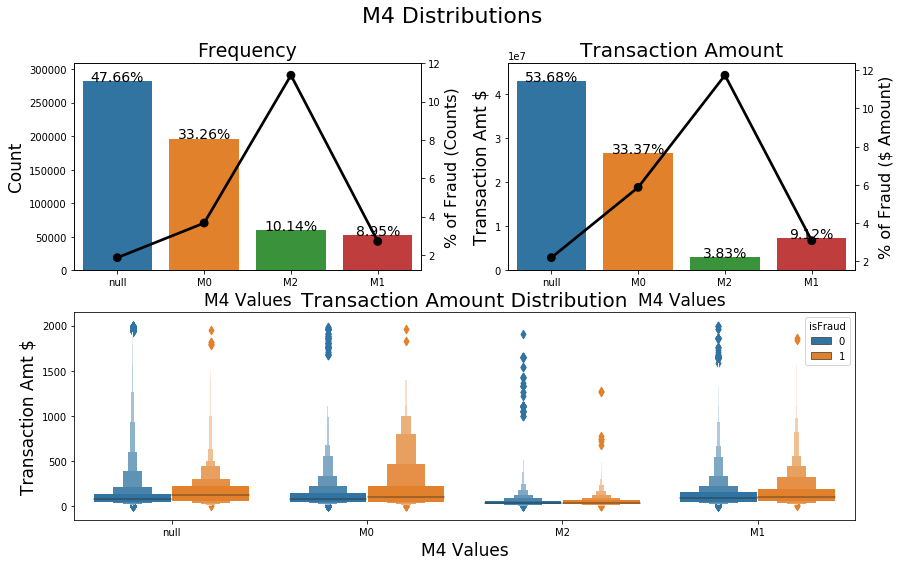

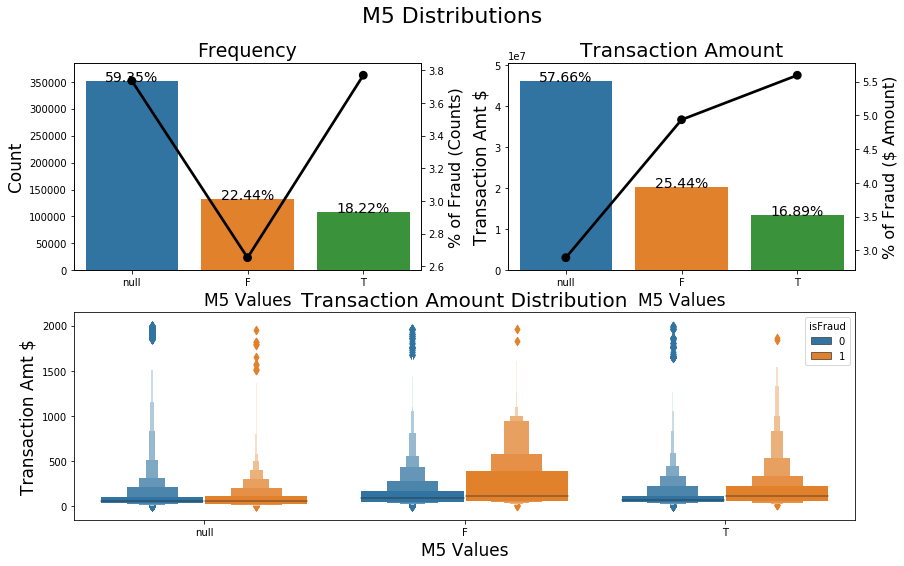

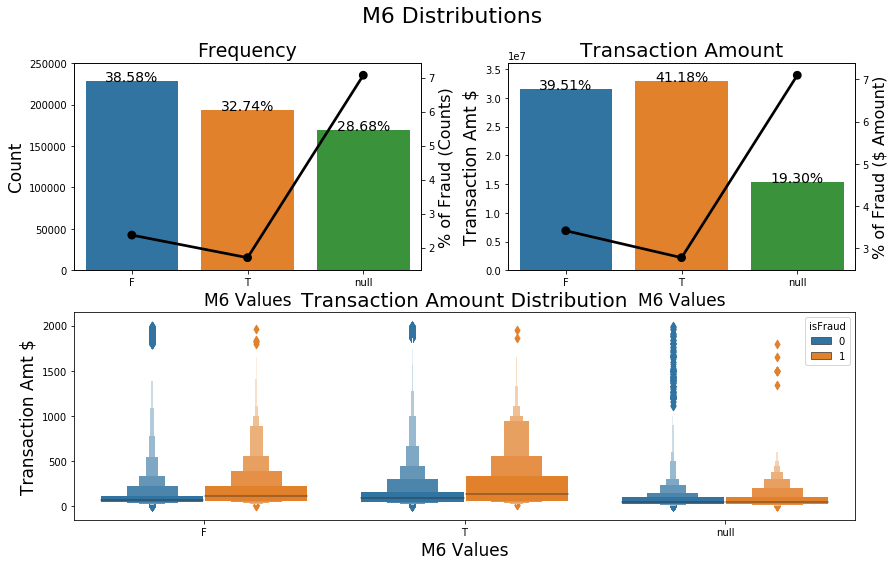

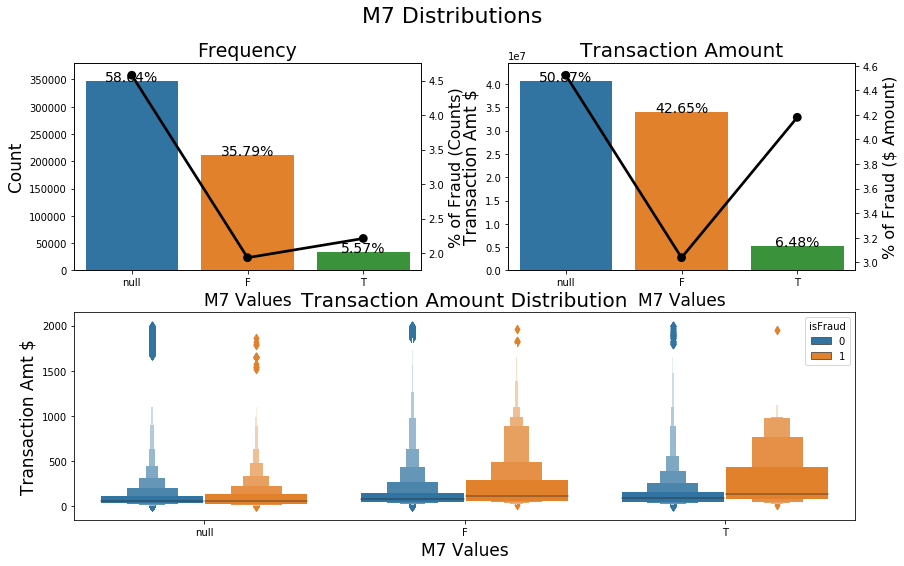

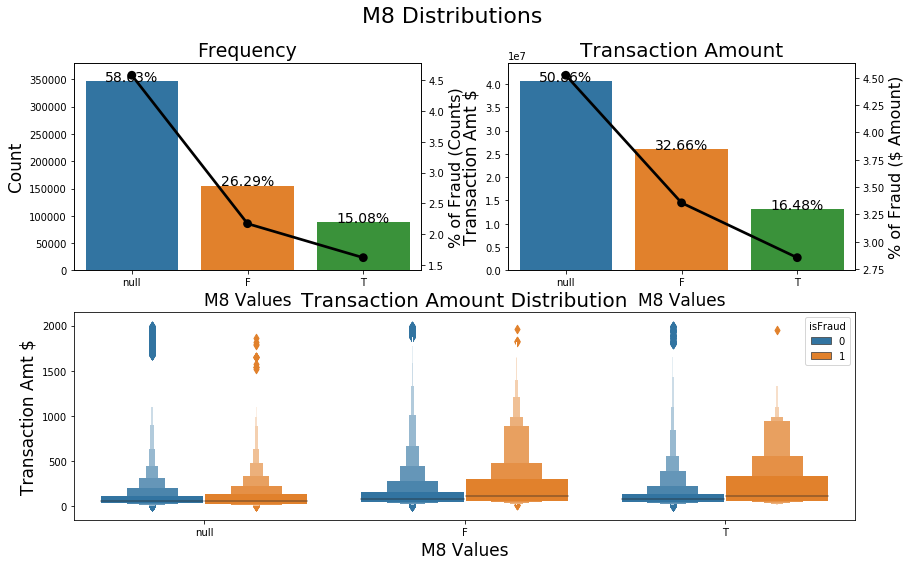

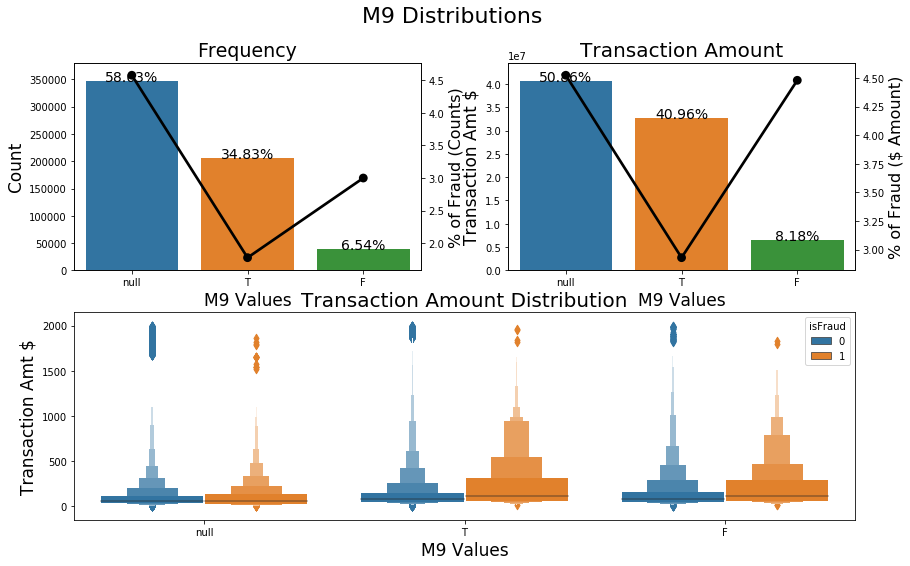

In [9]:
for col in list(df.columns)[46:55]:
    bar_plot(df,col, others_threshold=5000 ,reduced=True)

- Many null data but few feature values -> easy to analyze
- show some disparity b/w %Fraud in TransAmt and %Fraud in Counts

# V features <a name='V' />

In [50]:
V_table = summary_table(df[list(df.columns)[55:394]])

In [51]:
V_table

dtypes missing uniques min     max top    freq
V1    float32  279287       2   0       1   1  311236
V2    float32  279287       9   0       8   1  298894
V3    float32  279287      10   0       9   1  290583
V4    float32  279287       7   0       6   1  246500
V5    float32  279287       7   0       6   1  242883
...       ...     ...     ...  ..     ...  ..     ...
V335  float32  508189     672   0   55125   0   72668
V336  float32  508189     356   0   55125   0   75098
V337  float32  508189     254   0  104060   0   73464
V338  float32  508189     380   0  104060   0   72114
V339  float32  508189     334   0  104060   0   72799

[339 rows x 7 columns]

In [62]:
V_table['uniques'].sort_values(ascending=False).head(80)

V307    37367
V127    24414
V308    23064
V310    19136
V306    16210
        ...  
V168      965
V295      928
V103      928
V179      921
V95       881
Name: uniques, Length: 80, dtype: object

In [86]:
numeric_cols = ['D8',
 'D9',
 'V126',
 'V127',
 'V128',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216',
 'V263',
 'V264',
 'V265',
 'V266',
 'V267',
 'V268',
 'V269',
 'V270',
 'V271',
 'V272',
 'V273',
 'V274',
 'V275',
 'V276',
 'V277',
 'V278',
 'V306',
 'V307',
 'V308',
 'V309',
 'V310',
 'V312',
 'V313',
 'V314',
 'V315',
 'V316',
 'V317',
 'V318',
 'V320',
 'V321',
 'card1',
 'id_11']

In [87]:
numeric_table = summary_table(df[numeric_cols])

In [89]:
numeric_table

dtypes missing uniques   min       max       top    freq
D8     float32  515614   12353     0   1707.79  0.791666    1351
D9     float32  515614      24     0  0.958333  0.791666    5388
V126   float32     314   10299     0    160000         0  510542
V127   float32     314   24414     0    160000         0  366578
V128   float32     314   14507     0    160000         0  454213
V130   float32     314   12332     0     55125         0  403766
V131   float32     314    4444     0     55125         0  496523
V132   float32     314    6560     0     93736         0  556214
V133   float32     314    9949     0    133915         0  535961
V134   float32     314    8178     0     98476         0  547743
V135   float32     314    3724     0     90750         0  563527
V136   float32     314    4852     0     90750         0  547750
V137   float32     314    4252     0     90750         0  558074
V202   float32  450909   10970     0    104060         0  106161
V203   float32  450909   14951     0    139777         0   98207
V204   float32  450909   12858     0    104060         0  101660
V205   float32  450909    2240     0     55125         0  128800
V206   float32  450909    1780     0     55125         0  132868
V207   float32  450909    3246     0     55125         0  123086
V208   float32  450721    2552     0      3300         0  123863
V209   float32  450721    3451     0      8050         0  122714
V210   float32  450721    2836     0      3300         0  123575
V211   float32  450909    7624     0     92888         0  120997
V212   float32  450909    8868     0    129006         0  118836
V213   float32  450909    8317     0     97628         0  119688
V214   float32  450909    2282     0    104060         0  125518
V215   float32  450909    2747     0    104060         0  123142
V216   float32  450909    2532     0    104060         0  124108
V263   float32  460110   10422     0    153600         0   98285
V264   float32  460110   13358     0    153600         0   90334
V265   float32  460110   11757     0    153600         0   94337
V266   float32  460110    2178     0     55125         0  120515
V267   float32  460110    3616     0     55125         0  112053
V268   float32  460110    2756     0     55125         0  116323
V269   float32  460110     151     0     55125         0  128257
V270   float32  449124    2340     0      4000         0  128634
V271   float32  449124    2787     0      4000         0  128066
V272   float32  449124    2507     0      4000         0  128436
V273   float32  460110    7177     0     51200         0  112885
V274   float32  460110    8315     0     66000         0  110617
V275   float32  460110    7776     0     51200         0  111756
V276   float32  460110    2263     0    104060         0  117724
V277   float32  460110    2540     0    104060         0  115566
V278   float32  460110    2398     0    104060         0  116709
V306   float32      12   16210     0    108800         0  492169
V307   float32      12   37367     0    145765         0  316650
V308   float32      12   23064     0    108800         0  422464
V309   float32      12    4236     0     55125         0  545552
V310   float32      12   19136     0     55125         0  354815
V312   float32      12    8068     0     55125         0  466863
V313   float32    1269    5529     0   4817.47         0  489641
V314   float32    1269   11377     0   7519.87         0  473273
V315   float32    1269    6973     0   4817.47         0  487073
V316   float32      12    9814     0     93736         0  546442
V317   float32      12   15184     0    134021         0  519413
V318   float32      12   12309     0     98476         0  535074
V320   float32      12    6439     0    104060         0  542892
V321   float32      12    5560     0    104060         0  555629
card1    int32       0   13553  1000     18396      7919   14932
id_11  float32  449562     365    90       100       100  133162

In [88]:
numeric_table['uniques']

D8       12353
D9          24
V126     10299
V127     24414
V128     14507
V130     12332
V131      4444
V132      6560
V133      9949
V134      8178
V135      3724
V136      4852
V137      4252
V202     10970
V203     14951
V204     12858
V205      2240
V206      1780
V207      3246
V208      2552
V209      3451
V210      2836
V211      7624
V212      8868
V213      8317
V214      2282
V215      2747
V216      2532
V263     10422
V264     13358
V265     11757
V266      2178
V267      3616
V268      2756
V269       151
V270      2340
V271      2787
V272      2507
V273      7177
V274      8315
V275      7776
V276      2263
V277      2540
V278      2398
V306     16210
V307     37367
V308     23064
V309      4236
V310     19136
V312      8068
V313      5529
V314     11377
V315      6973
V316      9814
V317     15184
V318     12309
V320      6439
V321      5560
card1    13553
id_11      365
Name: uniques, dtype: object

In [90]:
df['V202'].value_counts()

0.000000        106161
100.000000        2186
200.000000        1500
50.000000         1391
150.000000        1256
                 ...  
19265.000000         1
75.251503            1
75.251404            1
18.812799            1
66227.000000         1
Name: V202, Length: 10970, dtype: int64

In [76]:
df['V269'].isna().sum()

460110

- V1 - V339, 339 columns

In [38]:
df[list(df.columns)[55:57]].isna().sum().values

array([279287, 279287])

In [41]:
for key, value in zip(df[list(df.columns)[55:394]].isna().sum().keys(),df[list(df.columns)[55:394]].isna().sum().values):
    print(f"{key}: {value}")

V1: 279287
V2: 279287
V3: 279287
V4: 279287
V5: 279287
V6: 279287
V7: 279287
V8: 279287
V9: 279287
V10: 279287
V11: 279287
V12: 76073
V13: 76073
V14: 76073
V15: 76073
V16: 76073
V17: 76073
V18: 76073
V19: 76073
V20: 76073
V21: 76073
V22: 76073
V23: 76073
V24: 76073
V25: 76073
V26: 76073
V27: 76073
V28: 76073
V29: 76073
V30: 76073
V31: 76073
V32: 76073
V33: 76073
V34: 76073
V35: 168969
V36: 168969
V37: 168969
V38: 168969
V39: 168969
V40: 168969
V41: 168969
V42: 168969
V43: 168969
V44: 168969
V45: 168969
V46: 168969
V47: 168969
V48: 168969
V49: 168969
V50: 168969
V51: 168969
V52: 168969
V53: 77096
V54: 77096
V55: 77096
V56: 77096
V57: 77096
V58: 77096
V59: 77096
V60: 77096
V61: 77096
V62: 77096
V63: 77096
V64: 77096
V65: 77096
V66: 77096
V67: 77096
V68: 77096
V69: 77096
V70: 77096
V71: 77096
V72: 77096
V73: 77096
V74: 77096
V75: 89164
V76: 89164
V77: 89164
V78: 89164
V79: 89164
V80: 89164
V81: 89164
V82: 89164
V83: 89164
V84: 89164
V85: 89164
V86: 89164
V87: 89164
V88: 89164
V89: 89164
V

posx and posy should be finite values
posx and posy should be finite values


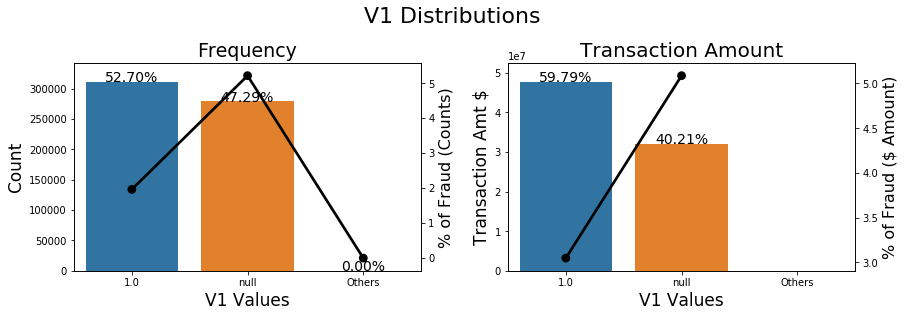

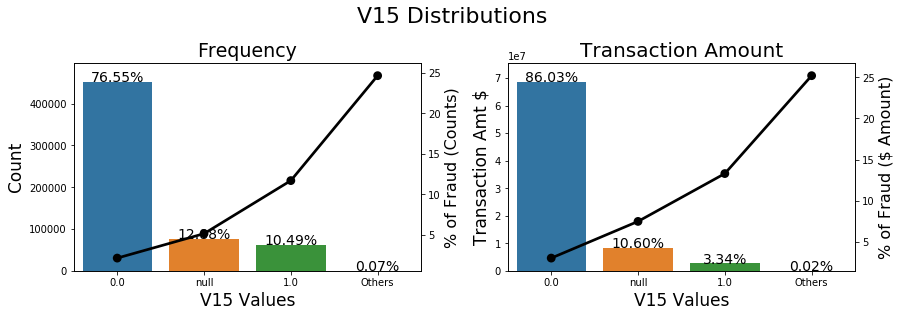

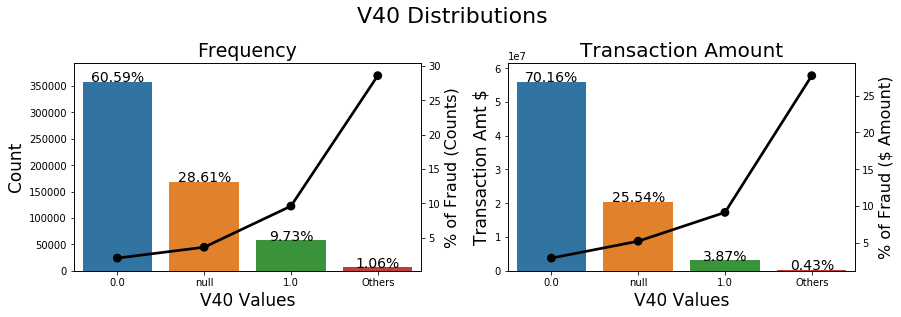

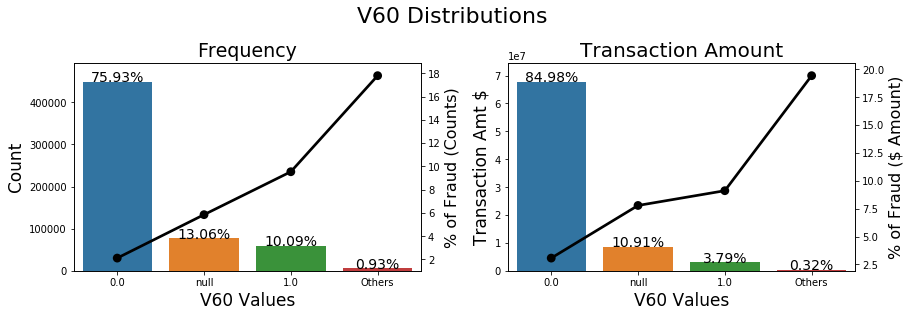

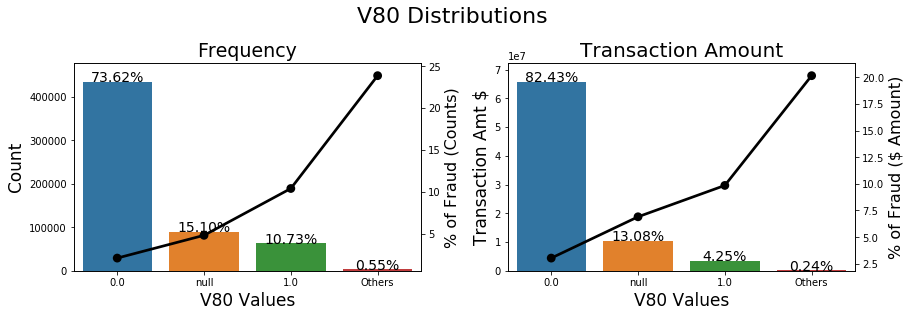

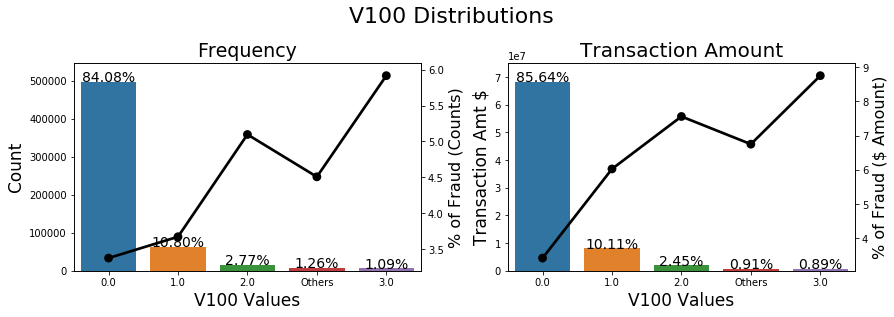

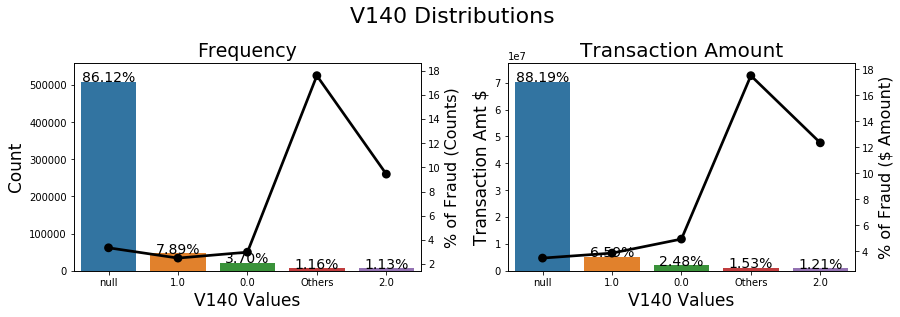

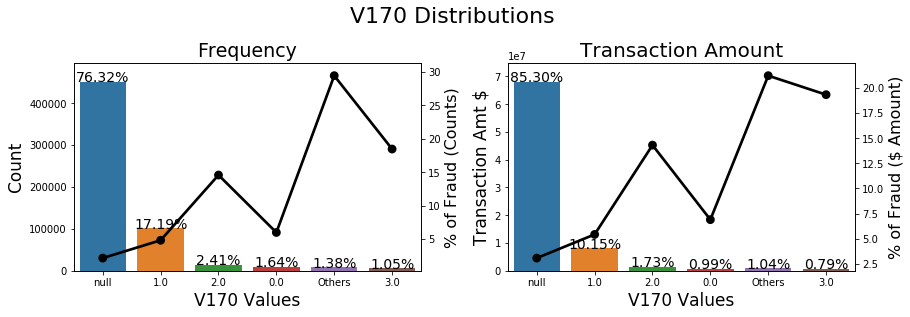

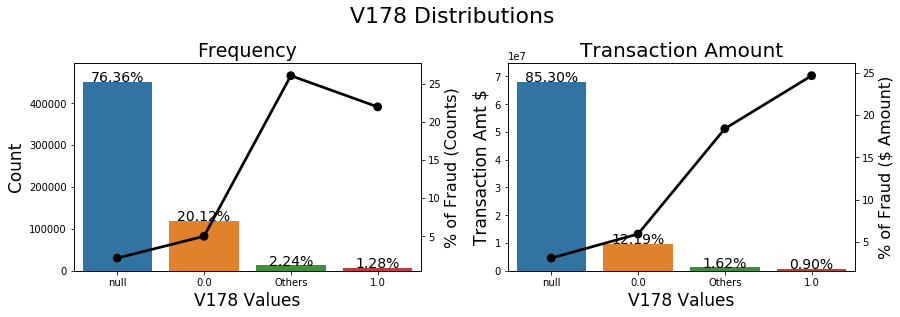

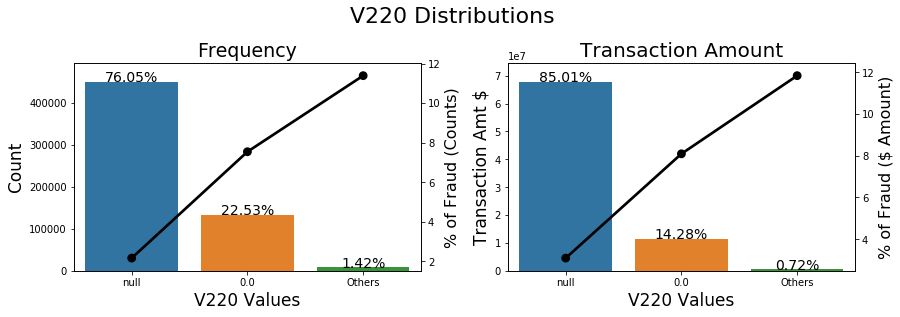

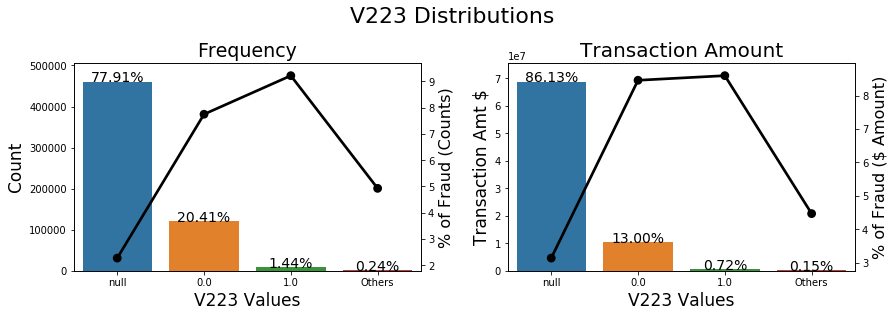

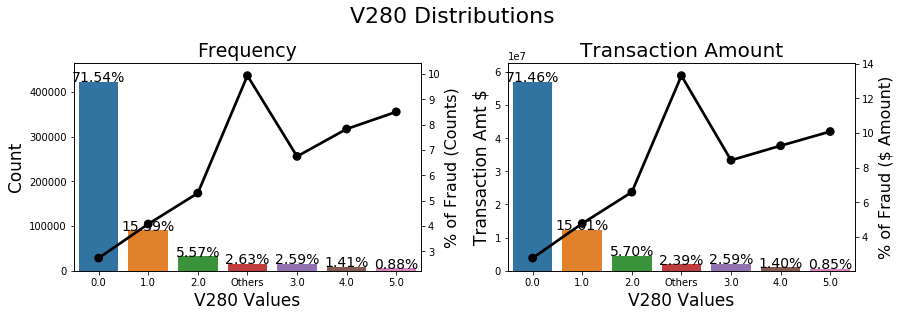

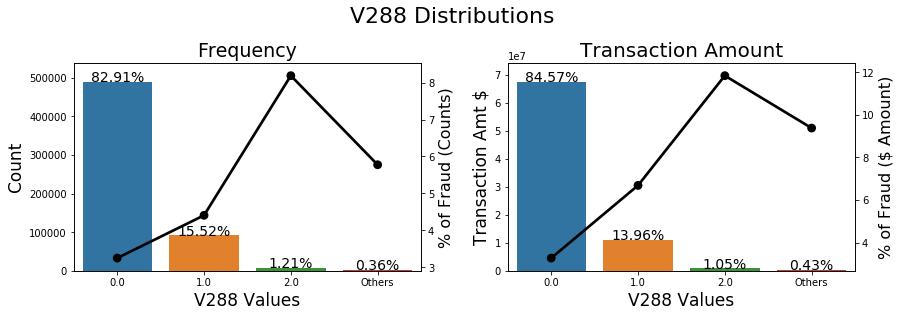

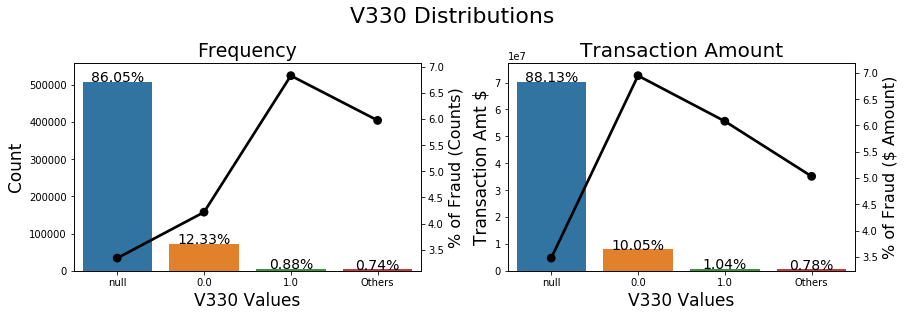

In [43]:
for ft in ['V1','V15','V40','V60','V80','V100','V140','V170','V178','V220','V223','V280','V288','V330']:
    bar_plot(df,ft,reduced=True)

# id features  (link example 1) <a name='id' />

<a id="id_features"></a>
# id features (link example 2)

In [243]:
summary_table(df[list(df.columns)[394:432]],target_df = df['isFraud'])

dtypes  missing  uniques  min     max                   top  1-freq  \
id_01  float32   446307       77 -100       0                    -5   82170   
id_02  float32   449668   115655    1  999595                  1102      11   
id_03  float32   524216       24  -13      10                     0   63903   
id_04  float32   524216       15  -28       0                     0   65739   
id_05  float32   453675       93  -72      52                     0   92743   
id_06  float32   453675      101 -100       0                     0   91325   
id_07  float32   585385       84  -46      61                     0     409   
id_08  float32   585385       94 -100       0                  -100     500   
id_09  float32   515614       46  -36      25                     0   70378   
id_10  float32   515614       62 -100       0                     0   72879   
id_11  float32   449562      365   90     100                   100  133162   
id_12   object   446307        2    -       -              NotFound  123025   
id_13  float32   463220       54   10      64                    52   58099   
id_14  float32   510496       25 -660     720                  -300   44121   
id_15   object   449555        3    -       -                 Found   67728   
id_16   object   461200        2    -       -                 Found   66324   
id_17  float32   451171      104  100     229                   166   78631   
id_18  float32   545427       18   10      29                    15   25489   
id_19  float32   451222      522  100     671                   266   19849   
id_20  float32   451279      394  100     661                   507   22311   
id_21  float32   585381      490  100     854                   252    2542   
id_22  float32   585371       25   10      44                    14    4736   
id_23   object   585371        3    -       -  IP_PROXY:TRANSPARENT    3489   
id_24  float32   585793       12   11      26                    11    2817   
id_25  float32   585408      341  100     548                   321    2494   
id_26  float32   585377       95  100     216                   161     824   
id_27   object   585371        2    -       -                 Found    5155   
id_28   object   449562        2    -       -                 Found   76232   
id_29   object   449562        2    -       -                 Found   74926   
id_30   object   512975       75    -       -            Windows 10   21155   
id_31   object   450258      130    -       -           chrome 63.0   22000   
id_32  float32   512954        4    0      32                    24   53071   
id_33   object   517251      260    -       -             1920x1080   16874   
id_34   object   512735        4    -       -        match_status:2   60011   
id_35   object   449555        2    -       -                     T   77814   
id_36   object   449555        2    -       -                     F  134066   
id_37   object   449555        2    -       -                     T  110452   
id_38   object   449555        2    -       -                     F   73922   

                 2nd most 2-freq               3rd most 3-freq  Frd ratio  
id_01                   0  19555                    -10  11257      0.078  
id_02                 696     10                   1141      9      0.080  
id_03                   1    863                      3    668      0.107  
id_04                  -5    132                     -6     98      0.107  
id_05                   1   8293                      2   4937      0.080  
id_06                  -1   4687                     -5   3849      0.080  
id_07                  16    245                     14    228      0.083  
id_08                   0    261                    -34    257      0.083  
id_09                   1   1616                      3    966      0.104  
id_10                  -6    295                     -5    247      0.104  
id_11               95.08   1231                  95.16    754      0.080  
id_12         

- id_01 - id_38, 38 columns

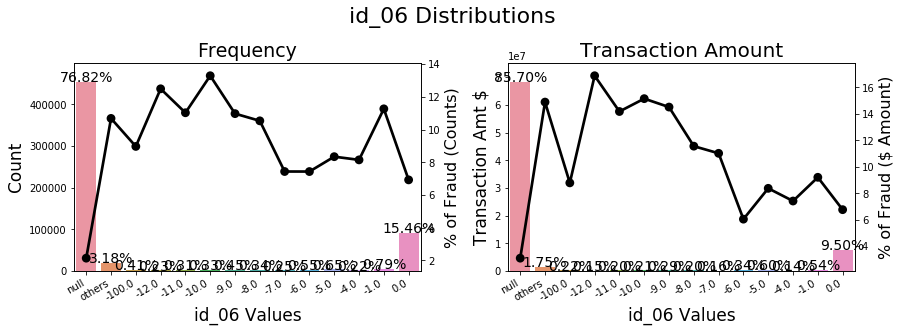

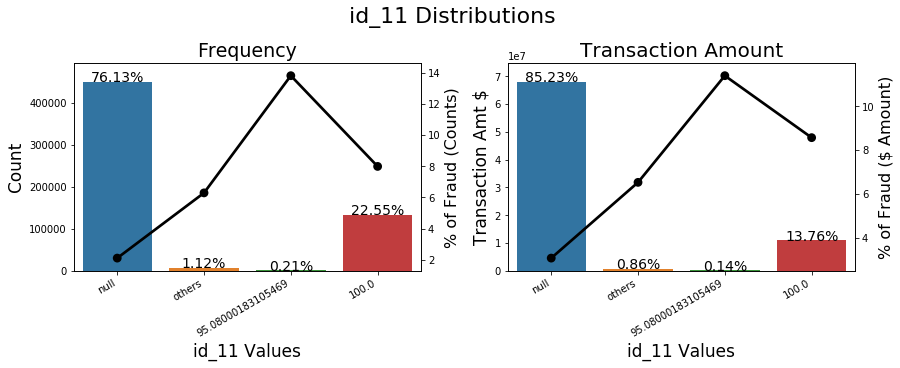

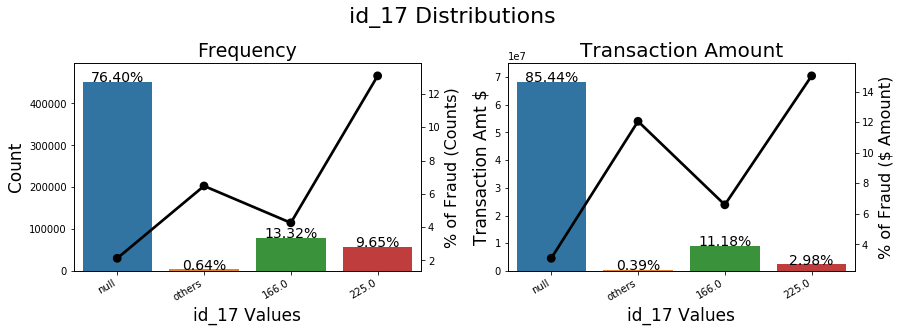

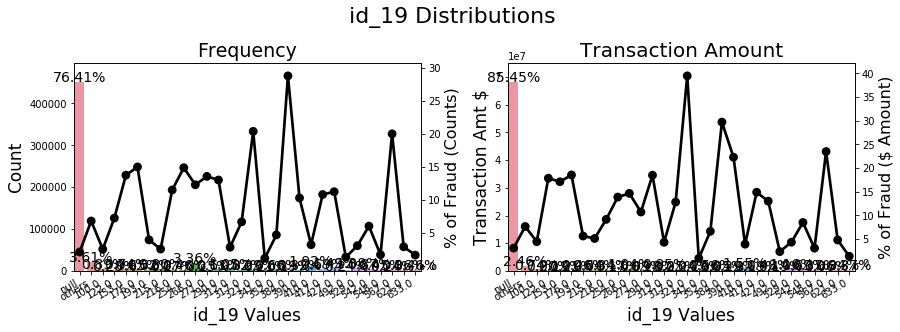

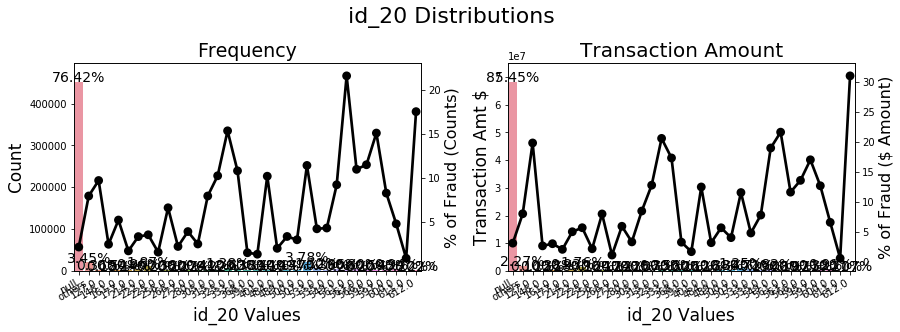

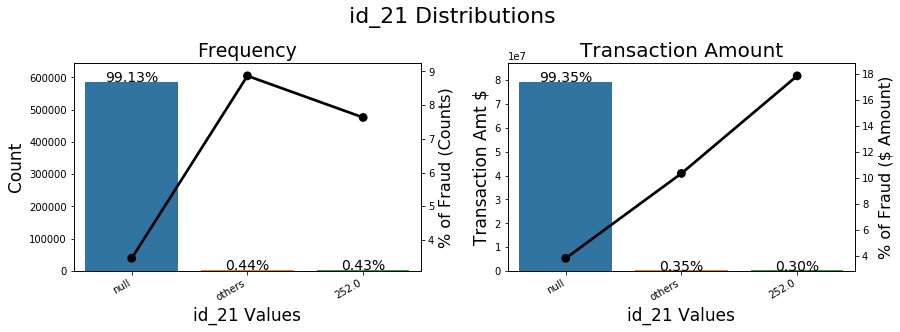

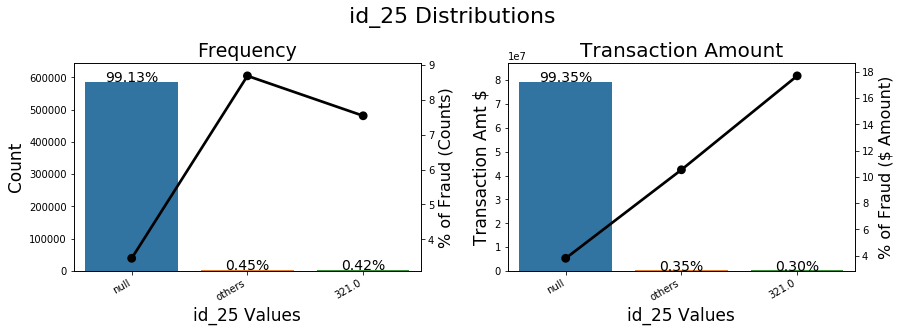

In [103]:
for ft in ['id_06','id_11','id_17','id_19','id_20','id_21','id_25']:
    bar_plot(df,ft,reduced=True,xtick_rotate=True,sorted_plot_order=True, others_threshold=1000)

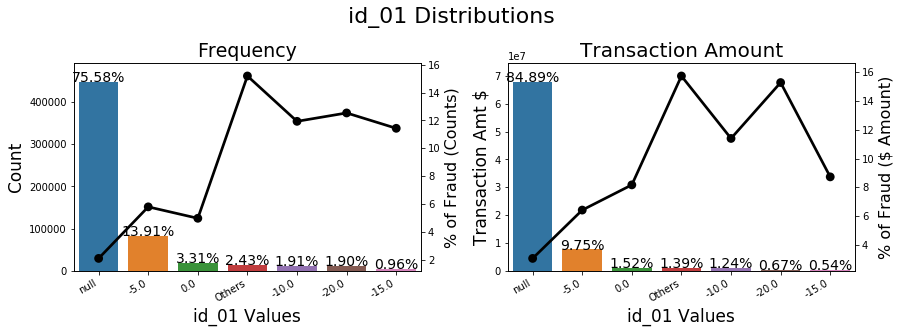

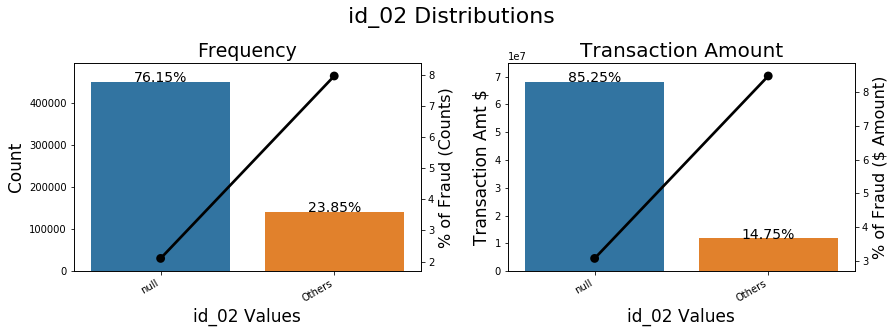

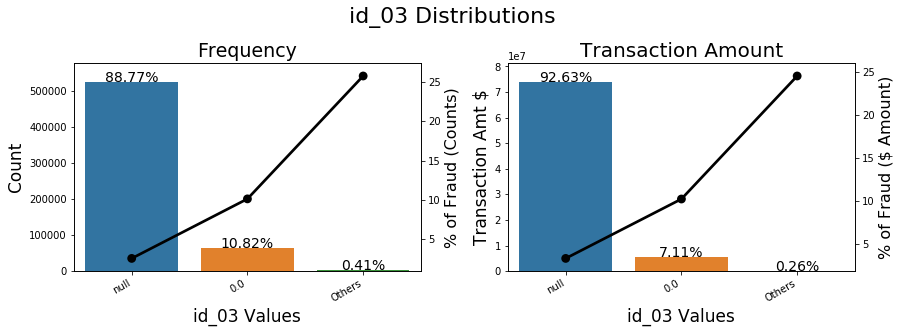

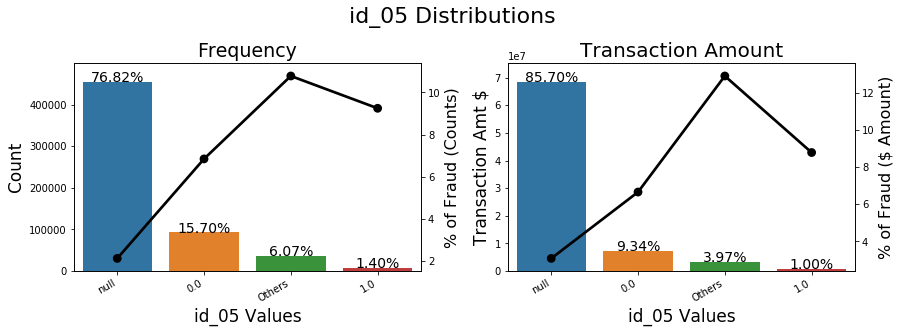

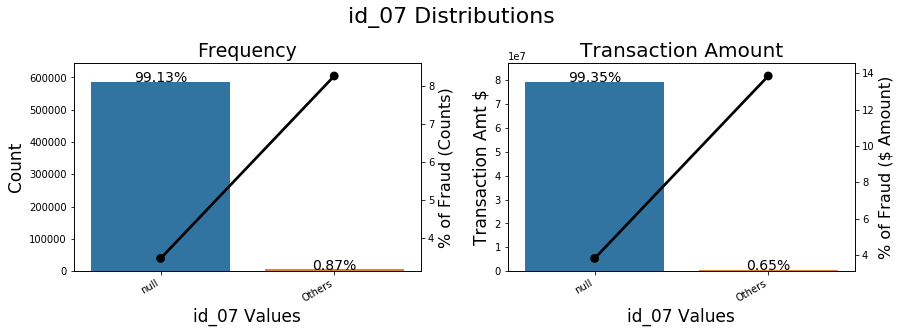

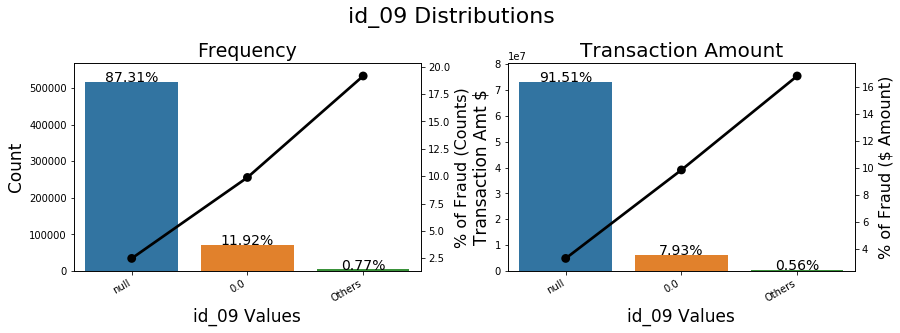

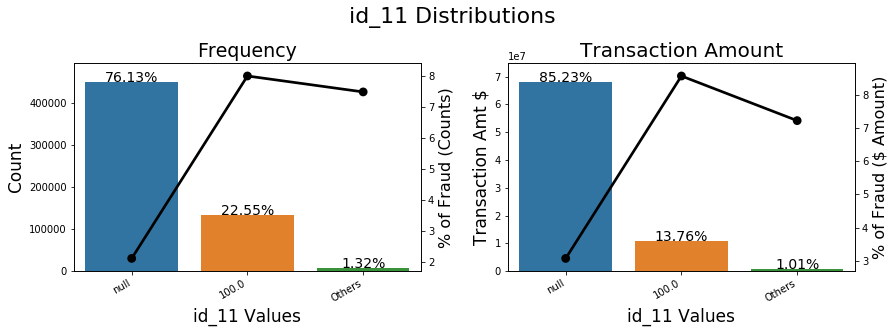

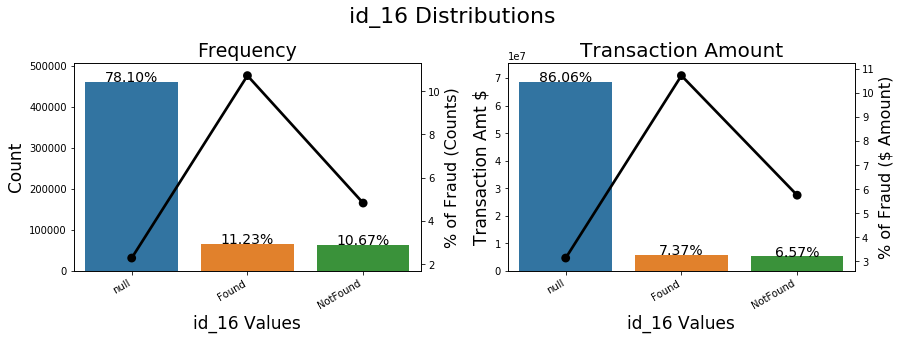

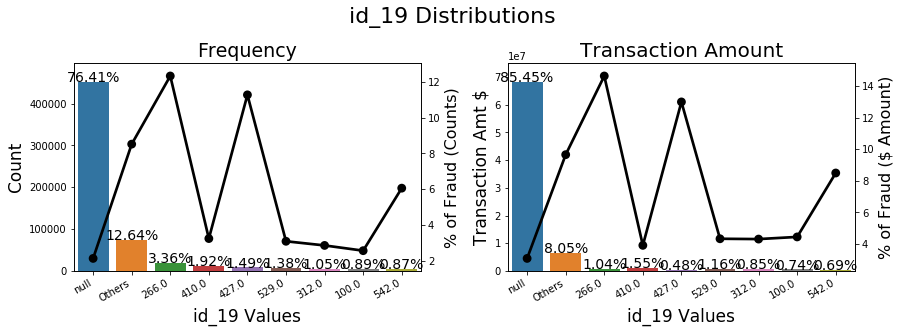

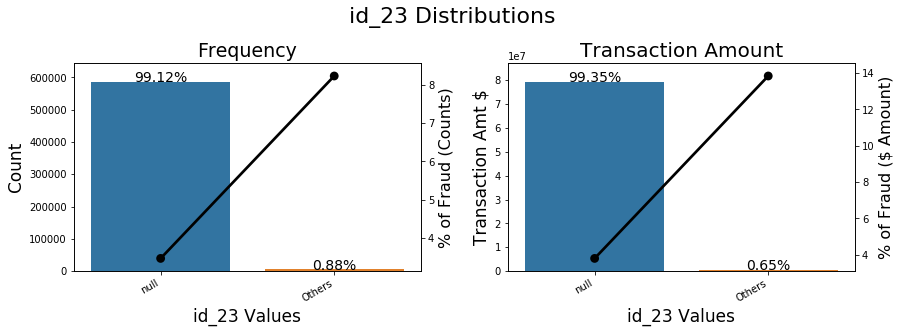

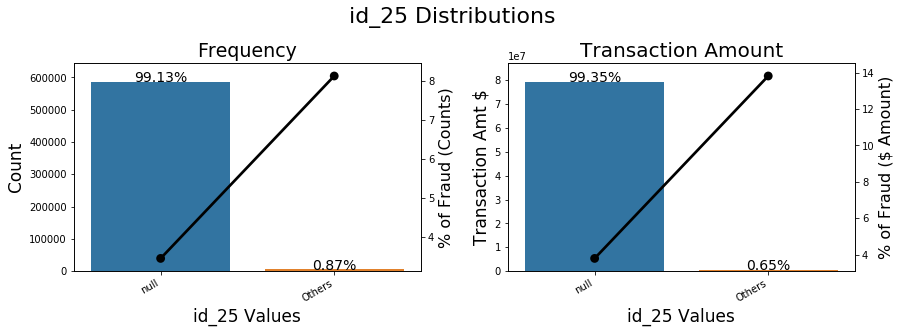

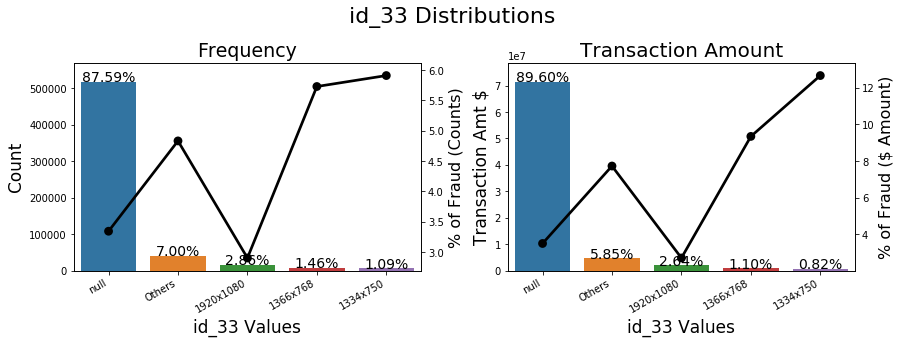

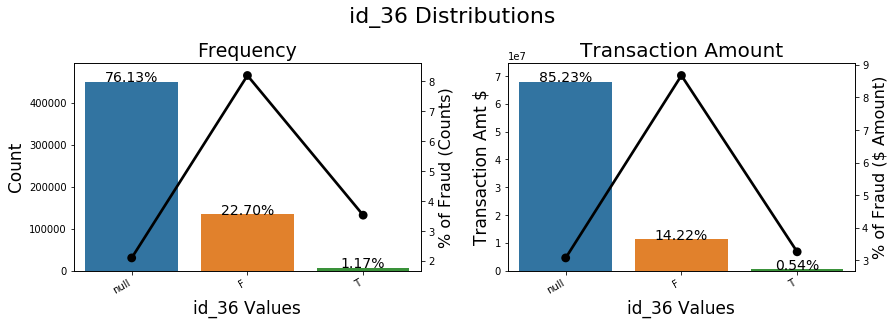

In [44]:
for ft in ['id_01','id_02','id_03','id_05','id_07','id_09','id_11','id_16','id_19','id_23','id_25','id_33','id_36']:
    bar_plot(df,ft,reduced=True,xtick_rotate=True)

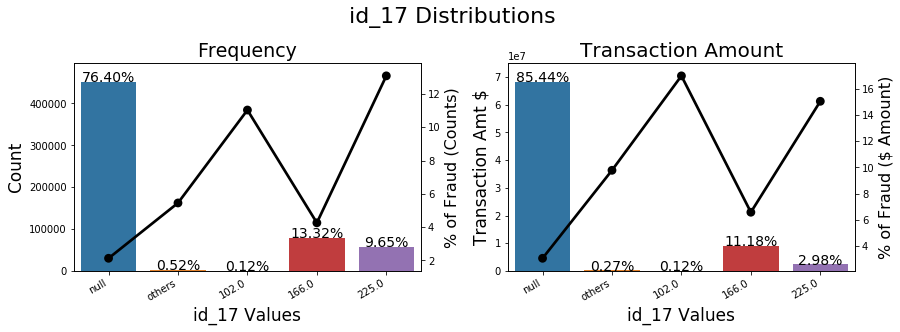

In [101]:
bar_plot(df,'id_17',reduced=True,xtick_rotate=True,others_threshold=500,sorted_plot_order=True)

<a id='Device'></a>

# Device features <a name='Device' />

In [2959]:
summary_table(df[list(df.columns)[432:]]).transpose()

DeviceType DeviceInfo
dtypes      object     object
missing     449730     471874
uniques          2       1786
min            nan        nan
max            nan        nan
top        desktop    Windows
freq         85165      47722

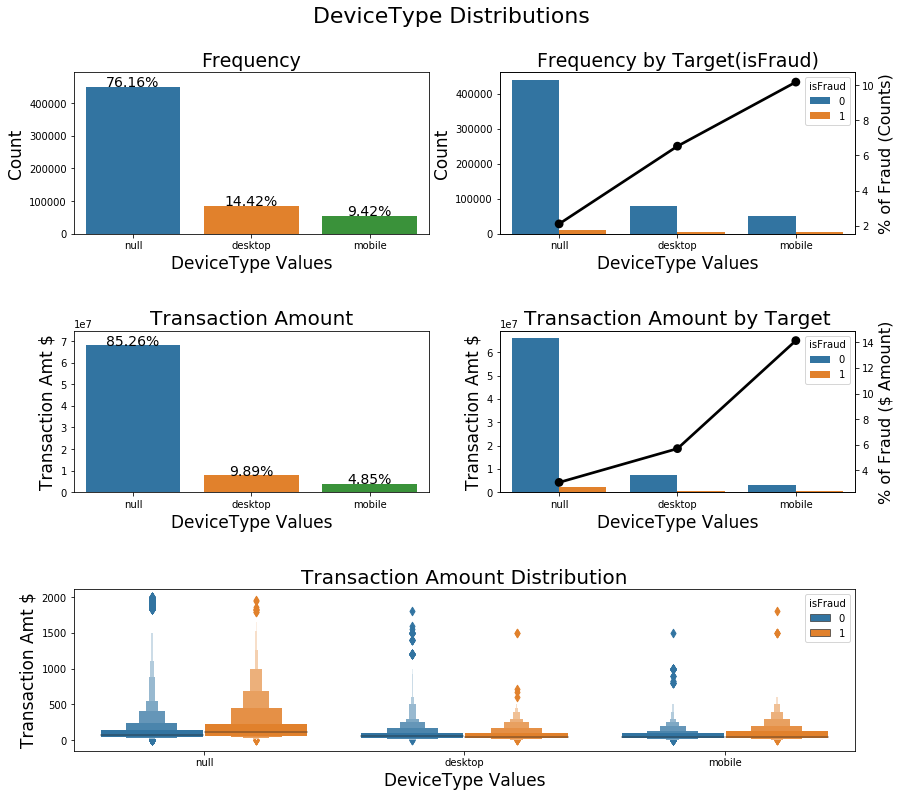

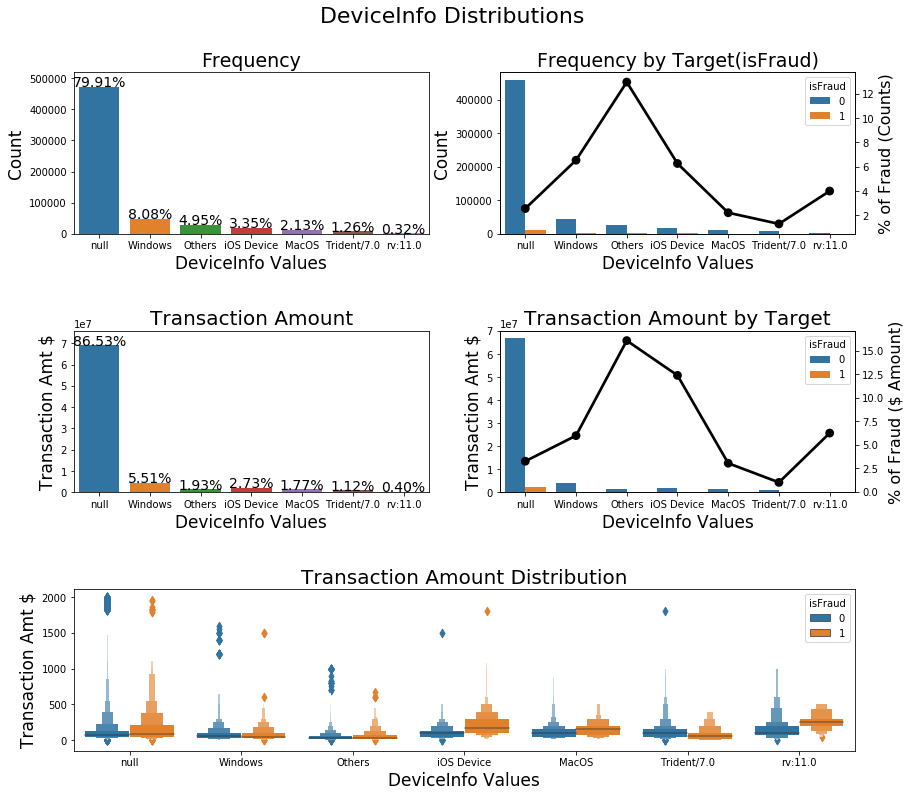

In [47]:
bar_plot(df,'DeviceType')
bar_plot(df,'DeviceInfo',others_threshold=1000)

- DeviceType desktop shows lower %Fraud in TransAmt than %Fraud in Counts
- DeviceType mobile shows higher %Fraud in TransAmt than %Fraud in Counts
- DeviceInfo iOS Device shows significantly higher %Fraud in TransAmt than %Fraud in Counts

In [45]:
df['DeviceInfo'].value_counts()

Windows                   47722
iOS Device                19782
MacOS                     12573
Trident/7.0                7440
rv:11.0                    1901
                          ...  
E2303                         1
SM-G900FD                     1
SM-T380                       1
Aquaris X Build/NMF26F        1
SM-J320W8                     1
Name: DeviceInfo, Length: 1786, dtype: int64

<a id='dtypes'></a>

In [2]:
df_dtypes = {'TransactionID': np.int32,
 'isFraud': np.int8,
 'TransactionDT': np.int32,
 'TransactionAmt': np.float32,
 'ProductCD': np.object_,
 'card1': np.int32,
 'card2': np.float32,
 'card3': np.float32,
 'card4': np.object_,
 'card5': np.float32,
 'card6': np.object_,
 'addr1': np.float32,
 'addr2': np.float32,
 'dist1': np.float32,
 'dist2': np.float32,
 'P_emaildomain': np.object_,
 'R_emaildomain': np.object_,
 'C1': np.float32,
 'C2': np.float32,
 'C3': np.float32,
 'C4': np.float32,
 'C5': np.float32,
 'C6': np.float32,
 'C7': np.float32,
 'C8': np.float32,
 'C9': np.float32,
 'C10': np.float32,
 'C11': np.float32,
 'C12': np.float32,
 'C13': np.float32,
 'C14': np.float32,
 'D1': np.float32,
 'D2': np.float32,
 'D3': np.float32,
 'D4': np.float32,
 'D5': np.float32,
 'D6': np.float32,
 'D7': np.float32,
 'D8': np.float32,
 'D9': np.float32,
 'D10': np.float32,
 'D11': np.float32,
 'D12': np.float32,
 'D13': np.float32,
 'D14': np.float32,
 'D15': np.float32,
 'M1': np.object_,
 'M2': np.object_,
 'M3': np.object_,
 'M4': np.object_,
 'M5': np.object_,
 'M6': np.object_,
 'M7': np.object_,
 'M8': np.object_,
 'M9': np.object_,
 'V1': np.float32,
 'V2': np.float32,
 'V3': np.float32,
 'V4': np.float32,
 'V5': np.float32,
 'V6': np.float32,
 'V7': np.float32,
 'V8': np.float32,
 'V9': np.float32,
 'V10': np.float32,
 'V11': np.float32,
 'V12': np.float32,
 'V13': np.float32,
 'V14': np.float32,
 'V15': np.float32,
 'V16': np.float32,
 'V17': np.float32,
 'V18': np.float32,
 'V19': np.float32,
 'V20': np.float32,
 'V21': np.float32,
 'V22': np.float32,
 'V23': np.float32,
 'V24': np.float32,
 'V25': np.float32,
 'V26': np.float32,
 'V27': np.float32,
 'V28': np.float32,
 'V29': np.float32,
 'V30': np.float32,
 'V31': np.float32,
 'V32': np.float32,
 'V33': np.float32,
 'V34': np.float32,
 'V35': np.float32,
 'V36': np.float32,
 'V37': np.float32,
 'V38': np.float32,
 'V39': np.float32,
 'V40': np.float32,
 'V41': np.float32,
 'V42': np.float32,
 'V43': np.float32,
 'V44': np.float32,
 'V45': np.float32,
 'V46': np.float32,
 'V47': np.float32,
 'V48': np.float32,
 'V49': np.float32,
 'V50': np.float32,
 'V51': np.float32,
 'V52': np.float32,
 'V53': np.float32,
 'V54': np.float32,
 'V55': np.float32,
 'V56': np.float32,
 'V57': np.float32,
 'V58': np.float32,
 'V59': np.float32,
 'V60': np.float32,
 'V61': np.float32,
 'V62': np.float32,
 'V63': np.float32,
 'V64': np.float32,
 'V65': np.float32,
 'V66': np.float32,
 'V67': np.float32,
 'V68': np.float32,
 'V69': np.float32,
 'V70': np.float32,
 'V71': np.float32,
 'V72': np.float32,
 'V73': np.float32,
 'V74': np.float32,
 'V75': np.float32,
 'V76': np.float32,
 'V77': np.float32,
 'V78': np.float32,
 'V79': np.float32,
 'V80': np.float32,
 'V81': np.float32,
 'V82': np.float32,
 'V83': np.float32,
 'V84': np.float32,
 'V85': np.float32,
 'V86': np.float32,
 'V87': np.float32,
 'V88': np.float32,
 'V89': np.float32,
 'V90': np.float32,
 'V91': np.float32,
 'V92': np.float32,
 'V93': np.float32,
 'V94': np.float32,
 'V95': np.float32,
 'V96': np.float32,
 'V97': np.float32,
 'V98': np.float32,
 'V99': np.float32,
 'V100': np.float32,
 'V101': np.float32,
 'V102': np.float32,
 'V103': np.float32,
 'V104': np.float32,
 'V105': np.float32,
 'V106': np.float32,
 'V107': np.float32,
 'V108': np.float32,
 'V109': np.float32,
 'V110': np.float32,
 'V111': np.float32,
 'V112': np.float32,
 'V113': np.float32,
 'V114': np.float32,
 'V115': np.float32,
 'V116': np.float32,
 'V117': np.float32,
 'V118': np.float32,
 'V119': np.float32,
 'V120': np.float32,
 'V121': np.float32,
 'V122': np.float32,
 'V123': np.float32,
 'V124': np.float32,
 'V125': np.float32,
 'V126': np.float32,
 'V127': np.float32,
 'V128': np.float32,
 'V129': np.float32,
 'V130': np.float32,
 'V131': np.float32,
 'V132': np.float32,
 'V133': np.float32,
 'V134': np.float32,
 'V135': np.float32,
 'V136': np.float32,
 'V137': np.float32,
 'V138': np.float32,
 'V139': np.float32,
 'V140': np.float32,
 'V141': np.float32,
 'V142': np.float32,
 'V143': np.float32,
 'V144': np.float32,
 'V145': np.float32,
 'V146': np.float32,
 'V147': np.float32,
 'V148': np.float32,
 'V149': np.float32,
 'V150': np.float32,
 'V151': np.float32,
 'V152': np.float32,
 'V153': np.float32,
 'V154': np.float32,
 'V155': np.float32,
 'V156': np.float32,
 'V157': np.float32,
 'V158': np.float32,
 'V159': np.float32,
 'V160': np.float32,
 'V161': np.float32,
 'V162': np.float32,
 'V163': np.float32,
 'V164': np.float32,
 'V165': np.float32,
 'V166': np.float32,
 'V167': np.float32,
 'V168': np.float32,
 'V169': np.float32,
 'V170': np.float32,
 'V171': np.float32,
 'V172': np.float32,
 'V173': np.float32,
 'V174': np.float32,
 'V175': np.float32,
 'V176': np.float32,
 'V177': np.float32,
 'V178': np.float32,
 'V179': np.float32,
 'V180': np.float32,
 'V181': np.float32,
 'V182': np.float32,
 'V183': np.float32,
 'V184': np.float32,
 'V185': np.float32,
 'V186': np.float32,
 'V187': np.float32,
 'V188': np.float32,
 'V189': np.float32,
 'V190': np.float32,
 'V191': np.float32,
 'V192': np.float32,
 'V193': np.float32,
 'V194': np.float32,
 'V195': np.float32,
 'V196': np.float32,
 'V197': np.float32,
 'V198': np.float32,
 'V199': np.float32,
 'V200': np.float32,
 'V201': np.float32,
 'V202': np.float32,
 'V203': np.float32,
 'V204': np.float32,
 'V205': np.float32,
 'V206': np.float32,
 'V207': np.float32,
 'V208': np.float32,
 'V209': np.float32,
 'V210': np.float32,
 'V211': np.float32,
 'V212': np.float32,
 'V213': np.float32,
 'V214': np.float32,
 'V215': np.float32,
 'V216': np.float32,
 'V217': np.float32,
 'V218': np.float32,
 'V219': np.float32,
 'V220': np.float32,
 'V221': np.float32,
 'V222': np.float32,
 'V223': np.float32,
 'V224': np.float32,
 'V225': np.float32,
 'V226': np.float32,
 'V227': np.float32,
 'V228': np.float32,
 'V229': np.float32,
 'V230': np.float32,
 'V231': np.float32,
 'V232': np.float32,
 'V233': np.float32,
 'V234': np.float32,
 'V235': np.float32,
 'V236': np.float32,
 'V237': np.float32,
 'V238': np.float32,
 'V239': np.float32,
 'V240': np.float32,
 'V241': np.float32,
 'V242': np.float32,
 'V243': np.float32,
 'V244': np.float32,
 'V245': np.float32,
 'V246': np.float32,
 'V247': np.float32,
 'V248': np.float32,
 'V249': np.float32,
 'V250': np.float32,
 'V251': np.float32,
 'V252': np.float32,
 'V253': np.float32,
 'V254': np.float32,
 'V255': np.float32,
 'V256': np.float32,
 'V257': np.float32,
 'V258': np.float32,
 'V259': np.float32,
 'V260': np.float32,
 'V261': np.float32,
 'V262': np.float32,
 'V263': np.float32,
 'V264': np.float32,
 'V265': np.float32,
 'V266': np.float32,
 'V267': np.float32,
 'V268': np.float32,
 'V269': np.float32,
 'V270': np.float32,
 'V271': np.float32,
 'V272': np.float32,
 'V273': np.float32,
 'V274': np.float32,
 'V275': np.float32,
 'V276': np.float32,
 'V277': np.float32,
 'V278': np.float32,
 'V279': np.float32,
 'V280': np.float32,
 'V281': np.float32,
 'V282': np.float32,
 'V283': np.float32,
 'V284': np.float32,
 'V285': np.float32,
 'V286': np.float32,
 'V287': np.float32,
 'V288': np.float32,
 'V289': np.float32,
 'V290': np.float32,
 'V291': np.float32,
 'V292': np.float32,
 'V293': np.float32,
 'V294': np.float32,
 'V295': np.float32,
 'V296': np.float32,
 'V297': np.float32,
 'V298': np.float32,
 'V299': np.float32,
 'V300': np.float32,
 'V301': np.float32,
 'V302': np.float32,
 'V303': np.float32,
 'V304': np.float32,
 'V305': np.float32,
 'V306': np.float32,
 'V307': np.float32,
 'V308': np.float32,
 'V309': np.float32,
 'V310': np.float32,
 'V311': np.float32,
 'V312': np.float32,
 'V313': np.float32,
 'V314': np.float32,
 'V315': np.float32,
 'V316': np.float32,
 'V317': np.float32,
 'V318': np.float32,
 'V319': np.float32,
 'V320': np.float32,
 'V321': np.float32,
 'V322': np.float32,
 'V323': np.float32,
 'V324': np.float32,
 'V325': np.float32,
 'V326': np.float32,
 'V327': np.float32,
 'V328': np.float32,
 'V329': np.float32,
 'V330': np.float32,
 'V331': np.float32,
 'V332': np.float32,
 'V333': np.float32,
 'V334': np.float32,
 'V335': np.float32,
 'V336': np.float32,
 'V337': np.float32,
 'V338': np.float32,
 'V339': np.float32,
 'id_01': np.float32,
 'id_02': np.float32,
 'id_03': np.float32,
 'id_04': np.float32,
 'id_05': np.float32,
 'id_06': np.float32,
 'id_07': np.float32,
 'id_08': np.float32,
 'id_09': np.float32,
 'id_10': np.float32,
 'id_11': np.float32,
 'id_12': np.object_,
 'id_13': np.float32,
 'id_14': np.float32,
 'id_15': np.object_,
 'id_16': np.object_,
 'id_17': np.float32,
 'id_18': np.float32,
 'id_19': np.float32,
 'id_20': np.float32,
 'id_21': np.float32,
 'id_22': np.float32,
 'id_23': np.object_,
 'id_24': np.float32,
 'id_25': np.float32,
 'id_26': np.float32,
 'id_27': np.object_,
 'id_28': np.object_,
 'id_29': np.object_,
 'id_30': np.object_,
 'id_31': np.object_,
 'id_32': np.float32,
 'id_33': np.object_,
 'id_34': np.object_,
 'id_35': np.object_,
 'id_36': np.object_,
 'id_37': np.object_,
 'id_38': np.object_,
# test file has name id-00             
 'id-01': np.float32,
 'id-02': np.float32,
 'id-03': np.float32,
 'id-04': np.float32,
 'id-05': np.float32,
 'id-06': np.float32,
 'id-07': np.float32,
 'id-08': np.float32,
 'id-09': np.float32,
 'id-10': np.float32,
 'id-11': np.float32,
 'id-12': np.object_,
 'id-13': np.float32,
 'id-14': np.float32,
 'id-15': np.object_,
 'id-16': np.object_,
 'id-17': np.float32,
 'id-18': np.float32,
 'id-19': np.float32,
 'id-20': np.float32,
 'id-21': np.float32,
 'id-22': np.float32,
 'id-23': np.object_,
 'id-24': np.float32,
 'id-25': np.float32,
 'id-26': np.float32,
 'id-27': np.object_,
 'id-28': np.object_,
 'id-29': np.object_,
 'id-30': np.object_,
 'id-31': np.object_,
 'id-32': np.float32,
 'id-33': np.object_,
 'id-34': np.object_,
 'id-35': np.object_,
 'id-36': np.object_,
 'id-37': np.object_,
 'id-38': np.object_,             
 'DeviceType': np.object_,
 'DeviceInfo': np.object_}